# <b><span style='color:#F1A424'>|</span> HMS: <span style='color:#F1A424'>WaveNet</span><span style='color:#ABABAB'> [Train]</span></b> 

***

**Consider upvoting this notebook if you find it useful 🙌🏼**

This is the **PyTorch 🔥 version** of [Chris Deotte WaveNet Starter](https://www.kaggle.com/code/cdeotte/wavenet-starter-lb-0-52) give him an upvote too! ⬆️

Your goal in this competition is to detect and classify seizures and other types of harmful brain activity. You will develop a model trained on electroencephalography (EEG) signals recorded from critically ill hospital patients.

In this notebook you will learn how to train a `WaveNet` model for seizures classification using PyTorch. Hope you enjoy it and find it useful.

I also made a **PyTorch 🔥 version** of Chris' EfficientNetB0 notebook here:
- [HMS | EfficientNetB0 PyTorch [Train]](https://www.kaggle.com/code/alejopaullier/hms-efficientnetb0-pytorch-train)
- [HMS | EfficientNetB0 PyTorch [Inference]](https://www.kaggle.com/code/alejopaullier/hms-efficientnetb0-pytorch-inference)

### <b><span style='color:#F1A424'>Table of Contents</span></b> <a class='anchor' id='top'></a>
<div style=" background-color:#3b3745; padding: 13px 13px; border-radius: 8px; color: white">
<li> <a href="#introduction">Introduction</a></li>
<li> <a href="#install_libraries">Install libraries</a></li>
<li><a href="#import_libraries">Import Libraries</a></li>
<li><a href="#configuration">Configuration</a></li>
<li><a href="#utils">Utils</a></li>
<li><a href="#load_data">Load Data</a></li>
<li><a href="#preprocessing">Data Pre-processing</a></li>
<li><a href="#validation">Validation</a></li>
<li><a href="#dataset">Dataset</a></li>
<li><a href="#dataloader">DataLoader</a></li>
<li><a href="#model">Model</a></li>
<li><a href="#scheduler">Scheduler</a></li>
<li><a href="#loss">Loss Function</a></li>
<li><a href="#functions">Train and Validation Functions</a></li>
<li><a href="#train_loop">Train Loop</a></li>
<li><a href="#train_full">Full Train</a></li>
<li><a href="#train">Train</a></li>
<li><a href="#train">Score</a></li>
</div>


# <b><span style='color:#F1A424'>|</span> Introduction</b><a class='anchor' id='introduction'></a> [↑](#top) 

***

This model only uses two features. We can engineer more features and/or modify the model architecture to improve CV score and LB score. Furthermore we can build 1 model which inputs both spectrogram images and eeg waveforms. The two EEG features in this notebook are:
- feature 1 : `Fp1 minus O1`
- feature 2 : `Fp2 minus O2`

Feature 1 is the beginning of the montage chains `LL` and `LP` minus the ending of montage `LL` and `LP`. And feature 2 is the beginning of the montage chains `RL` and `RP` minus the ending of montage `RL` and `RP`.

<center><img src=https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/Jan-2024/montage.png width=600></center>

We add more features and update the model architecture to evaluate each montage chain separately and then concatenate the features. This new architecture is motivated by the discovery of a better formula to utilize EEG explained in discussion [here][2]

* Version 5,6: Use 2 features - CV 0.91 LB 0.66
* Version 7,8: Use 8 features grouped as 4 chains. Downsample time 5x - **CV 0.81 LB 0.53**, wow!

We train our new model in version 7, then save model weights. Then load model into version 8 to submit to LB.

<center><img src=https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/Jan-2024/wave-model.png width=800></center>

[1]: https://www.kaggle.com/code/seshurajup/eda-train-csv
[2]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/469760

### <b><span style='color:#F1A424'>Useful References</span></b>

- [Understand this competition's data](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/468010)


# <b><span style='color:#F1A424'>|</span> Import Libraries</b><a class='anchor' id='import_libraries'></a> [↑](#top) 

***

Import all the required libraries for this notebook.

In [1]:
import gc
import math
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import pandas as pd
import random
import time
import torch
import torch.nn as nn


from glob import glob
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from typing import Dict, List

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using', torch.cuda.device_count(), 'GPU(s)')
!mkdir models

Using 1 GPU(s)
mkdir: cannot create directory ‘models’: File exists


# <b><span style='color:#F1A424'>|</span> Configuration</b><a class='anchor' id='configuration'></a> [↑](#top) 

***

In [2]:
class config:
    AMP = True
    BATCH_SIZE_TRAIN = 64#32
    BATCH_SIZE_VALID = 64#32
    EPOCHS = 30
    FOLDS = 4
    GRADIENT_ACCUMULATION_STEPS = 1
    MAX_GRAD_NORM = 1e7
    NUM_WORKERS = 0 # multiprocessing.cpu_count()
    PRINT_FREQ = 20
    SEED = 20
    TRAIN_FULL_DATA = False
    VISUALIZE = True
    WEIGHT_DECAY = 0.01
    
    
class paths:
    OUTPUT_DIR = "/kaggle/working/"
    TRAIN_CSV = "../shared_data/hms_data/raw_data/train.csv"
    TRAIN_EEGS = "../shared_data/hms_data/raw_data/train_eegs/"

# <b><span style='color:#F1A424'>|</span> Utils</b><a class='anchor' id='utils'></a> [↑](#top) 

***

Utility functions.

In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s: float):
    "Convert to minutes."
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since: float, percent: float):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def eeg_from_parquet(parquet_path: str, display: bool = False) -> np.ndarray:
    """
    This function reads a parquet file and extracts the middle 50 seconds of readings. Then it fills NaN values
    with the mean value (ignoring NaNs).
    :param parquet_path: path to parquet file.
    :param display: whether to display EEG plots or not.
    :return data: np.array of shape  (time_steps, eeg_features) -> (10_000, 8)
    """
    # === Extract middle 50 seconds ===
    eeg = pd.read_parquet(parquet_path, columns=eeg_features)
    rows = len(eeg)
    offset = (rows - 10_000) // 2 # 50 * 200 = 10_000
    eeg = eeg.iloc[offset:offset+10_000] # middle 50 seconds, has the same amount of readings to left and right
    if display: 
        plt.figure(figsize=(10,5))
        offset = 0
    # === Convert to numpy ===
    data = np.zeros((10_000, len(eeg_features))) # create placeholder of same shape with zeros
    for index, feature in enumerate(eeg_features):
        x = eeg[feature].values.astype('float32') # convert to float32
        mean = np.nanmean(x) # arithmetic mean along the specified axis, ignoring NaNs
        nan_percentage = np.isnan(x).mean() # percentage of NaN values in feature
        # === Fill nan values ===
        if nan_percentage < 1: # if some values are nan, but not all
            x = np.nan_to_num(x, nan=mean)
        else: # if all values are nan
            x[:] = 0
        data[:, index] = x
        if display: 
            if index != 0:
                offset += x.max()
            plt.plot(range(10_000), x-offset, label=feature)
            offset -= x.min()
    if display:
        plt.legend()
        name = parquet_path.split('/')[-1].split('.')[0]
        plt.yticks([])
        plt.title(f'EEG {name}',size=16)
        plt.show()    
    return data


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) 
    
    
def sep():
    print("-"*100)

    
target_preds = [x + "_pred" for x in ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
label_to_num = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other':5}
num_to_label = {v: k for k, v in label_to_num.items()}
seed_everything(config.SEED)

# <b><span style='color:#F1A424'>|</span> Load Data</b><a class='anchor' id='load_data'></a> [↑](#top) 

***

Load the competition's data.

In [4]:
train_df = pd.read_csv(paths.TRAIN_CSV)
label_cols = train_df.columns[-6:]
print(f"Train cataframe shape is: {train_df.shape}")
print(f"Labels: {list(label_cols)}")
train_df.head()

Train cataframe shape is: (106800, 15)
Labels: ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


### <b><span style='color:#F1A424'>Read one EEG parquet</span></b>

All of the EEG data (for both train and test) was collected at a frequency of 200 samples per second,

Each EEG parquet results in a dataframe with `seconds` rows and 20 columns.

- EEG features are: `['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']`
- We will use these features: `['Fp1','T3','C3','O1','Fp2','C4','T4','O2']`



In [5]:
eeg_df = pd.read_parquet(paths.TRAIN_EEGS + "100261680.parquet")
eeg_features = eeg_df.columns
print(f'There are {len(eeg_features)} raw eeg features')
print(list(eeg_features))
eeg_features = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
feature_to_index = {x:y for x,y in zip(eeg_features, range(len(eeg_features)))}

There are 20 raw eeg features
['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']


### <b><span style='color:#F1A424'>Read all EEG parquets</span></b>

In [6]:
### read in each npy file

FILT_EEG_PATH = '../shared_data/hms_data/train_eegs_processed/eeg_filt_' # all_filt_eegs/'
all_eegs = np.empty((0, 10000, 20))  # this will hold all the filtered eegs

for i in range (1,100):
        #print(i)
        this_dict = np.load(FILT_EEG_PATH + '{:04d}'.format(i) + '.npy', allow_pickle=True)
        all_eegs = np.concatenate((all_eegs, this_dict), axis=0)

print(len(all_eegs))

9900


In [7]:
all_eegs.shape

(9900, 10000, 20)

In [8]:
labels_df = pd.DataFrame(np.load('../shared_data/hms_data/eeg_filt_labels.npy',allow_pickle=True))

In [9]:
labels_df.iloc[0:all_eegs.shape[0]]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,/scratch/eecs545w24_class_root/eecs545w24_clas...
1,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0,/scratch/eecs545w24_class_root/eecs545w24_clas...
2,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0,/scratch/eecs545w24_class_root/eecs545w24_clas...
3,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0,/scratch/eecs545w24_class_root/eecs545w24_clas...
4,1628180742,5,26.0,353733,5,26.0,2413091605,42516,Seizure,3,0,0,0,0,0,/scratch/eecs545w24_class_root/eecs545w24_clas...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9895,1758805110,1,2.0,181657882,1,2.0,1941166580,36197,GPD,5,0,8,0,0,1,/scratch/eecs545w24_class_root/eecs545w24_clas...
9896,1758805110,2,6.0,181657882,2,6.0,2832854072,36197,GPD,5,0,8,0,0,1,/scratch/eecs545w24_class_root/eecs545w24_clas...
9897,1758805110,3,8.0,181657882,3,8.0,59558685,36197,GPD,5,0,8,0,0,1,/scratch/eecs545w24_class_root/eecs545w24_clas...
9898,1758805110,4,12.0,181657882,4,12.0,2160976616,36197,GPD,5,0,8,0,0,1,/scratch/eecs545w24_class_root/eecs545w24_clas...


# <b><span style='color:#F1A424'>|</span> Data pre-processing</b><a class='anchor' id='preprocessing'></a> [↑](#top) 

***

In [10]:
eeg_ids = train_df.eeg_id.unique()
len(eeg_ids)

17089

In [11]:
#label_cols

In [12]:
df = pd.read_csv(paths.TRAIN_CSV)
label_cols = df.columns[-6:]



In [13]:
train_df = df[df.columns[-7:]]

In [14]:
train_df = train_df.iloc[0:all_eegs.shape[0]]
train_df['eeg'] = None

In [15]:
train_df

,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg
0,Seizure,3,0,0,0,0,0,None
1,Seizure,3,0,0,0,0,0,None
2,Seizure,3,0,0,0,0,0,None
3,Seizure,3,0,0,0,0,0,None
4,Seizure,3,0,0,0,0,0,None
...,...,...,...,...,...,...,...,...
9895,GPD,5,0,8,0,0,1,None
9896,GPD,5,0,8,0,0,1,None
9897,GPD,5,0,8,0,0,1,None
9898,GPD,5,0,8,0,0,1,None


In [16]:
for i in range(len(train_df)):
    train_df["eeg"][i] = all_eegs[i, :, :]

/tmp/ipykernel_2352963/3563820098.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["eeg"][i] = all_eegs[i, :, :]


In [17]:
#train_df = df.groupby('eeg_id')[['patient_id']].agg('first')
#aux = df.groupby('eeg_id')[label_cols].agg('sum') 
#for label in label_cols:
#    train_df[label] = aux[label].values


y_data = train_df[label_cols].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train_df[label_cols] = y_data

#aux = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train_df['target'] = train_df['expert_consensus']
train_df = train_df.drop(['expert_consensus'], axis = 1)

train_df = train_df.reset_index()
#train_df = train_df.loc[train_df.eeg_id.isin(eeg_ids)]
print(f"Train dataframe with unique eeg_id has shape: {train_df.shape}")
train_df.head()

Train dataframe with unique eeg_id has shape: (9900, 9)


,index,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg,target
0,0,1.0,0.0,0.0,0.0,0.0,0.0,"[[3.552713678800501e-14, 2.5757174171303632e-1...",Seizure
1,1,1.0,0.0,0.0,0.0,0.0,0.0,"[[-4.796163466380676e-14, -2.6645352591003757e...",Seizure
2,2,1.0,0.0,0.0,0.0,0.0,0.0,"[[-5.329070518200751e-15, 0.0, 0.0, 1.77635683...",Seizure
3,3,1.0,0.0,0.0,0.0,0.0,0.0,"[[-3.3306690738754696e-14, -2.7533531010703882...",Seizure
4,4,1.0,0.0,0.0,0.0,0.0,0.0,"[[3.197442310920451e-14, 4.4853010194856324e-1...",Seizure


# <b><span style='color:#F1A424'>|</span> Validation</b><a class='anchor' id='validation'></a> [↑](#top) 

***

We train using `GroupKFold` on `patient_id`.

In [18]:
from sklearn.model_selection import KFold, GroupKFold


kf = KFold(n_splits=config.FOLDS)
#gkf = GroupKFold(n_splits=config.FOLDS)
#for fold, (train_index, valid_index) in enumerate(gkf.split(train_df, train_df.target, train_df.patient_id)):
#    train_df.loc[valid_index, "fold"] = int(fold)

for fold, (train_index, valid_index) in enumerate(kf.split(train_df)):
    print(fold)
    train_df.loc[valid_index, "fold"] = int(fold)
    
display(train_df.groupby('fold').size())
display(train_df.head())


#display(train_df.groupby('fold').size()), sep()
#display(train_df.head())

0
1
2
3


fold
0.0    2475
1.0    2475
2.0    2475
3.0    2475
dtype: int64

,index,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg,target,fold
0,0,1.0,0.0,0.0,0.0,0.0,0.0,"[[3.552713678800501e-14, 2.5757174171303632e-1...",Seizure,0.0
1,1,1.0,0.0,0.0,0.0,0.0,0.0,"[[-4.796163466380676e-14, -2.6645352591003757e...",Seizure,0.0
2,2,1.0,0.0,0.0,0.0,0.0,0.0,"[[-5.329070518200751e-15, 0.0, 0.0, 1.77635683...",Seizure,0.0
3,3,1.0,0.0,0.0,0.0,0.0,0.0,"[[-3.3306690738754696e-14, -2.7533531010703882...",Seizure,0.0
4,4,1.0,0.0,0.0,0.0,0.0,0.0,"[[3.197442310920451e-14, 4.4853010194856324e-1...",Seizure,0.0


# <b><span style='color:#F1A424'>|</span> Dataset</b><a class='anchor' id='dataset'></a> [↑](#top) 

***

Create a custom `Dataset` to load data.

- [How to Convert EEG to Spectrograms][1]: to understand the feature engineering performed in the generation method.
- [How To Create Spectrogram From Eeg?][2]: original post on how to create Spectrograms from EEGs.
- [Introduction to EEG][3]: short video to better understand EEGs.

[1]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/469760
[2]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467877
[3]: https://www.youtube.com/watch?v=XMizSSOejg0

In [23]:
class CustomDataset(Dataset):
    def __init__(
        self, df: pd.DataFrame, config, mode: str = 'train',
        eegs: Dict[int, np.ndarray] = all_eegs, downsample: int = 5
    ): 
        self.df = df
        self.config = config
        self.batch_size = self.config.BATCH_SIZE_TRAIN
        self.mode = mode
        self.eegs = eegs
        self.downsample = downsample
        
    def __len__(self):
        """
        Length of dataset.
        """
        return len(self.df)
        
    def __getitem__(self, index):
        """
        Get one item.
        """
        X, y = self.__data_generation(index)
        X = X[::self.downsample,:]
        output = {
            "X": torch.tensor(X, dtype=torch.float32),
            "y": torch.tensor(y, dtype=torch.float32)
        }
        return output
                        
    def __data_generation(self, index):
        row = self.df.iloc[index]
        X = np.zeros((10_000, 8), dtype='float32')
        y = np.zeros(6, dtype='float32')
        #data = self.eegs[row.eeg_id]
        
        # === Feature engineering ===
        #X[:,0] = data[:,feature_to_index['Fp1']] - data[:,feature_to_index['T3']]
        #X[:,1] = data[:,feature_to_index['T3']] - data[:,feature_to_index['O1']]

        #X[:,2] = data[:,feature_to_index['Fp1']] - data[:,feature_to_index['C3']]
        #X[:,3] = data[:,feature_to_index['C3']] - data[:,feature_to_index['O1']]

        #X[:,4] = data[:,feature_to_index['Fp2']] - data[:,feature_to_index['C4']]
        #X[:,5] = data[:,feature_to_index['C4']] - data[:,feature_to_index['O2']]

        #X[:,6] = data[:,feature_to_index['Fp2']] - data[:,feature_to_index['T4']]
        #X[:,7] = data[:,feature_to_index['T4']] - data[:,feature_to_index['O2']]

        X = row['eeg'][:,:19]
        # === Standarize ===
        X = np.clip(X,-1024, 1024)
        X = np.nan_to_num(X, nan=0) / 32.0

#         # === Butter Low-pass Filter ===
#         X = butter_lowpass_filter(X)
        
        if self.mode != 'test':
            y = row[label_cols].values.astype(np.float32)
            
        return X, y

In [24]:
#X = np.zeros((10_000, 8), dtype='float32')
        

In [25]:
#row = train_df.iloc[0]

In [26]:
feature_to_index

{'Fp1': 0, 'T3': 1, 'C3': 2, 'O1': 3, 'Fp2': 4, 'C4': 5, 'T4': 6, 'O2': 7}

# <b><span style='color:#F1A424'>|</span> DataLoader</b><a class='anchor' id='dataloader'></a> [↑](#top) 

***

In [26]:
train_dataset = CustomDataset(train_df, config, mode="train")
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE_TRAIN,
    shuffle=False,
    num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True
)
output = train_dataset[0]
X, y = output["X"], output["y"]
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: torch.Size([2000, 19])
y shape: torch.Size([6])


### <b><span style='color:#F1A424'> Visualize DataLoader</span></b>


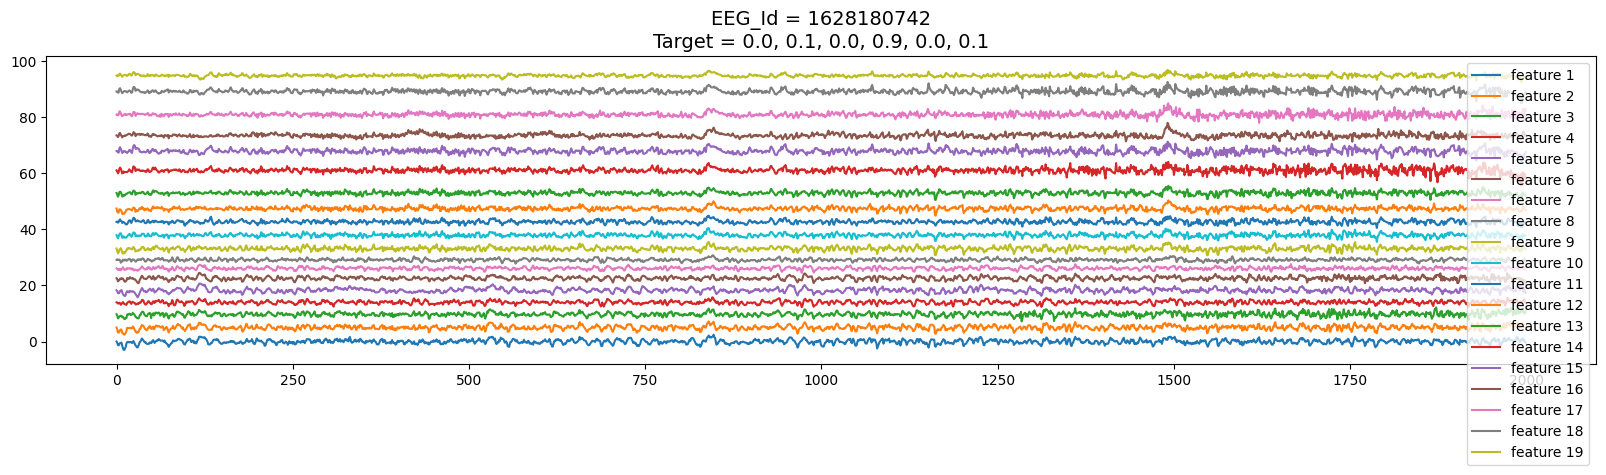

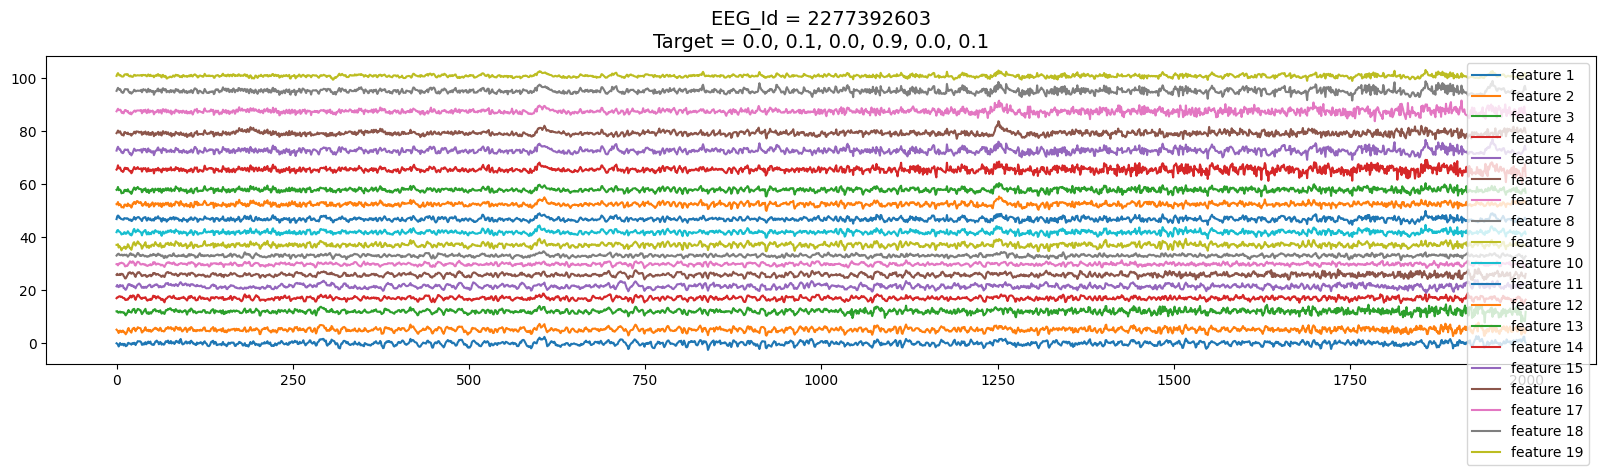

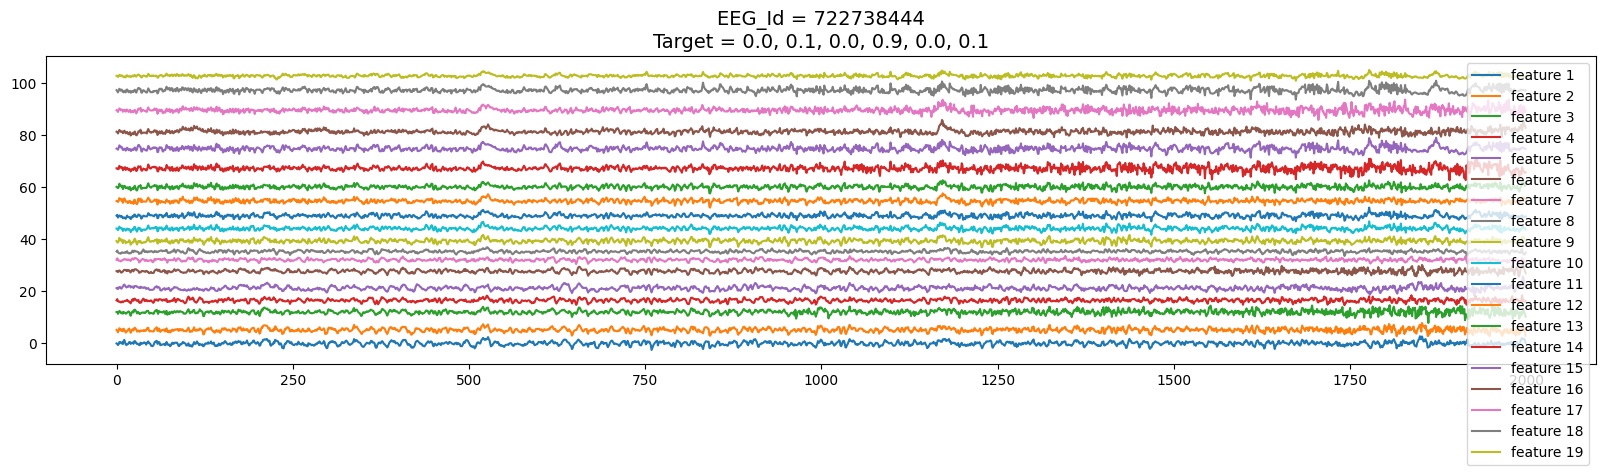

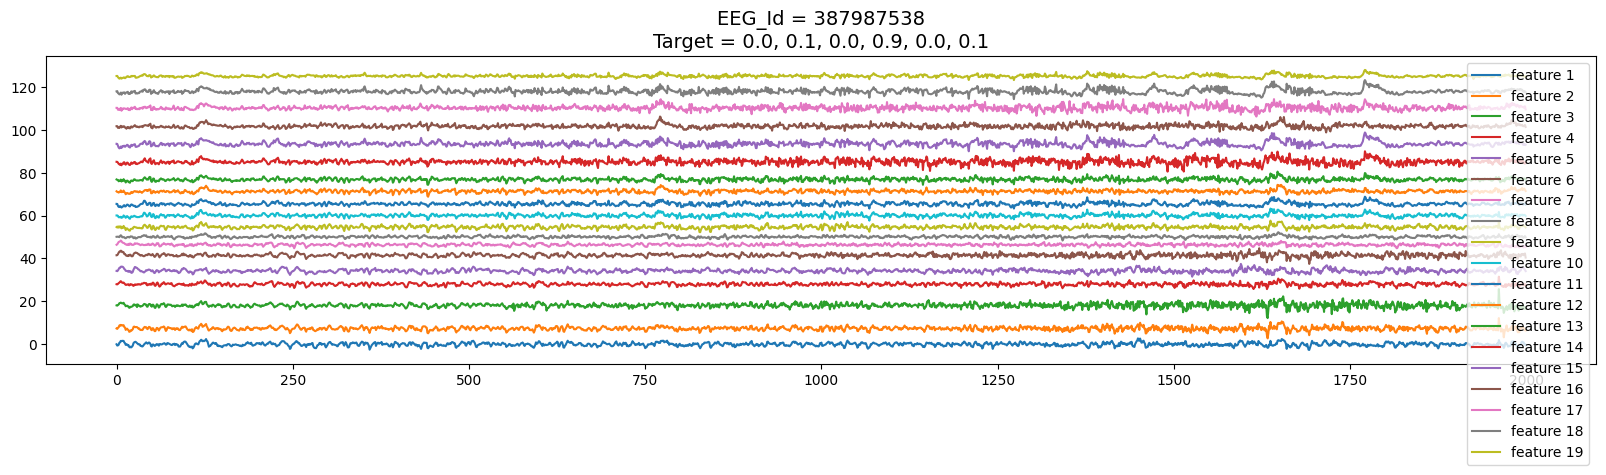

In [27]:
if config.VISUALIZE:
    for batch in train_loader:
        X = batch.pop("X")
        y = batch.pop("y")
        for item in range(4):
            plt.figure(figsize=(20,4))
            offset = 0
            for col in range(X.shape[-1]):
                if col != 0:
                    offset -= X[item,:,col].min()
                plt.plot(range(2_000), X[item,:,col]+offset,label=f'feature {col+1}')
                offset += X[item,:,col].max()
            tt = f'{y[col][0]:0.1f}'
            for t in y[col][1:]:
                tt += f', {t:0.1f}'
            plt.title(f'EEG_Id = {eeg_ids[item]}\nTarget = {tt}',size=14)
            plt.legend()
            plt.show()
        break

# <b><span style='color:#F1A424'>|</span> Model</b><a class='anchor' id='model'></a> [↑](#top) 

***

<center><img width = 800 src="https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/Jan-2024/wave-model.png"></center>

In [28]:
class Wave_Block(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, dilation_rates: int, kernel_size: int = 3):
        """
        WaveNet building block.
        :param in_channels: number of input channels.
        :param out_channels: number of output channels.
        :param dilation_rates: how many levels of dilations are used.
        :param kernel_size: size of the convolving kernel.
        """
        super(Wave_Block, self).__init__()
        self.num_rates = dilation_rates
        self.convs = nn.ModuleList()
        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()
        self.convs.append(nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=True))
        
        dilation_rates = [2 ** i for i in range(dilation_rates)]
        for dilation_rate in dilation_rates:
            self.filter_convs.append(
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size,
                          padding=int((dilation_rate*(kernel_size-1))/2), dilation=dilation_rate))
            self.gate_convs.append(
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size,
                          padding=int((dilation_rate*(kernel_size-1))/2), dilation=dilation_rate))
            self.convs.append(nn.Conv1d(out_channels, out_channels, kernel_size=1, bias=True))
        
        for i in range(len(self.convs)):
            nn.init.xavier_uniform_(self.convs[i].weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(self.convs[i].bias)

        for i in range(len(self.filter_convs)):
            nn.init.xavier_uniform_(self.filter_convs[i].weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(self.filter_convs[i].bias)

        for i in range(len(self.gate_convs)):
            nn.init.xavier_uniform_(self.gate_convs[i].weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(self.gate_convs[i].bias)

    def forward(self, x):
        x = self.convs[0](x)
        res = x
        for i in range(self.num_rates):
            tanh_out = torch.tanh(self.filter_convs[i](x))
            sigmoid_out = torch.sigmoid(self.gate_convs[i](x))
            x = tanh_out * sigmoid_out
            x = self.convs[i + 1](x) 
            res = res + x
        return res
    
class WaveNet(nn.Module):
    def __init__(self, input_channels: int = 1, kernel_size: int = 3):
        super(WaveNet, self).__init__()
        self.model = nn.Sequential(
                Wave_Block(input_channels, 8, 12, kernel_size),
                Wave_Block(8, 16, 8, kernel_size),
                Wave_Block(16, 32, 4, kernel_size),
                Wave_Block(32, 64, 1, kernel_size) 
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 2, 1) 
        output = self.model(x)
        return output


class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.model = WaveNet()
        self.global_avg_pooling = nn.AdaptiveAvgPool1d(1)
        self.dropout = 0.0
        self.head = nn.Sequential(
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(64, 6)
        )
        
    def forward(self, x: torch.Tensor):
        """
        Forwward pass.
        """
        x1 = self.model(x[:, :, 0:1])
        x1 = self.global_avg_pooling(x1)
        x1 = x1.squeeze()
        x2 = self.model(x[:, :, 1:2])
        x2 = self.global_avg_pooling(x2)
        x2 = x2.squeeze()
        z1 = torch.mean(torch.stack([x1, x2]), dim=0)

        x1 = self.model(x[:, :, 2:3])
        x1 = self.global_avg_pooling(x1)
        x1 = x1.squeeze()
        x2 = self.model(x[:, :, 3:4])
        x2 = self.global_avg_pooling(x2)
        x2 = x2.squeeze()
        z2 = torch.mean(torch.stack([x1, x2]), dim=0)
        
        x1 = self.model(x[:, :, 4:5])
        x1 = self.global_avg_pooling(x1)
        x1 = x1.squeeze()
        x2 = self.model(x[:, :, 5:6])
        x2 = self.global_avg_pooling(x2)
        x2 = x2.squeeze()
        z3 = torch.mean(torch.stack([x1, x2]), dim=0)
        
        x1 = self.model(x[:, :, 6:7])
        x1 = self.global_avg_pooling(x1)
        x1 = x1.squeeze()
        x2 = self.model(x[:, :, 7:8])
        x2 = self.global_avg_pooling(x2)
        x2 = x2.squeeze()
        z4 = torch.mean(torch.stack([x1, x2]), dim=0)
        
        y = torch.cat([z1, z2, z3, z4], dim=1)
        y = self.head(y)
        
        return y

model = CustomModel()
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 98086


# <b><span style='color:#F1A424'>|</span> Scheduler</b><a class='anchor' id='scheduler'></a> [↑](#top) 

***

Maximum LR: 0.001 | Minimum LR: 4.0000000000000003e-07


/home/mccruz/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


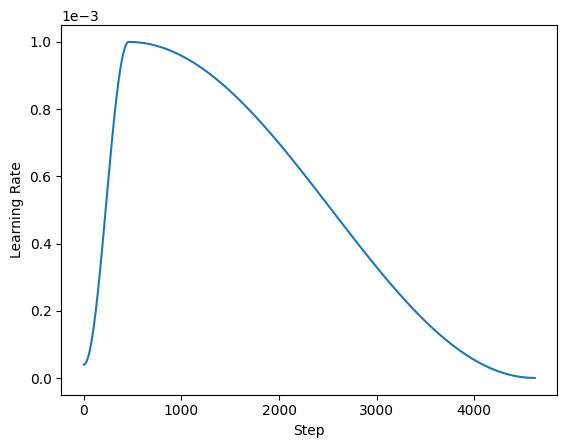

In [29]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = config.EPOCHS
BATCHES = len(train_loader)
steps = []
lrs = []
optim_lrs = []
model = CustomModel()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    epochs=config.EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.1,
    anneal_strategy="cos",
    final_div_factor=100,
)
for epoch in range(EPOCHS):
    for batch in range(BATCHES):
        scheduler.step()
        lrs.append(scheduler.get_last_lr()[0])
        steps.append(epoch * BATCHES + batch)

max_lr = max(lrs)
min_lr = min(lrs)
print(f"Maximum LR: {max_lr} | Minimum LR: {min_lr}")
plt.figure()
plt.plot(steps, lrs, label='OneCycle')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.show()

# <b><span style='color:#F1A424'>|</span> Loss Function</b><a class='anchor' id='loss'></a> [↑](#top) 

***

In PyTorch's [KLDivLoss][1], the reduction parameter determines how the loss is aggregated across different dimensions. Two common options are `mean` and `batchmean`.

- `reduction`='mean': When reduction is set to "mean", the Kullback-Leibler Divergence loss is computed and then averaged over all the elements in the input tensor. The result is a scalar value representing the mean loss.
- `reduction`='batchmean': When reduction is set to "batchmean", the Kullback-Leibler Divergence loss is computed independently for each item in the batch, and then the mean is taken over the batch dimension. This is useful when you have a batch of samples, and you want the average loss per sample.

[1]: https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html


In [30]:
import torch.nn.functional as F

# === Reduction = "mean" ===
criterion = nn.KLDivLoss(reduction="mean")
y_pred = F.log_softmax(torch.randn(6, 2, requires_grad=True), dim=1)
y_true = F.softmax(torch.rand(6, 2), dim=1)
print(f"Predictions: {y_pred}")
print(f"Targets: {y_true}")
output = criterion(y_pred, y_true)
print(f"Output: {output}")

print("\n", "="*100, "\n")

# === Reduction = "batchmean" ===
criterion = nn.KLDivLoss(reduction="batchmean")
y_pred = F.log_softmax(torch.randn(2, 6, requires_grad=True), dim=1)
y_true = F.softmax(torch.rand(2, 6), dim=1)
print(f"Predictions: {y_pred}")
print(f"Targets: {y_true}")
output = criterion(y_pred, y_true)
print(f"Output: {output}")

Predictions: tensor([[-1.9961, -0.1460],
        [-0.6342, -0.7558],
        [-0.1321, -2.0893],
        [-1.0250, -0.4444],
        [-0.0433, -3.1617],
        [-0.5851, -0.8143]], grad_fn=<LogSoftmaxBackward0>)
Targets: tensor([[0.6694, 0.3306],
        [0.5824, 0.4176],
        [0.4294, 0.5706],
        [0.4837, 0.5163],
        [0.5527, 0.4473],
        [0.6195, 0.3805]])
Output: 0.17602171003818512


Predictions: tensor([[-3.2207, -3.4320, -0.7522, -2.0491, -2.5421, -1.3909],
        [-2.4079, -0.5832, -2.0969, -2.5690, -2.4326, -2.7393]],
       grad_fn=<LogSoftmaxBackward0>)
Targets: tensor([[0.1297, 0.2025, 0.2256, 0.1073, 0.1049, 0.2300],
        [0.1990, 0.1291, 0.1577, 0.2164, 0.1257, 0.1722]])
Output: 0.3986283838748932


/home/mccruz/.local/lib/python3.10/site-packages/torch/nn/functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


# <b><span style='color:#F1A424'>|</span> Train and Validation Functions</b><a class='anchor' id='functions'></a> [↑](#top) 

***

In [31]:
def train_epoch(train_loader, model, optimizer, epoch, scheduler, device):
    """One epoch training pass."""
    model.train()
    criterion = nn.KLDivLoss(reduction="batchmean")
    scaler = torch.cuda.amp.GradScaler(enabled=config.AMP)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    
    # ========== ITERATE OVER TRAIN BATCHES ============
    with tqdm(train_loader, unit="train_batch", desc='Train') as tqdm_train_loader:
        for step, batch in enumerate(tqdm_train_loader):
            X = batch.pop("X").to(device) # send inputs to `device`
            y = batch.pop("y").to(device) # send labels to `device`
            batch_size = y.size(0)
            with torch.cuda.amp.autocast(enabled=config.AMP):
                y_preds = model(X)
                loss = criterion(F.log_softmax(y_preds, dim=1), y)
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size)
            scaler.scale(loss).backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.MAX_GRAD_NORM)
            
            if (step + 1) % config.GRADIENT_ACCUMULATION_STEPS == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                global_step += 1
                scheduler.step()
            end = time.time()

            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(train_loader)-1):
                print('Epoch: [{0}][{1}/{2}] '
                      'Elapsed {remain:s} '
                      'Loss: {loss.avg:.4f} '
                      'Grad: {grad_norm:.4f}  '
                      'LR: {lr:.8f}  '
                      .format(epoch+1, step, len(train_loader), 
                              remain=timeSince(start, float(step+1)/len(train_loader)),
                              loss=losses,
                              grad_norm=grad_norm,
                              lr=scheduler.get_last_lr()[0]))

    return losses.avg


def valid_epoch(valid_loader, model, device):
    model.eval() 
    softmax = nn.Softmax(dim=1)
    losses = AverageMeter()
    prediction_dict = {}
    preds = []
    start = end = time.time()
    with tqdm(valid_loader, unit="valid_batch", desc='Validation') as tqdm_valid_loader:
        for step, batch in enumerate(tqdm_valid_loader):
            X = batch.pop("X").to(device) 
            y = batch.pop("y").to(device)
            batch_size = y.size(0)
            with torch.no_grad():
                y_preds = model(X)
                loss = criterion(F.log_softmax(y_preds, dim=1), y)
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size)
            y_preds = softmax(y_preds)
            preds.append(y_preds.to('cpu').numpy()) 
            end = time.time()

            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                      'Elapsed {remain:s} '
                      'Loss: {loss.avg:.4f} '
                      .format(step, len(valid_loader),
                              remain=timeSince(start, float(step+1)/len(valid_loader)),
                              loss=losses))
                
    prediction_dict["predictions"] = np.concatenate(preds)
    return losses.avg, prediction_dict

# <b><span style='color:#F1A424'>|</span> Train Loop</b><a class='anchor' id='train_loop'></a> [↑](#top) 

***

In [35]:
def train_loop(df, fold):
    
    #LOGGER.info(f"========== Fold: {fold} training ==========")
    print((f"========== Fold: {fold} training =========="))

    # ======== SPLIT ==========
    train_folds = df[df['fold'] != fold].reset_index(drop=True)
    valid_folds = df[df['fold'] == fold].reset_index(drop=True)
    
    # ======== DATASETS ==========
    train_dataset = CustomDataset(train_folds, config, mode="train")
    valid_dataset = CustomDataset(valid_folds, config, mode="train")
    
    # ======== DATALOADERS ==========
    train_loader = DataLoader(train_dataset,
                              batch_size=config.BATCH_SIZE_TRAIN,
                              shuffle=True,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=config.BATCH_SIZE_VALID,
                              shuffle=False,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False)
    
    # ======== MODEL ==========
    model = CustomModel()
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.1, weight_decay=config.WEIGHT_DECAY)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-3,
        epochs=config.EPOCHS,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,
        anneal_strategy="cos",
        final_div_factor=100,
    )

    # ======= LOSS ==========
    criterion = nn.KLDivLoss(reduction="batchmean")
    
    best_loss = np.inf
    # ====== ITERATE EPOCHS ========
    for epoch in range(config.EPOCHS):
        start_time = time.time()

        # ======= TRAIN ==========
        avg_train_loss = train_epoch(train_loader, model, optimizer, epoch, scheduler, device)

        # ======= EVALUATION ==========
        avg_val_loss, prediction_dict = valid_epoch(valid_loader, model, device)
        predictions = prediction_dict["predictions"]
        
        # ======= SCORING ==========
        elapsed = time.time() - start_time

        #LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_train_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        print(f'Epoch {epoch+1} - avg_train_loss: {avg_train_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            #LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            print(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                         f"models/wavenet_fold_{fold}_best.pth")

    predictions = torch.load(f"models/wavenet_fold_{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds[target_preds] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [35]:
def train_loop(df, fold, prevmodel = None):
    
    #LOGGER.info(f"========== Fold: {fold} training ==========")
    print((f"========== Fold: {fold} training =========="))

    # ======== SPLIT ==========
    train_folds = df[df['fold'] != fold].reset_index(drop=True)
    valid_folds = df[df['fold'] == fold].reset_index(drop=True)
    
    # ======== DATASETS ==========
    train_dataset = CustomDataset(train_folds, config, mode="train")
    valid_dataset = CustomDataset(valid_folds, config, mode="train")
    
    # ======== DATALOADERS ==========
    train_loader = DataLoader(train_dataset,
                              batch_size=config.BATCH_SIZE_TRAIN,
                              shuffle=True,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=config.BATCH_SIZE_VALID,
                              shuffle=False,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False)
    
    # ======== MODEL ==========
    model = CustomModel()
    model.to(device)
    model.load_state_dict(torch.load(prevmodel)['model'])
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.1, weight_decay=config.WEIGHT_DECAY)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-3,
        epochs=config.EPOCHS,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,
        anneal_strategy="cos",
        final_div_factor=100,
    )

    # ======= LOSS ==========
    criterion = nn.KLDivLoss(reduction="batchmean")
    
    best_loss = np.inf
    # ====== ITERATE EPOCHS ========
    for epoch in range(config.EPOCHS):
        start_time = time.time()

        # ======= TRAIN ==========
        avg_train_loss = train_epoch(train_loader, model, optimizer, epoch, scheduler, device)

        # ======= EVALUATION ==========
        avg_val_loss, prediction_dict = valid_epoch(valid_loader, model, device)
        predictions = prediction_dict["predictions"]
        
        # ======= SCORING ==========
        elapsed = time.time() - start_time

        #LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_train_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        print(f'Epoch {epoch+1} - avg_train_loss: {avg_train_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            #LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            print(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                         f"models/wavenet_fold_{fold}_best.pth")

    predictions = torch.load(f"models/wavenet_fold_{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds[target_preds] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [38]:
ls models

oof_df.csv               wavenet_fold_1_best.pth  wavenet_fold_3_best.pth
wavenet_fold_0_best.pth  wavenet_fold_2_best.pth  wavenet_fold_4_best.pth


In [43]:
torch.load("models/wavenet_fold_0_best.pth")['model']

OrderedDict([('model.model.0.convs.0.weight',
              tensor([[[ 0.8831]],
              
                      [[ 0.8820]],
              
                      [[ 0.2468]],
              
                      [[ 0.3396]],
              
                      [[-0.9065]],
              
                      [[ 0.8352]],
              
                      [[ 0.4661]],
              
                      [[-0.1073]]], device='cuda:0')),
             ('model.model.0.convs.0.bias',
              tensor([ 2.0328e-03, -3.6382e-04, -1.3411e-03,  2.7734e-03,  2.4641e-04,
                       1.1829e-04, -1.2911e-05, -2.0615e-04], device='cuda:0')),
             ('model.model.0.convs.1.weight',
              tensor([[[-0.3142],
                       [ 0.2086],
                       [ 0.0249],
                       [ 0.4171],
                       [ 0.2613],
                       [ 0.0175],
                       [-0.7552],
                       [-0.7391]],
              
   

# <b><span style='color:#F1A424'>|</span> Train</b><a class='anchor' id='train'></a> [↑](#top) 

***

In [36]:
def get_result(oof_df):
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    labels = torch.tensor(oof_df[label_cols].values)
    preds = torch.tensor(oof_df[target_preds].values)
    preds = F.log_softmax(preds, dim=1)
    result = kl_loss(preds, labels)
    return result

if not config.TRAIN_FULL_DATA:
    oof_df = pd.DataFrame()
    for fold in range(config.FOLDS):
        if fold in [0, 1, 2, 3, 4]:
            _oof_df = train_loop(train_df, fold,f"models/wavenet_fold_{fold}_best.pth")
            oof_df = pd.concat([oof_df, _oof_df])
            #LOGGER.info(f"========== Fold {fold} finished ==========")
    oof_df = oof_df.reset_index(drop=True)
    oof_df.to_csv('models/oof_df.csv', index=False)
else:
    train_loop_full_data(train_df)

========== Fold: 0 training ==========


Train:   1%|          | 1/116 [00:23<44:24, 23.17s/train_batch]

Epoch: [1][0/116] Elapsed 0m 23s (remain 44m 24s) Loss: 0.2196 Grad: 195703.3594  LR: 0.00004002  


Train:  18%|█▊        | 21/116 [00:30<00:36,  2.60train_batch/s]

Epoch: [1][20/116] Elapsed 0m 30s (remain 2m 19s) Loss: 0.1721 Grad: 116921.0078  LR: 0.00004865  


Train:  35%|███▌      | 41/116 [00:38<00:27,  2.69train_batch/s]

Epoch: [1][40/116] Elapsed 0m 38s (remain 1m 9s) Loss: 0.1748 Grad: 148673.6875  LR: 0.00007269  


Train:  53%|█████▎    | 61/116 [00:45<00:20,  2.67train_batch/s]

Epoch: [1][60/116] Elapsed 0m 45s (remain 0m 41s) Loss: 0.1724 Grad: 103967.8984  LR: 0.00011136  


Train:  70%|██████▉   | 81/116 [00:53<00:13,  2.66train_batch/s]

Epoch: [1][80/116] Elapsed 0m 53s (remain 0m 22s) Loss: 0.1678 Grad: 126677.4688  LR: 0.00016339  


Train:  87%|████████▋ | 101/116 [01:00<00:05,  2.62train_batch/s]

Epoch: [1][100/116] Elapsed 1m 0s (remain 0m 9s) Loss: 0.1614 Grad: 95160.9375  LR: 0.00022708  


Train: 100%|██████████| 116/116 [01:06<00:00,  1.74train_batch/s]


Epoch: [1][115/116] Elapsed 1m 6s (remain 0m 0s) Loss: 0.1578 Grad: 63610.8125  LR: 0.00028126  


Validation:   3%|▎         | 1/39 [00:02<01:18,  2.07s/valid_batch]

EVAL: [0/39] Elapsed 0m 2s (remain 1m 18s) Loss: 1.0853 


Validation:  54%|█████▍    | 21/39 [00:07<00:04,  3.87valid_batch/s]

EVAL: [20/39] Elapsed 0m 7s (remain 0m 6s) Loss: 2.9173 


Validation: 100%|██████████| 39/39 [00:12<00:00,  3.21valid_batch/s]


EVAL: [38/39] Elapsed 0m 12s (remain 0m 0s) Loss: 2.5091 
Epoch 1 - avg_train_loss: 0.1578  avg_val_loss: 2.5091  time: 79s
Epoch 1 - Save Best Loss: 2.5091 Model


Train:   1%|          | 1/116 [00:00<00:42,  2.73train_batch/s]

Epoch: [2][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.1000 Grad: 83876.7578  LR: 0.00028504  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.71train_batch/s]

Epoch: [2][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.1238 Grad: 102204.1641  LR: 0.00036425  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.74train_batch/s]

Epoch: [4][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.1817 Grad: 72021.6172  LR: 0.00099988  


Train:  35%|███▌      | 41/116 [00:14<00:27,  2.73train_batch/s]

Epoch: [4][40/116] Elapsed 0m 14s (remain 0m 27s) Loss: 0.1771 Grad: 66605.9766  LR: 0.00099956  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.72train_batch/s]

Epoch: [4][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1830 Grad: 84359.3281  LR: 0.00099903  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.71train_batch/s]

Epoch: [4][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.1828 Grad: 102020.3672  LR: 0.00099831  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.69train_batch/s]

Epoch: [4][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1852 Grad: 72667.5859  LR: 0.00099739  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.72train_batch/s]


Epoch: [4][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.1844 Grad: 59378.1641  LR: 0.00099656  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.4194 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.93valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.4769 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.94valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.2749 
Epoch 4 - avg_train_loss: 0.1844  avg_val_loss: 2.2749  time: 53s
Epoch 4 - Save Best Loss: 2.2749 Model


Train:   1%|          | 1/116 [00:00<00:42,  2.69train_batch/s]

Epoch: [5][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.2140 Grad: 214317.8750  LR: 0.00099650  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.65train_batch/s]

Epoch: [5][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1539 Grad: 104546.5625  LR: 0.00099522  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.65train_batch/s]

Epoch: [5][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.1445 Grad: 159648.7344  LR: 0.00099374  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.66train_batch/s]

Epoch: [5][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1522 Grad: 110132.0859  LR: 0.00099205  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.67train_batch/s]

Epoch: [5][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1612 Grad: 29040.4570  LR: 0.00099018  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [5][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1646 Grad: 63344.6289  LR: 0.00098810  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.66train_batch/s]


Epoch: [5][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1688 Grad: 32617.8516  LR: 0.00098641  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.11valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.3092 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.07valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.5520 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.12valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.3837 
Epoch 5 - avg_train_loss: 0.1688  avg_val_loss: 2.3837  time: 53s


Train:   1%|          | 1/116 [00:00<00:41,  2.77train_batch/s]

Epoch: [6][0/116] Elapsed 0m 0s (remain 0m 41s) Loss: 0.1479 Grad: 127091.0859  LR: 0.00098630  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.74train_batch/s]

Epoch: [6][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.1592 Grad: 112642.0703  LR: 0.00098387  


Train:  35%|███▌      | 41/116 [00:14<00:27,  2.72train_batch/s]

Epoch: [6][40/116] Elapsed 0m 14s (remain 0m 27s) Loss: 0.1517 Grad: 120495.0859  LR: 0.00098124  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.64train_batch/s]

Epoch: [6][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1523 Grad: 156441.3125  LR: 0.00097842  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.68train_batch/s]

Epoch: [6][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1464 Grad: 106629.3125  LR: 0.00097541  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [6][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1481 Grad: 59796.8477  LR: 0.00097221  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [6][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1497 Grad: 71674.5156  LR: 0.00096969  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.05valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.0971 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.02valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.5894 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.04valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 3.0089 
Epoch 6 - avg_train_loss: 0.1497  avg_val_loss: 3.0089  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.71train_batch/s]

Epoch: [7][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.1662 Grad: 138755.5000  LR: 0.00096951  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.70train_batch/s]

Epoch: [7][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1437 Grad: 71405.0078  LR: 0.00096597  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.70train_batch/s]

Epoch: [7][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1577 Grad: 27449.1836  LR: 0.00096224  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.70train_batch/s]

Epoch: [7][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1622 Grad: 23665.0137  LR: 0.00095833  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.71train_batch/s]

Epoch: [7][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.1532 Grad: 54308.5664  LR: 0.00095423  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.70train_batch/s]

Epoch: [7][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1485 Grad: 48890.5664  LR: 0.00094994  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.70train_batch/s]


Epoch: [7][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.1460 Grad: 33728.6211  LR: 0.00094661  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.2810 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.88valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 4.1977 


Validation: 100%|██████████| 39/39 [00:10<00:00,  3.83valid_batch/s]


EVAL: [38/39] Elapsed 0m 10s (remain 0m 0s) Loss: 3.4266 
Epoch 7 - avg_train_loss: 0.1460  avg_val_loss: 3.4266  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.71train_batch/s]

Epoch: [8][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.1465 Grad: 167044.1875  LR: 0.00094639  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.67train_batch/s]

Epoch: [8][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1171 Grad: 84264.3359  LR: 0.00094178  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.66train_batch/s]

Epoch: [8][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.1252 Grad: 102731.8125  LR: 0.00093699  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.63train_batch/s]

Epoch: [8][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1302 Grad: 148524.5938  LR: 0.00093203  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.63train_batch/s]

Epoch: [8][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1289 Grad: 84542.7031  LR: 0.00092690  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.64train_batch/s]

Epoch: [8][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.1323 Grad: 64132.8945  LR: 0.00092159  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.65train_batch/s]


Epoch: [8][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1321 Grad: 47581.6484  LR: 0.00091750  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.24valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.2043 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.21valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 2.4124 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.24valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.2531 
Epoch 8 - avg_train_loss: 0.1321  avg_val_loss: 2.2531  time: 53s
Epoch 8 - Save Best Loss: 2.2531 Model


Train:   1%|          | 1/116 [00:00<00:41,  2.76train_batch/s]

Epoch: [9][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.1467 Grad: 132723.8125  LR: 0.00091722  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.74train_batch/s]

Epoch: [9][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.1012 Grad: 90171.5859  LR: 0.00091161  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.73train_batch/s]

Epoch: [9][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1098 Grad: 134420.9219  LR: 0.00090584  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.72train_batch/s]

Epoch: [9][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1128 Grad: 139627.3750  LR: 0.00089990  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.70train_batch/s]

Epoch: [9][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.1100 Grad: 103080.1641  LR: 0.00089380  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.68train_batch/s]

Epoch: [9][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1099 Grad: 68638.9219  LR: 0.00088754  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.71train_batch/s]


Epoch: [9][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.1126 Grad: 170706.8281  LR: 0.00088275  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.89valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.5720 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.6245 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.4132 
Epoch 9 - avg_train_loss: 0.1126  avg_val_loss: 2.4132  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.69train_batch/s]

Epoch: [10][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.1936 Grad: 178561.6406  LR: 0.00088242  


Train:  18%|█▊        | 21/116 [00:08<00:37,  2.52train_batch/s]

Epoch: [10][20/116] Elapsed 0m 8s (remain 0m 36s) Loss: 0.1218 Grad: 106401.4062  LR: 0.00087589  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [10][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.1238 Grad: 61349.5938  LR: 0.00086920  


Train:  53%|█████▎    | 61/116 [00:23<00:20,  2.67train_batch/s]

Epoch: [10][60/116] Elapsed 0m 23s (remain 0m 20s) Loss: 0.1263 Grad: 23573.0488  LR: 0.00086236  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.67train_batch/s]

Epoch: [10][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1282 Grad: 47200.1367  LR: 0.00085538  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.66train_batch/s]

Epoch: [10][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.1230 Grad: 18345.5293  LR: 0.00084825  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.65train_batch/s]


Epoch: [10][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1225 Grad: 35926.6250  LR: 0.00084282  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.88valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.9846 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.89valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.8133 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.91valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.4562 
Epoch 10 - avg_train_loss: 0.1225  avg_val_loss: 2.4562  time: 54s


Train:   1%|          | 1/116 [00:00<00:42,  2.73train_batch/s]

Epoch: [11][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0876 Grad: 95709.6016  LR: 0.00084245  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.72train_batch/s]

Epoch: [11][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0890 Grad: 75941.6875  LR: 0.00083508  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.68train_batch/s]

Epoch: [11][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0943 Grad: 131368.1719  LR: 0.00082757  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.66train_batch/s]

Epoch: [11][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0954 Grad: 85507.7969  LR: 0.00081993  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.65train_batch/s]

Epoch: [11][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0992 Grad: 59255.1602  LR: 0.00081216  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.63train_batch/s]

Epoch: [11][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1008 Grad: 49447.1680  LR: 0.00080426  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.67train_batch/s]


Epoch: [11][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1024 Grad: 30212.4023  LR: 0.00079826  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.19valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.0894 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.18valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.1581 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.23valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.7498 
Epoch 11 - avg_train_loss: 0.1024  avg_val_loss: 2.7498  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.73train_batch/s]

Epoch: [12][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.1187 Grad: 122271.6406  LR: 0.00079786  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.70train_batch/s]

Epoch: [12][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.1083 Grad: 101573.2812  LR: 0.00078974  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.71train_batch/s]

Epoch: [12][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1036 Grad: 54621.8711  LR: 0.00078151  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.65train_batch/s]

Epoch: [12][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1011 Grad: 94592.2109  LR: 0.00077317  


Train:  70%|██████▉   | 81/116 [00:30<00:12,  2.70train_batch/s]

Epoch: [12][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1005 Grad: 34453.8672  LR: 0.00076471  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.69train_batch/s]

Epoch: [12][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0990 Grad: 55611.0117  LR: 0.00075615  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [12][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0989 Grad: 35511.9648  LR: 0.00074967  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.91valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.2949 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.90valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.3027 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.92valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.9596 
Epoch 12 - avg_train_loss: 0.0989  avg_val_loss: 2.9596  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.68train_batch/s]

Epoch: [13][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.1408 Grad: 131642.6719  LR: 0.00074923  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.66train_batch/s]

Epoch: [13][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1045 Grad: 191661.8750  LR: 0.00074049  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.63train_batch/s]

Epoch: [13][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0958 Grad: 169944.3281  LR: 0.00073165  


Train:  53%|█████▎    | 61/116 [00:23<00:20,  2.64train_batch/s]

Epoch: [13][60/116] Elapsed 0m 23s (remain 0m 20s) Loss: 0.0923 Grad: 91989.5547  LR: 0.00072272  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.63train_batch/s]

Epoch: [13][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0920 Grad: 115634.2500  LR: 0.00071369  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.63train_batch/s]

Epoch: [13][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0916 Grad: 59371.7422  LR: 0.00070459  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.64train_batch/s]


Epoch: [13][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0929 Grad: 66468.3828  LR: 0.00069770  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.21valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.2189 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.19valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.8454 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.22valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.5704 
Epoch 13 - avg_train_loss: 0.0929  avg_val_loss: 2.5704  time: 53s


Train:   1%|          | 1/116 [00:00<00:41,  2.75train_batch/s]

Epoch: [14][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0732 Grad: 82836.2969  LR: 0.00069724  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.74train_batch/s]

Epoch: [14][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0864 Grad: 84942.0703  LR: 0.00068799  


Train:  35%|███▌      | 41/116 [00:14<00:27,  2.72train_batch/s]

Epoch: [14][40/116] Elapsed 0m 14s (remain 0m 27s) Loss: 0.0868 Grad: 70472.1016  LR: 0.00067866  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.71train_batch/s]

Epoch: [14][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0840 Grad: 66916.8906  LR: 0.00066926  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.70train_batch/s]

Epoch: [14][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0828 Grad: 60305.4375  LR: 0.00065979  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.64train_batch/s]

Epoch: [14][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0841 Grad: 76584.1562  LR: 0.00065025  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.70train_batch/s]


Epoch: [14][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0837 Grad: 38053.0352  LR: 0.00064306  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.91valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.1106 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.90valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.3347 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.92valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.8982 
Epoch 14 - avg_train_loss: 0.0837  avg_val_loss: 2.8982  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.68train_batch/s]

Epoch: [15][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0676 Grad: 83766.6094  LR: 0.00064258  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.67train_batch/s]

Epoch: [15][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0826 Grad: 59195.3281  LR: 0.00063294  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [15][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0770 Grad: 72309.3672  LR: 0.00062325  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.67train_batch/s]

Epoch: [15][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0760 Grad: 85397.0547  LR: 0.00061351  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.67train_batch/s]

Epoch: [15][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0768 Grad: 114440.6094  LR: 0.00060372  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [15][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0756 Grad: 80759.3281  LR: 0.00059389  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.67train_batch/s]


Epoch: [15][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0757 Grad: 55944.4062  LR: 0.00058650  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.90valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.1718 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.88valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.0690 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.91valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.7435 
Epoch 15 - avg_train_loss: 0.0757  avg_val_loss: 2.7435  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.70train_batch/s]

Epoch: [16][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0682 Grad: 72444.6562  LR: 0.00058600  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.70train_batch/s]

Epoch: [16][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0669 Grad: 69184.1094  LR: 0.00057611  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [16][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0649 Grad: 62334.9570  LR: 0.00056618  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.67train_batch/s]

Epoch: [16][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0689 Grad: 75531.0156  LR: 0.00055623  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.61train_batch/s]

Epoch: [16][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0709 Grad: 29364.6934  LR: 0.00054626  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.63train_batch/s]

Epoch: [16][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0696 Grad: 28608.0195  LR: 0.00053626  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.66train_batch/s]


Epoch: [16][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0689 Grad: 27291.4277  LR: 0.00052876  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.21valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.2039 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.96valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.0743 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.14valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.7748 
Epoch 16 - avg_train_loss: 0.0689  avg_val_loss: 2.7748  time: 53s


Train:   1%|          | 1/116 [00:00<00:41,  2.74train_batch/s]

Epoch: [17][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0782 Grad: 85631.5234  LR: 0.00052826  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.73train_batch/s]

Epoch: [17][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0573 Grad: 26584.1465  LR: 0.00051824  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.71train_batch/s]

Epoch: [17][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0573 Grad: 46002.7812  LR: 0.00050822  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.72train_batch/s]

Epoch: [17][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0592 Grad: 66462.6172  LR: 0.00049819  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.71train_batch/s]

Epoch: [17][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0601 Grad: 43442.0820  LR: 0.00048817  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.68train_batch/s]

Epoch: [17][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0650 Grad: 89564.1875  LR: 0.00047815  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.71train_batch/s]


Epoch: [17][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.0668 Grad: 55392.8555  LR: 0.00047064  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.87valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.0392 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.90valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.8966 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.92valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.6944 
Epoch 17 - avg_train_loss: 0.0668  avg_val_loss: 2.6944  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.68train_batch/s]

Epoch: [18][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0597 Grad: 84301.7656  LR: 0.00047014  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.66train_batch/s]

Epoch: [18][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0614 Grad: 72569.3359  LR: 0.00046014  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.65train_batch/s]

Epoch: [18][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0654 Grad: 180049.1562  LR: 0.00045015  


Train:  53%|█████▎    | 61/116 [00:23<00:20,  2.64train_batch/s]

Epoch: [18][60/116] Elapsed 0m 23s (remain 0m 20s) Loss: 0.0684 Grad: 137582.8750  LR: 0.00044019  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.66train_batch/s]

Epoch: [18][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0660 Grad: 67453.3672  LR: 0.00043024  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.63train_batch/s]

Epoch: [18][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0659 Grad: 97071.7969  LR: 0.00042033  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.65train_batch/s]


Epoch: [18][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0648 Grad: 92308.8516  LR: 0.00041292  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.23valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.2433 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.16valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.4940 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.23valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 3.0344 
Epoch 18 - avg_train_loss: 0.0648  avg_val_loss: 3.0344  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.73train_batch/s]

Epoch: [19][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0404 Grad: 54280.5781  LR: 0.00041242  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.75train_batch/s]

Epoch: [19][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0561 Grad: 56329.8867  LR: 0.00040257  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.73train_batch/s]

Epoch: [19][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0558 Grad: 82750.4219  LR: 0.00039276  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.72train_batch/s]

Epoch: [19][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0560 Grad: 150414.6250  LR: 0.00038299  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.68train_batch/s]

Epoch: [19][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0566 Grad: 93012.7734  LR: 0.00037327  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [19][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0581 Grad: 26076.0781  LR: 0.00036359  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [19][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0569 Grad: 34130.7148  LR: 0.00035638  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.90valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.4339 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.90valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.4252 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.93valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 3.1298 
Epoch 19 - avg_train_loss: 0.0569  avg_val_loss: 3.1298  time: 53s


Train:   1%|          | 1/116 [00:00<00:43,  2.67train_batch/s]

Epoch: [20][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0575 Grad: 139743.9062  LR: 0.00035590  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.69train_batch/s]

Epoch: [20][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0534 Grad: 72507.6797  LR: 0.00034633  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.68train_batch/s]

Epoch: [20][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0515 Grad: 71749.6719  LR: 0.00033682  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.67train_batch/s]

Epoch: [20][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0533 Grad: 172144.5312  LR: 0.00032738  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.68train_batch/s]

Epoch: [20][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0524 Grad: 57061.0508  LR: 0.00031800  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [20][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0541 Grad: 31989.8848  LR: 0.00030870  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [20][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0559 Grad: 66818.6250  LR: 0.00030178  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.91valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.0483 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.89valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.2288 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.91valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.8176 
Epoch 20 - avg_train_loss: 0.0559  avg_val_loss: 2.8176  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.72train_batch/s]

Epoch: [21][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0567 Grad: 86132.7578  LR: 0.00030132  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.69train_batch/s]

Epoch: [21][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0485 Grad: 81125.5703  LR: 0.00029216  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.66train_batch/s]

Epoch: [21][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0482 Grad: 76871.7969  LR: 0.00028309  


Train:  53%|█████▎    | 61/116 [00:23<00:23,  2.34train_batch/s]

Epoch: [21][60/116] Elapsed 0m 23s (remain 0m 20s) Loss: 0.0514 Grad: 51912.5039  LR: 0.00027410  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.63train_batch/s]

Epoch: [21][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0502 Grad: 74887.3516  LR: 0.00026520  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.63train_batch/s]

Epoch: [21][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0494 Grad: 49887.9883  LR: 0.00025640  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.64train_batch/s]


Epoch: [21][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0500 Grad: 65359.3281  LR: 0.00024987  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.22valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.9969 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.20valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.2114 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.24valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.8396 
Epoch 21 - avg_train_loss: 0.0500  avg_val_loss: 2.8396  time: 53s


Train:   1%|          | 1/116 [00:00<00:41,  2.74train_batch/s]

Epoch: [22][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0359 Grad: 53624.4141  LR: 0.00024943  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.74train_batch/s]

Epoch: [22][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0429 Grad: 86712.1719  LR: 0.00024081  


Train:  35%|███▌      | 41/116 [00:14<00:27,  2.74train_batch/s]

Epoch: [22][40/116] Elapsed 0m 14s (remain 0m 27s) Loss: 0.0422 Grad: 59375.6641  LR: 0.00023229  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.72train_batch/s]

Epoch: [22][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0434 Grad: 49780.8359  LR: 0.00022388  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.71train_batch/s]

Epoch: [22][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0446 Grad: 31063.0723  LR: 0.00021558  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.69train_batch/s]

Epoch: [22][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0452 Grad: 26392.2266  LR: 0.00020740  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.71train_batch/s]


Epoch: [22][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.0449 Grad: 24763.1152  LR: 0.00020134  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.2015 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.91valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.2132 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.94valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.8429 
Epoch 22 - avg_train_loss: 0.0449  avg_val_loss: 2.8429  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.69train_batch/s]

Epoch: [23][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0660 Grad: 96810.0469  LR: 0.00020094  


Train:  18%|█▊        | 21/116 [00:08<00:35,  2.64train_batch/s]

Epoch: [23][20/116] Elapsed 0m 8s (remain 0m 36s) Loss: 0.0463 Grad: 32263.6289  LR: 0.00019297  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.65train_batch/s]

Epoch: [23][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0437 Grad: 19938.6328  LR: 0.00018512  


Train:  53%|█████▎    | 61/116 [00:23<00:20,  2.65train_batch/s]

Epoch: [23][60/116] Elapsed 0m 23s (remain 0m 20s) Loss: 0.0439 Grad: 29956.0488  LR: 0.00017740  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.65train_batch/s]

Epoch: [23][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0427 Grad: 36411.1406  LR: 0.00016981  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.53train_batch/s]

Epoch: [23][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0421 Grad: 37647.1328  LR: 0.00016236  


Train: 100%|██████████| 116/116 [00:44<00:00,  2.63train_batch/s]


Epoch: [23][115/116] Elapsed 0m 44s (remain 0m 0s) Loss: 0.0421 Grad: 24828.7207  LR: 0.00015685  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.96valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.0466 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.88valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.2089 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.92valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.8548 
Epoch 23 - avg_train_loss: 0.0421  avg_val_loss: 2.8548  time: 54s


Train:   1%|          | 1/116 [00:00<00:41,  2.78train_batch/s]

Epoch: [24][0/116] Elapsed 0m 0s (remain 0m 41s) Loss: 0.0276 Grad: 43522.5703  LR: 0.00015649  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.74train_batch/s]

Epoch: [24][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0441 Grad: 61939.4297  LR: 0.00014928  


Train:  35%|███▌      | 41/116 [00:14<00:27,  2.71train_batch/s]

Epoch: [24][40/116] Elapsed 0m 14s (remain 0m 27s) Loss: 0.0388 Grad: 48829.3320  LR: 0.00014221  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.68train_batch/s]

Epoch: [24][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0391 Grad: 39736.0039  LR: 0.00013529  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.66train_batch/s]

Epoch: [24][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0422 Grad: 36362.5430  LR: 0.00012851  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.64train_batch/s]

Epoch: [24][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0420 Grad: 28742.5801  LR: 0.00012188  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [24][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0412 Grad: 27890.6289  LR: 0.00011701  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.10valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.1194 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.19valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.3286 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.22valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.9139 
Epoch 24 - avg_train_loss: 0.0412  avg_val_loss: 2.9139  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.70train_batch/s]

Epoch: [25][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0346 Grad: 51641.0938  LR: 0.00011669  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.70train_batch/s]

Epoch: [25][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0397 Grad: 50919.7695  LR: 0.00011034  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.71train_batch/s]

Epoch: [25][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0403 Grad: 32177.5273  LR: 0.00010414  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.66train_batch/s]

Epoch: [25][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0389 Grad: 31444.3359  LR: 0.00009810  


Train:  70%|██████▉   | 81/116 [00:30<00:12,  2.70train_batch/s]

Epoch: [25][80/116] Elapsed 0m 30s (remain 0m 12s) Loss: 0.0382 Grad: 34211.8086  LR: 0.00009223  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.69train_batch/s]

Epoch: [25][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0382 Grad: 27383.4316  LR: 0.00008652  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [25][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0387 Grad: 29262.5801  LR: 0.00008235  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.92valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.1159 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.90valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.4853 


Validation: 100%|██████████| 39/39 [00:10<00:00,  3.82valid_batch/s]


EVAL: [38/39] Elapsed 0m 10s (remain 0m 0s) Loss: 3.0661 
Epoch 25 - avg_train_loss: 0.0387  avg_val_loss: 3.0661  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.70train_batch/s]

Epoch: [26][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0381 Grad: 56543.4961  LR: 0.00008207  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.67train_batch/s]

Epoch: [26][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0394 Grad: 63151.4297  LR: 0.00007666  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.64train_batch/s]

Epoch: [26][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0397 Grad: 32369.0059  LR: 0.00007143  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.63train_batch/s]

Epoch: [26][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0387 Grad: 40988.1797  LR: 0.00006636  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.63train_batch/s]

Epoch: [26][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0380 Grad: 32905.5039  LR: 0.00006147  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.64train_batch/s]

Epoch: [26][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0373 Grad: 28964.1758  LR: 0.00005676  


Train:  97%|█████████▋| 112/116 [00:42<00:01,  2.63train_batch/s]

Epoch: [28][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0386 Grad: 60474.3516  LR: 0.00002688  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [28][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0362 Grad: 39364.5625  LR: 0.00002376  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.67train_batch/s]

Epoch: [28][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0379 Grad: 23613.5762  LR: 0.00002083  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.67train_batch/s]

Epoch: [28][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0363 Grad: 29760.1680  LR: 0.00001809  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [28][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0354 Grad: 20523.5430  LR: 0.00001554  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.67train_batch/s]


Epoch: [28][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0356 Grad: 40522.3047  LR: 0.00001376  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.86valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.1033 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.91valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.3912 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.94valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.9759 
Epoch 28 - avg_train_loss: 0.0356  avg_val_loss: 2.9759  time: 53s


Train:   1%|          | 1/116 [00:00<00:41,  2.74train_batch/s]

Epoch: [29][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0293 Grad: 48803.5742  LR: 0.00001364  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.72train_batch/s]

Epoch: [29][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0342 Grad: 60907.8711  LR: 0.00001145  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.70train_batch/s]

Epoch: [29][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0351 Grad: 55442.3555  LR: 0.00000945  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.67train_batch/s]

Epoch: [29][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0346 Grad: 52938.4766  LR: 0.00000765  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.66train_batch/s]

Epoch: [29][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0336 Grad: 77054.0547  LR: 0.00000605  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.65train_batch/s]

Epoch: [29][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0333 Grad: 40122.2070  LR: 0.00000464  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.67train_batch/s]


Epoch: [29][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0335 Grad: 23176.7500  LR: 0.00000372  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.20valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.0965 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.21valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.3568 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.24valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.9340 
Epoch 29 - avg_train_loss: 0.0335  avg_val_loss: 2.9340  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.73train_batch/s]

Epoch: [30][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0351 Grad: 53339.0312  LR: 0.00000366  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.73train_batch/s]

Epoch: [30][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0375 Grad: 21338.2734  LR: 0.00000262  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.73train_batch/s]

Epoch: [30][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0363 Grad: 22038.0781  LR: 0.00000178  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.71train_batch/s]

Epoch: [30][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0374 Grad: 24083.6348  LR: 0.00000113  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.72train_batch/s]

Epoch: [30][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0364 Grad: 33843.4336  LR: 0.00000069  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.70train_batch/s]

Epoch: [30][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0362 Grad: 31093.9551  LR: 0.00000045  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.71train_batch/s]


Epoch: [30][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.0357 Grad: 27623.8125  LR: 0.00000040  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.91valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.1322 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.90valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.4353 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.93valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 3.0100 
Epoch 30 - avg_train_loss: 0.0357  avg_val_loss: 3.0100  time: 53s
========== Fold: 1 training ==========


Train:   1%|          | 1/116 [00:00<00:44,  2.59train_batch/s]

Epoch: [1][0/116] Elapsed 0m 0s (remain 0m 44s) Loss: 0.6194 Grad: 186090.3906  LR: 0.00004002  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.69train_batch/s]

Epoch: [1][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.5754 Grad: 91733.5781  LR: 0.00004865  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.66train_batch/s]

Epoch: [1][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.5603 Grad: 79141.3906  LR: 0.00007269  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.67train_batch/s]

Epoch: [1][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.5584 Grad: 158064.1875  LR: 0.00011136  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.67train_batch/s]

Epoch: [1][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.5515 Grad: 84145.3672  LR: 0.00016339  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [1][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.5421 Grad: 91037.5234  LR: 0.00022708  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.67train_batch/s]


Epoch: [1][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.5439 Grad: 97405.7891  LR: 0.00028126  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.96valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5957 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.1803 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.96valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.1621 
Epoch 1 - avg_train_loss: 0.5439  avg_val_loss: 1.1621  time: 53s
Epoch 1 - Save Best Loss: 1.1621 Model


Train:   1%|          | 1/116 [00:00<00:41,  2.74train_batch/s]

Epoch: [2][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.6264 Grad: 303738.9062  LR: 0.00028504  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.71train_batch/s]

Epoch: [2][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.5324 Grad: 90788.2266  LR: 0.00036425  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.69train_batch/s]

Epoch: [2][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.5338 Grad: 115717.5781  LR: 0.00044856  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.70train_batch/s]

Epoch: [2][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.5466 Grad: 155189.1562  LR: 0.00053521  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.67train_batch/s]

Epoch: [2][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.5470 Grad: 114898.2344  LR: 0.00062136  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [2][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.5561 Grad: 107837.4609  LR: 0.00070419  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [2][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.5618 Grad: 133362.9062  LR: 0.00076250  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.94valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.7271 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.91valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.4977 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.93valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.4005 
Epoch 2 - avg_train_loss: 0.5618  avg_val_loss: 1.4005  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.70train_batch/s]

Epoch: [3][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.5144 Grad: 201173.8750  LR: 0.00076624  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.69train_batch/s]

Epoch: [3][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.5716 Grad: 149842.7188  LR: 0.00083642  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.69train_batch/s]

Epoch: [3][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.5830 Grad: 117609.3828  LR: 0.00089624  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.69train_batch/s]

Epoch: [3][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.5813 Grad: inf  LR: 0.00094377  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.68train_batch/s]

Epoch: [3][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.5669 Grad: 60840.7930  LR: 0.00097744  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.68train_batch/s]

Epoch: [3][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.5624 Grad: 46651.9023  LR: 0.00099615  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [3][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.5644 Grad: 55233.4648  LR: 0.00100000  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.16valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5973 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.17valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.4103 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.22valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.3180 
Epoch 3 - avg_train_loss: 0.5644  avg_val_loss: 1.3180  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.74train_batch/s]

Epoch: [4][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.5227 Grad: 167569.5156  LR: 0.00100000  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.70train_batch/s]

Epoch: [4][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.5344 Grad: 156674.1406  LR: 0.00099988  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.66train_batch/s]

Epoch: [4][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.5458 Grad: 103494.3359  LR: 0.00099956  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.65train_batch/s]

Epoch: [4][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.5435 Grad: 124595.7031  LR: 0.00099903  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.64train_batch/s]

Epoch: [4][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.5389 Grad: 122564.6484  LR: 0.00099831  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.63train_batch/s]

Epoch: [4][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.5371 Grad: 57925.1680  LR: 0.00099739  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.66train_batch/s]


Epoch: [4][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.5334 Grad: 101906.0703  LR: 0.00099656  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.91valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5151 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.90valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.3911 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.94valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.3169 
Epoch 4 - avg_train_loss: 0.5334  avg_val_loss: 1.3169  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.72train_batch/s]

Epoch: [5][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.3837 Grad: 117758.0703  LR: 0.00099650  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.72train_batch/s]

Epoch: [5][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.4715 Grad: 63896.9922  LR: 0.00099522  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.70train_batch/s]

Epoch: [5][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.4743 Grad: 78745.9688  LR: 0.00099374  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.68train_batch/s]

Epoch: [5][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.4774 Grad: 95186.1797  LR: 0.00099205  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.67train_batch/s]

Epoch: [5][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.4733 Grad: 67922.8516  LR: 0.00099018  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.68train_batch/s]

Epoch: [5][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.4744 Grad: 105626.6875  LR: 0.00098810  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [5][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.4703 Grad: 156261.9375  LR: 0.00098641  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.91valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6764 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.90valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.4807 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.93valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.4592 
Epoch 5 - avg_train_loss: 0.4703  avg_val_loss: 1.4592  time: 53s


Train:   1%|          | 1/116 [00:00<00:43,  2.65train_batch/s]

Epoch: [6][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.4623 Grad: 169749.7812  LR: 0.00098630  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.66train_batch/s]

Epoch: [6][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.4515 Grad: 308785.9062  LR: 0.00098387  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.66train_batch/s]

Epoch: [6][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.4489 Grad: 113644.6328  LR: 0.00098124  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.65train_batch/s]

Epoch: [6][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.4468 Grad: 78144.4766  LR: 0.00097842  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.65train_batch/s]

Epoch: [6][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.4402 Grad: 93246.5000  LR: 0.00097541  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.65train_batch/s]

Epoch: [6][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.4345 Grad: 69387.8047  LR: 0.00097221  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.65train_batch/s]


Epoch: [6][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.4392 Grad: 103361.5391  LR: 0.00096969  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.17valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4593 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.19valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.5849 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.21valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.6031 
Epoch 6 - avg_train_loss: 0.4392  avg_val_loss: 1.6031  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.73train_batch/s]

Epoch: [7][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.4983 Grad: 273400.5938  LR: 0.00096951  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.70train_batch/s]

Epoch: [7][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.4384 Grad: 214733.5156  LR: 0.00096597  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.71train_batch/s]

Epoch: [7][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.4211 Grad: 173318.7812  LR: 0.00096224  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.67train_batch/s]

Epoch: [7][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.4065 Grad: 106270.5547  LR: 0.00095833  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.66train_batch/s]

Epoch: [7][80/116] Elapsed 0m 30s (remain 0m 12s) Loss: 0.4021 Grad: 57825.3047  LR: 0.00095423  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.64train_batch/s]

Epoch: [7][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.3963 Grad: 83541.2891  LR: 0.00094994  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.64train_batch/s]


Epoch: [7][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.3930 Grad: 70104.2266  LR: 0.00094661  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.90valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.7646 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.89valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.4558 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.93valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.4413 
Epoch 7 - avg_train_loss: 0.3930  avg_val_loss: 1.4413  time: 54s


Train:   1%|          | 1/116 [00:00<00:42,  2.69train_batch/s]

Epoch: [8][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.3292 Grad: 184378.9219  LR: 0.00094639  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.70train_batch/s]

Epoch: [8][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.3550 Grad: 116041.5391  LR: 0.00094178  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.71train_batch/s]

Epoch: [8][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.3289 Grad: 90123.5234  LR: 0.00093699  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.70train_batch/s]

Epoch: [8][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.3280 Grad: 95732.6016  LR: 0.00093203  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.68train_batch/s]

Epoch: [8][80/116] Elapsed 0m 30s (remain 0m 12s) Loss: 0.3396 Grad: 74837.3438  LR: 0.00092690  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.63train_batch/s]

Epoch: [8][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.3393 Grad: 77042.4531  LR: 0.00092159  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [8][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.3420 Grad: 88804.2578  LR: 0.00091750  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.89valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4659 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.88valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.5526 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.93valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.5572 
Epoch 8 - avg_train_loss: 0.3420  avg_val_loss: 1.5572  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.74train_batch/s]

Epoch: [9][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.3041 Grad: 205818.8438  LR: 0.00091722  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.68train_batch/s]

Epoch: [9][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.3124 Grad: 71131.3203  LR: 0.00091161  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [9][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.3136 Grad: 78120.7891  LR: 0.00090584  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.64train_batch/s]

Epoch: [9][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.3165 Grad: 77367.7422  LR: 0.00089990  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.61train_batch/s]

Epoch: [9][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.3191 Grad: 123458.0703  LR: 0.00089380  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.63train_batch/s]

Epoch: [9][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.3164 Grad: 108859.1484  LR: 0.00088754  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.64train_batch/s]


Epoch: [9][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.3145 Grad: 73001.3984  LR: 0.00088275  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.22valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4307 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.19valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.6666 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.22valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.5963 
Epoch 9 - avg_train_loss: 0.3145  avg_val_loss: 1.5963  time: 53s


Train:   1%|          | 1/116 [00:00<00:41,  2.75train_batch/s]

Epoch: [10][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.2640 Grad: 222395.9375  LR: 0.00088242  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.73train_batch/s]

Epoch: [10][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.2938 Grad: 99107.6953  LR: 0.00087589  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.69train_batch/s]

Epoch: [10][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.2927 Grad: 71800.6016  LR: 0.00086920  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.69train_batch/s]

Epoch: [10][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.2804 Grad: 95525.0781  LR: 0.00086236  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.70train_batch/s]

Epoch: [10][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.2753 Grad: 66287.3281  LR: 0.00085538  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [10][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.2712 Grad: 119836.7422  LR: 0.00084825  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [10][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.2709 Grad: 72592.5234  LR: 0.00084282  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.90valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6537 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.89valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.8274 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.93valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8209 
Epoch 10 - avg_train_loss: 0.2709  avg_val_loss: 1.8209  time: 53s


Train:   1%|          | 1/116 [00:00<00:43,  2.66train_batch/s]

Epoch: [11][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.3578 Grad: 379059.1562  LR: 0.00084245  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.67train_batch/s]

Epoch: [11][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.2632 Grad: 93777.6875  LR: 0.00083508  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [11][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.2665 Grad: 91867.9766  LR: 0.00082757  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.67train_batch/s]

Epoch: [11][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.2731 Grad: 98292.5234  LR: 0.00081993  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.69train_batch/s]

Epoch: [11][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.2711 Grad: inf  LR: 0.00081216  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.68train_batch/s]

Epoch: [11][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.2636 Grad: 27491.2949  LR: 0.00080426  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [11][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.2671 Grad: 22798.4141  LR: 0.00079826  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.22valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5534 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.07valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.7632 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.09valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.7381 
Epoch 11 - avg_train_loss: 0.2671  avg_val_loss: 1.7381  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.72train_batch/s]

Epoch: [12][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.1781 Grad: 167436.4062  LR: 0.00079786  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.71train_batch/s]

Epoch: [12][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.2094 Grad: 280320.7500  LR: 0.00078974  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.70train_batch/s]

Epoch: [12][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.2169 Grad: 92240.3125  LR: 0.00078151  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.66train_batch/s]

Epoch: [12][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.2170 Grad: 84127.4062  LR: 0.00077317  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.65train_batch/s]

Epoch: [12][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.2258 Grad: 30251.8262  LR: 0.00076471  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.64train_batch/s]

Epoch: [12][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.2267 Grad: 36344.2578  LR: 0.00075615  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.67train_batch/s]


Epoch: [12][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.2260 Grad: 38626.7656  LR: 0.00074967  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.95valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5470 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.89valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.6557 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.94valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.6263 
Epoch 12 - avg_train_loss: 0.2260  avg_val_loss: 1.6263  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.71train_batch/s]

Epoch: [13][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.1901 Grad: 109776.1484  LR: 0.00074923  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.72train_batch/s]

Epoch: [13][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.2046 Grad: 138667.0469  LR: 0.00074049  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.72train_batch/s]

Epoch: [13][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.2001 Grad: 70698.4531  LR: 0.00073165  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.71train_batch/s]

Epoch: [13][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.2054 Grad: 57900.2578  LR: 0.00072272  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.67train_batch/s]

Epoch: [13][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.2052 Grad: 72549.7969  LR: 0.00071369  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [13][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.2042 Grad: 61925.0078  LR: 0.00070459  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.70train_batch/s]


Epoch: [13][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.2032 Grad: 89020.5938  LR: 0.00069770  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.95valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6116 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.5287 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.5126 
Epoch 13 - avg_train_loss: 0.2032  avg_val_loss: 1.5126  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.68train_batch/s]

Epoch: [14][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.1669 Grad: 189307.0312  LR: 0.00069724  


Train:  18%|█▊        | 21/116 [00:08<00:35,  2.68train_batch/s]

Epoch: [14][20/116] Elapsed 0m 8s (remain 0m 36s) Loss: 0.1766 Grad: 169333.5625  LR: 0.00068799  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.61train_batch/s]

Epoch: [14][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.1871 Grad: 97588.5234  LR: 0.00067866  


Train:  53%|█████▎    | 61/116 [00:23<00:20,  2.65train_batch/s]

Epoch: [14][60/116] Elapsed 0m 23s (remain 0m 20s) Loss: 0.1913 Grad: 78048.7734  LR: 0.00066926  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.65train_batch/s]

Epoch: [14][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1890 Grad: 55105.6250  LR: 0.00065979  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.65train_batch/s]

Epoch: [14][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.1916 Grad: 81168.9141  LR: 0.00065025  


Train: 100%|██████████| 116/116 [00:44<00:00,  2.63train_batch/s]


Epoch: [14][115/116] Elapsed 0m 44s (remain 0m 0s) Loss: 0.1931 Grad: 54493.1797  LR: 0.00064306  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.20valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5272 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.20valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 1.8299 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.24valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.7395 
Epoch 14 - avg_train_loss: 0.1931  avg_val_loss: 1.7395  time: 53s


Train:   1%|          | 1/116 [00:00<00:41,  2.77train_batch/s]

Epoch: [15][0/116] Elapsed 0m 0s (remain 0m 41s) Loss: 0.1452 Grad: 108911.3594  LR: 0.00064258  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.73train_batch/s]

Epoch: [15][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.1799 Grad: 22519.6211  LR: 0.00063294  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.70train_batch/s]

Epoch: [15][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1653 Grad: 39946.4648  LR: 0.00062325  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.69train_batch/s]

Epoch: [15][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1660 Grad: 20549.2090  LR: 0.00061351  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.69train_batch/s]

Epoch: [15][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.1678 Grad: 31544.8828  LR: 0.00060372  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [15][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1656 Grad: 31888.2402  LR: 0.00059389  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.70train_batch/s]


Epoch: [15][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1718 Grad: 30266.9121  LR: 0.00058650  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.95valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5076 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.8167 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.7701 
Epoch 15 - avg_train_loss: 0.1718  avg_val_loss: 1.7701  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.69train_batch/s]

Epoch: [16][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.1942 Grad: 133419.9062  LR: 0.00058600  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.68train_batch/s]

Epoch: [16][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1519 Grad: 140508.6562  LR: 0.00057611  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [16][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1570 Grad: 110929.2109  LR: 0.00056618  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.68train_batch/s]

Epoch: [16][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1494 Grad: 189532.2188  LR: 0.00055623  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.68train_batch/s]

Epoch: [16][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1469 Grad: 58463.7461  LR: 0.00054626  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [16][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1476 Grad: 64707.4531  LR: 0.00053626  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.66train_batch/s]


Epoch: [16][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1497 Grad: 58952.5117  LR: 0.00052876  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.21valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5512 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.19valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.7115 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.22valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.6497 
Epoch 16 - avg_train_loss: 0.1497  avg_val_loss: 1.6497  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.72train_batch/s]

Epoch: [17][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.1606 Grad: 134620.0781  LR: 0.00052826  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.71train_batch/s]

Epoch: [17][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1476 Grad: 136457.7969  LR: 0.00051824  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [17][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1347 Grad: 101354.4844  LR: 0.00050822  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.66train_batch/s]

Epoch: [17][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1376 Grad: 245588.9219  LR: 0.00049819  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.65train_batch/s]

Epoch: [17][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1349 Grad: inf  LR: 0.00048817  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.63train_batch/s]

Epoch: [17][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1364 Grad: 50722.3320  LR: 0.00047815  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.67train_batch/s]


Epoch: [17][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1377 Grad: 42223.0195  LR: 0.00047064  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.94valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5052 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.93valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.6818 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.96valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.6360 
Epoch 17 - avg_train_loss: 0.1377  avg_val_loss: 1.6360  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.73train_batch/s]

Epoch: [18][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.1128 Grad: 125190.0078  LR: 0.00047014  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.73train_batch/s]

Epoch: [18][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.1364 Grad: 76806.0938  LR: 0.00046014  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.71train_batch/s]

Epoch: [18][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1384 Grad: 60503.9961  LR: 0.00045015  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.69train_batch/s]

Epoch: [18][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1404 Grad: 54522.2969  LR: 0.00044019  


Train:  70%|██████▉   | 81/116 [00:30<00:14,  2.41train_batch/s]

Epoch: [18][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1381 Grad: 77296.1328  LR: 0.00043024  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [18][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1343 Grad: 31559.1738  LR: 0.00042033  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [18][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1320 Grad: 102151.9766  LR: 0.00041292  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.95valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5653 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.90valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.0025 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.94valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.9753 
Epoch 18 - avg_train_loss: 0.1320  avg_val_loss: 1.9753  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.68train_batch/s]

Epoch: [19][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.1386 Grad: 123260.3203  LR: 0.00041242  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.66train_batch/s]

Epoch: [19][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1298 Grad: 189072.8281  LR: 0.00040257  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.65train_batch/s]

Epoch: [19][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.1251 Grad: 144155.0625  LR: 0.00039276  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.66train_batch/s]

Epoch: [19][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1244 Grad: 53431.3789  LR: 0.00038299  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.66train_batch/s]

Epoch: [19][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1220 Grad: 77649.8281  LR: 0.00037327  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.65train_batch/s]

Epoch: [19][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.1212 Grad: 40696.2500  LR: 0.00036359  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.66train_batch/s]


Epoch: [19][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1213 Grad: 63353.3203  LR: 0.00035638  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.23valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.7193 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.21valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.8005 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.23valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.7876 
Epoch 19 - avg_train_loss: 0.1213  avg_val_loss: 1.7876  time: 53s


Train:   1%|          | 1/116 [00:00<00:41,  2.76train_batch/s]

Epoch: [20][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0942 Grad: 85566.6328  LR: 0.00035590  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.71train_batch/s]

Epoch: [20][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.1125 Grad: 102880.6250  LR: 0.00034633  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.71train_batch/s]

Epoch: [20][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1116 Grad: 116506.9922  LR: 0.00033682  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.70train_batch/s]

Epoch: [20][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1127 Grad: 72288.6875  LR: 0.00032738  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.68train_batch/s]

Epoch: [20][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.1142 Grad: 117471.0469  LR: 0.00031800  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [20][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1116 Grad: 68360.8047  LR: 0.00030870  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [20][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1110 Grad: 60341.9961  LR: 0.00030178  


Validation:   3%|▎         | 1/39 [00:00<00:15,  2.39valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 15s) Loss: 0.5246 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.8288 


Validation: 100%|██████████| 39/39 [00:10<00:00,  3.86valid_batch/s]


EVAL: [38/39] Elapsed 0m 10s (remain 0m 0s) Loss: 1.7864 
Epoch 20 - avg_train_loss: 0.1110  avg_val_loss: 1.7864  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.69train_batch/s]

Epoch: [21][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0686 Grad: 64648.1875  LR: 0.00030132  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.70train_batch/s]

Epoch: [21][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1020 Grad: 67037.4688  LR: 0.00029216  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.69train_batch/s]

Epoch: [21][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0961 Grad: 49728.6445  LR: 0.00028309  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.69train_batch/s]

Epoch: [21][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0990 Grad: 56084.3320  LR: 0.00027410  


Train:  70%|██████▉   | 81/116 [00:30<00:12,  2.70train_batch/s]

Epoch: [21][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0982 Grad: 64427.0898  LR: 0.00026520  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.65train_batch/s]

Epoch: [21][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0972 Grad: 43725.1797  LR: 0.00025640  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [21][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0967 Grad: 34145.0664  LR: 0.00024987  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.88valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5759 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.89valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.9758 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.93valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.9914 
Epoch 21 - avg_train_loss: 0.0967  avg_val_loss: 1.9914  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.73train_batch/s]

Epoch: [22][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0666 Grad: 55659.7383  LR: 0.00024943  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.69train_batch/s]

Epoch: [22][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1045 Grad: 129812.1562  LR: 0.00024081  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [22][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1003 Grad: 38643.4180  LR: 0.00023229  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.64train_batch/s]

Epoch: [22][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1002 Grad: 50619.3906  LR: 0.00022388  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.63train_batch/s]

Epoch: [22][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0974 Grad: 61301.5352  LR: 0.00021558  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.64train_batch/s]

Epoch: [22][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0964 Grad: 52268.3867  LR: 0.00020740  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.66train_batch/s]


Epoch: [22][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0973 Grad: 56272.9141  LR: 0.00020134  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.23valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5898 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.21valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 1.9990 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.24valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.9543 
Epoch 22 - avg_train_loss: 0.0973  avg_val_loss: 1.9543  time: 53s


Train:   1%|          | 1/116 [00:00<00:41,  2.74train_batch/s]

Epoch: [23][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.1067 Grad: 94933.6953  LR: 0.00020094  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.72train_batch/s]

Epoch: [23][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0895 Grad: 38927.3047  LR: 0.00019297  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.71train_batch/s]

Epoch: [23][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0878 Grad: 73560.9297  LR: 0.00018512  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.69train_batch/s]

Epoch: [23][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0852 Grad: 83939.1406  LR: 0.00017740  


Train:  70%|██████▉   | 81/116 [00:30<00:12,  2.69train_batch/s]

Epoch: [23][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0860 Grad: 72475.2266  LR: 0.00016981  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.68train_batch/s]

Epoch: [23][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0858 Grad: 44607.4453  LR: 0.00016236  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [23][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0865 Grad: 36888.4219  LR: 0.00015685  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6283 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.9927 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.9753 
Epoch 23 - avg_train_loss: 0.0865  avg_val_loss: 1.9753  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.68train_batch/s]

Epoch: [24][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0947 Grad: 109005.6484  LR: 0.00015649  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.66train_batch/s]

Epoch: [24][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0851 Grad: 365414.4062  LR: 0.00014928  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.66train_batch/s]

Epoch: [24][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0900 Grad: 48395.2773  LR: 0.00014221  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.67train_batch/s]

Epoch: [24][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0884 Grad: 41549.5273  LR: 0.00013529  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.66train_batch/s]

Epoch: [24][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0892 Grad: 46315.5938  LR: 0.00012851  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [24][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0875 Grad: 44805.5039  LR: 0.00012188  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.66train_batch/s]


Epoch: [24][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0871 Grad: 63658.7969  LR: 0.00011701  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.22valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6007 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.19valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.9210 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.22valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.9082 
Epoch 24 - avg_train_loss: 0.0871  avg_val_loss: 1.9082  time: 53s


Train:   1%|          | 1/116 [00:00<00:41,  2.74train_batch/s]

Epoch: [25][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0631 Grad: 140894.3750  LR: 0.00011669  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.71train_batch/s]

Epoch: [25][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0845 Grad: 73026.3672  LR: 0.00011034  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.71train_batch/s]

Epoch: [25][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0848 Grad: 87863.0781  LR: 0.00010414  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.68train_batch/s]

Epoch: [25][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0837 Grad: 37714.6523  LR: 0.00009810  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.66train_batch/s]

Epoch: [25][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0813 Grad: 33898.0664  LR: 0.00009223  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.64train_batch/s]

Epoch: [25][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0807 Grad: 37864.9727  LR: 0.00008652  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.66train_batch/s]


Epoch: [25][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0798 Grad: 46434.1953  LR: 0.00008235  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6432 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.93valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.9832 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.96valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.9330 
Epoch 25 - avg_train_loss: 0.0798  avg_val_loss: 1.9330  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.70train_batch/s]

Epoch: [26][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0677 Grad: 79440.5469  LR: 0.00008207  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.69train_batch/s]

Epoch: [26][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0731 Grad: 76713.2109  LR: 0.00007666  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.71train_batch/s]

Epoch: [26][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0765 Grad: 125292.8359  LR: 0.00007143  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.70train_batch/s]

Epoch: [26][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0756 Grad: 46602.6992  LR: 0.00006636  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.68train_batch/s]

Epoch: [26][80/116] Elapsed 0m 30s (remain 0m 12s) Loss: 0.0751 Grad: 142360.8594  LR: 0.00006147  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [26][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0781 Grad: inf  LR: 0.00005676  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [26][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0779 Grad: 50265.9922  LR: 0.00005334  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.92valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5967 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.91valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.9046 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.94valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.9004 
Epoch 26 - avg_train_loss: 0.0779  avg_val_loss: 1.9004  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.70train_batch/s]

Epoch: [27][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0683 Grad: 70416.6562  LR: 0.00005311  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.68train_batch/s]

Epoch: [27][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0761 Grad: 64641.2227  LR: 0.00004872  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.66train_batch/s]

Epoch: [27][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0785 Grad: 44918.2422  LR: 0.00004451  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.64train_batch/s]

Epoch: [27][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0786 Grad: 62167.7031  LR: 0.00004049  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.65train_batch/s]

Epoch: [27][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0762 Grad: 33991.0898  LR: 0.00003664  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.66train_batch/s]

Epoch: [27][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0755 Grad: 27959.4199  LR: 0.00003299  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.64train_batch/s]


Epoch: [27][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0755 Grad: 38295.3242  LR: 0.00003037  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.20valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6065 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.18valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.8687 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.23valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8616 
Epoch 27 - avg_train_loss: 0.0755  avg_val_loss: 1.8616  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.73train_batch/s]

Epoch: [28][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0748 Grad: 83678.1172  LR: 0.00003020  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.72train_batch/s]

Epoch: [28][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0755 Grad: 80240.9922  LR: 0.00002688  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.71train_batch/s]

Epoch: [28][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0746 Grad: 50468.1719  LR: 0.00002376  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.68train_batch/s]

Epoch: [28][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0780 Grad: 57413.6211  LR: 0.00002083  


Train:  70%|██████▉   | 81/116 [00:30<00:12,  2.69train_batch/s]

Epoch: [28][80/116] Elapsed 0m 30s (remain 0m 12s) Loss: 0.0765 Grad: 55953.4336  LR: 0.00001809  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [28][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0745 Grad: 41043.8438  LR: 0.00001554  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [28][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0745 Grad: 50351.5977  LR: 0.00001376  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6208 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.91valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.9242 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.94valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8987 
Epoch 28 - avg_train_loss: 0.0745  avg_val_loss: 1.8987  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.68train_batch/s]

Epoch: [29][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0631 Grad: 71718.9453  LR: 0.00001364  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.67train_batch/s]

Epoch: [29][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0788 Grad: 99812.3516  LR: 0.00001145  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [29][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0743 Grad: 25422.9414  LR: 0.00000945  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.66train_batch/s]

Epoch: [29][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0736 Grad: 25904.6309  LR: 0.00000765  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.67train_batch/s]

Epoch: [29][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0719 Grad: 33017.0312  LR: 0.00000605  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [29][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0726 Grad: 33415.3906  LR: 0.00000464  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.67train_batch/s]


Epoch: [29][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0735 Grad: 40453.6445  LR: 0.00000372  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.22valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6100 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.19valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.9182 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.12valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.9142 
Epoch 29 - avg_train_loss: 0.0735  avg_val_loss: 1.9142  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.73train_batch/s]

Epoch: [30][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0709 Grad: 83532.2031  LR: 0.00000366  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.71train_batch/s]

Epoch: [30][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0737 Grad: 57045.4492  LR: 0.00000262  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.70train_batch/s]

Epoch: [30][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0775 Grad: 51219.3672  LR: 0.00000178  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.69train_batch/s]

Epoch: [30][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0780 Grad: 79448.6484  LR: 0.00000113  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.63train_batch/s]

Epoch: [30][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0763 Grad: 32090.6250  LR: 0.00000069  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.63train_batch/s]

Epoch: [30][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0763 Grad: 34819.0859  LR: 0.00000045  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.67train_batch/s]


Epoch: [30][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0749 Grad: 33815.2109  LR: 0.00000040  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.91valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6032 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.93valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.9471 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.9327 
Epoch 30 - avg_train_loss: 0.0749  avg_val_loss: 1.9327  time: 53s
========== Fold: 2 training ==========


Train:   1%|          | 1/116 [00:00<00:44,  2.60train_batch/s]

Epoch: [1][0/116] Elapsed 0m 0s (remain 0m 44s) Loss: 0.4002 Grad: 170592.9688  LR: 0.00004002  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.73train_batch/s]

Epoch: [1][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.4270 Grad: 67866.3672  LR: 0.00004865  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.73train_batch/s]

Epoch: [1][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.4248 Grad: 73558.1484  LR: 0.00007269  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.71train_batch/s]

Epoch: [1][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.4269 Grad: 81983.3281  LR: 0.00011136  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.69train_batch/s]

Epoch: [1][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.4249 Grad: 30740.9434  LR: 0.00016339  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [1][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.4242 Grad: 45975.0391  LR: 0.00022708  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.70train_batch/s]


Epoch: [1][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.4190 Grad: 57630.4375  LR: 0.00028126  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.18valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4166 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.12valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.2647 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.13valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.2147 
Epoch 1 - avg_train_loss: 0.4190  avg_val_loss: 1.2147  time: 52s
Epoch 1 - Save Best Loss: 1.2147 Model


Train:   1%|          | 1/116 [00:00<00:42,  2.72train_batch/s]

Epoch: [2][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.4488 Grad: 230083.2656  LR: 0.00028504  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.69train_batch/s]

Epoch: [2][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.4210 Grad: 87826.7422  LR: 0.00036425  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.66train_batch/s]

Epoch: [2][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.4263 Grad: 145056.3906  LR: 0.00044856  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.67train_batch/s]

Epoch: [2][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.4367 Grad: 134782.4688  LR: 0.00053521  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.66train_batch/s]

Epoch: [2][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.4388 Grad: 136859.2188  LR: 0.00062136  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [2][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.4381 Grad: 105064.0156  LR: 0.00070419  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.67train_batch/s]


Epoch: [2][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.4433 Grad: 57328.2578  LR: 0.00076250  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.91valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5079 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.94valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.7181 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.5552 
Epoch 2 - avg_train_loss: 0.4433  avg_val_loss: 1.5552  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.73train_batch/s]

Epoch: [3][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.4041 Grad: 136020.0625  LR: 0.00076624  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.72train_batch/s]

Epoch: [3][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.4500 Grad: 80299.1484  LR: 0.00083642  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.69train_batch/s]

Epoch: [3][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.4451 Grad: 87960.3203  LR: 0.00089624  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.66train_batch/s]

Epoch: [3][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.4449 Grad: 124297.0469  LR: 0.00094377  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.66train_batch/s]

Epoch: [3][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.4461 Grad: 75324.5000  LR: 0.00097744  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [3][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.4442 Grad: 57907.8672  LR: 0.00099615  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [3][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.4402 Grad: 59336.7695  LR: 0.00100000  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.96valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5023 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.4562 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.96valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.4525 
Epoch 3 - avg_train_loss: 0.4402  avg_val_loss: 1.4525  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.69train_batch/s]

Epoch: [4][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.3701 Grad: 239610.8750  LR: 0.00100000  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.70train_batch/s]

Epoch: [4][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.3979 Grad: 96051.9609  LR: 0.00099988  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.70train_batch/s]

Epoch: [4][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.4128 Grad: 130049.5625  LR: 0.00099956  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.70train_batch/s]

Epoch: [4][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.4207 Grad: 185639.1562  LR: 0.00099903  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.70train_batch/s]

Epoch: [4][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.4153 Grad: 74291.9922  LR: 0.00099831  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.68train_batch/s]

Epoch: [4][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.4130 Grad: 79902.7891  LR: 0.00099739  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.70train_batch/s]


Epoch: [4][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.4086 Grad: 155780.6406  LR: 0.00099656  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.23valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4203 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.20valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 1.5196 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.23valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.4516 
Epoch 4 - avg_train_loss: 0.4086  avg_val_loss: 1.4516  time: 52s


Train:   1%|          | 1/116 [00:00<00:43,  2.66train_batch/s]

Epoch: [5][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.3829 Grad: 180971.5000  LR: 0.00099650  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.66train_batch/s]

Epoch: [5][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.3484 Grad: 56090.4258  LR: 0.00099522  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.68train_batch/s]

Epoch: [5][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.3432 Grad: 40799.8477  LR: 0.00099374  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.67train_batch/s]

Epoch: [5][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.3365 Grad: 37457.2344  LR: 0.00099205  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.64train_batch/s]

Epoch: [5][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.3345 Grad: 40324.5547  LR: 0.00099018  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.64train_batch/s]

Epoch: [5][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.3403 Grad: 58298.6758  LR: 0.00098810  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.66train_batch/s]


Epoch: [5][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.3429 Grad: 85435.2422  LR: 0.00098641  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.96valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4706 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.93valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.6995 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.96valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.7419 
Epoch 5 - avg_train_loss: 0.3429  avg_val_loss: 1.7419  time: 53s


Train:   1%|          | 1/116 [00:00<00:41,  2.76train_batch/s]

Epoch: [6][0/116] Elapsed 0m 0s (remain 0m 41s) Loss: 0.3611 Grad: 147355.0469  LR: 0.00098630  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.74train_batch/s]

Epoch: [6][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.3139 Grad: 176703.4219  LR: 0.00098387  


Train:  35%|███▌      | 41/116 [00:14<00:27,  2.72train_batch/s]

Epoch: [6][40/116] Elapsed 0m 14s (remain 0m 27s) Loss: 0.3174 Grad: 63270.4609  LR: 0.00098124  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.70train_batch/s]

Epoch: [6][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.3218 Grad: 117321.8359  LR: 0.00097842  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.68train_batch/s]

Epoch: [6][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.3191 Grad: 93176.3438  LR: 0.00097541  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.65train_batch/s]

Epoch: [6][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.3192 Grad: 141563.6250  LR: 0.00097221  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.70train_batch/s]


Epoch: [6][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.3188 Grad: 95528.5312  LR: 0.00096969  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.97valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4422 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.95valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.7218 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.98valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.4942 
Epoch 6 - avg_train_loss: 0.3188  avg_val_loss: 1.4942  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.70train_batch/s]

Epoch: [7][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.3017 Grad: 150285.1562  LR: 0.00096951  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.66train_batch/s]

Epoch: [7][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.2905 Grad: 106451.8203  LR: 0.00096597  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.68train_batch/s]

Epoch: [7][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.2733 Grad: 91599.1875  LR: 0.00096224  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.67train_batch/s]

Epoch: [7][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.2653 Grad: 63636.8281  LR: 0.00095833  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.68train_batch/s]

Epoch: [7][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.2720 Grad: 82751.9531  LR: 0.00095423  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.68train_batch/s]

Epoch: [7][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.2706 Grad: 79370.0938  LR: 0.00094994  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.67train_batch/s]


Epoch: [7][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.2732 Grad: 69693.7578  LR: 0.00094661  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.20valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3823 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.18valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 1.6833 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.24valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.6193 
Epoch 7 - avg_train_loss: 0.2732  avg_val_loss: 1.6193  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.70train_batch/s]

Epoch: [8][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.2028 Grad: 152204.1406  LR: 0.00094639  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.71train_batch/s]

Epoch: [8][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.2268 Grad: 81310.9531  LR: 0.00094178  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.68train_batch/s]

Epoch: [8][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.2332 Grad: 142682.5156  LR: 0.00093699  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.66train_batch/s]

Epoch: [8][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.2397 Grad: 26202.5723  LR: 0.00093203  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.67train_batch/s]

Epoch: [8][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.2463 Grad: 35411.1250  LR: 0.00092690  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [8][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.2439 Grad: 41663.9766  LR: 0.00092159  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [8][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.2416 Grad: 29572.2168  LR: 0.00091750  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.94valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3418 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.7618 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.96valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.6452 
Epoch 8 - avg_train_loss: 0.2416  avg_val_loss: 1.6452  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.68train_batch/s]

Epoch: [9][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.2283 Grad: 148203.6406  LR: 0.00091722  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.72train_batch/s]

Epoch: [9][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.2258 Grad: 197105.1406  LR: 0.00091161  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.72train_batch/s]

Epoch: [9][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.2173 Grad: 28409.7383  LR: 0.00090584  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.70train_batch/s]

Epoch: [9][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.2171 Grad: 48886.0703  LR: 0.00089990  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.70train_batch/s]

Epoch: [9][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.2163 Grad: 27911.6758  LR: 0.00089380  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.68train_batch/s]

Epoch: [9][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.2172 Grad: 45302.4922  LR: 0.00088754  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.70train_batch/s]


Epoch: [9][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.2176 Grad: 50166.3203  LR: 0.00088275  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.22valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3664 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.22valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 1.7484 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.24valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.6378 
Epoch 9 - avg_train_loss: 0.2176  avg_val_loss: 1.6378  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.72train_batch/s]

Epoch: [10][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.3362 Grad: inf  LR: 0.00088242  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.69train_batch/s]

Epoch: [10][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.2082 Grad: 28933.0859  LR: 0.00087589  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [10][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.2099 Grad: 14003.5439  LR: 0.00086920  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.65train_batch/s]

Epoch: [10][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.2082 Grad: 19434.6777  LR: 0.00086236  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.64train_batch/s]

Epoch: [10][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.2035 Grad: 22385.7285  LR: 0.00085538  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.64train_batch/s]

Epoch: [10][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.2019 Grad: 24989.0215  LR: 0.00084825  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.66train_batch/s]


Epoch: [10][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.2007 Grad: 12950.0713  LR: 0.00084282  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.92valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3114 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.93valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.6122 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.5062 
Epoch 10 - avg_train_loss: 0.2007  avg_val_loss: 1.5062  time: 54s


Train:   1%|          | 1/116 [00:00<00:42,  2.72train_batch/s]

Epoch: [11][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.1314 Grad: 107425.1016  LR: 0.00084245  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.72train_batch/s]

Epoch: [11][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.1716 Grad: 41512.0352  LR: 0.00083508  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.72train_batch/s]

Epoch: [11][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1763 Grad: 54754.4844  LR: 0.00082757  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.68train_batch/s]

Epoch: [11][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1749 Grad: 57960.3438  LR: 0.00081993  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.66train_batch/s]

Epoch: [11][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.1742 Grad: 31305.9883  LR: 0.00081216  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [11][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1751 Grad: 61891.8047  LR: 0.00080426  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [11][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1758 Grad: 41777.8789  LR: 0.00079826  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.89valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4317 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.93valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.5691 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.96valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.5246 
Epoch 11 - avg_train_loss: 0.1758  avg_val_loss: 1.5246  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.72train_batch/s]

Epoch: [12][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.1392 Grad: 115086.1016  LR: 0.00079786  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.67train_batch/s]

Epoch: [12][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1754 Grad: 74634.0000  LR: 0.00078974  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.68train_batch/s]

Epoch: [12][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1662 Grad: 89631.9922  LR: 0.00078151  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.68train_batch/s]

Epoch: [12][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1639 Grad: 63209.3711  LR: 0.00077317  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.68train_batch/s]

Epoch: [12][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1654 Grad: 79022.9141  LR: 0.00076471  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.68train_batch/s]

Epoch: [12][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1638 Grad: 185755.7812  LR: 0.00075615  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [12][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1641 Grad: 66340.7969  LR: 0.00074967  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.21valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4079 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.18valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.6979 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.23valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.7265 
Epoch 12 - avg_train_loss: 0.1641  avg_val_loss: 1.7265  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.73train_batch/s]

Epoch: [13][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.1340 Grad: 126377.9766  LR: 0.00074923  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.69train_batch/s]

Epoch: [13][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1690 Grad: 118418.5000  LR: 0.00074049  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [13][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1657 Grad: 120258.0469  LR: 0.00073165  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.68train_batch/s]

Epoch: [13][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1631 Grad: 112070.6797  LR: 0.00072272  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.67train_batch/s]

Epoch: [13][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1572 Grad: 98737.0234  LR: 0.00071369  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [13][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1517 Grad: inf  LR: 0.00070459  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.67train_batch/s]


Epoch: [13][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1506 Grad: 97425.6094  LR: 0.00069770  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.91valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4387 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.91valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.8767 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8635 
Epoch 13 - avg_train_loss: 0.1506  avg_val_loss: 1.8635  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.71train_batch/s]

Epoch: [14][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.1211 Grad: 92546.1172  LR: 0.00069724  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.72train_batch/s]

Epoch: [14][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.1180 Grad: 157096.7500  LR: 0.00068799  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.69train_batch/s]

Epoch: [14][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1197 Grad: 67359.4453  LR: 0.00067866  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.72train_batch/s]

Epoch: [14][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1279 Grad: 73051.3984  LR: 0.00066926  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.69train_batch/s]

Epoch: [14][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.1286 Grad: 61926.3867  LR: 0.00065979  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [14][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1276 Grad: 66017.5547  LR: 0.00065025  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [14][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1269 Grad: 84972.8750  LR: 0.00064306  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.22valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4309 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.20valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 1.9106 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.24valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8290 
Epoch 14 - avg_train_loss: 0.1269  avg_val_loss: 1.8290  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.68train_batch/s]

Epoch: [15][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0851 Grad: 98278.9688  LR: 0.00064258  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.69train_batch/s]

Epoch: [15][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1106 Grad: 126772.2031  LR: 0.00063294  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.66train_batch/s]

Epoch: [15][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.1155 Grad: 60039.0391  LR: 0.00062325  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.65train_batch/s]

Epoch: [15][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1143 Grad: 59727.7539  LR: 0.00061351  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.65train_batch/s]

Epoch: [15][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1137 Grad: 44096.4570  LR: 0.00060372  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [15][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1152 Grad: 48270.3047  LR: 0.00059389  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.66train_batch/s]


Epoch: [15][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1170 Grad: 75826.2031  LR: 0.00058650  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.95valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.2900 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.90valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.6688 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.6548 
Epoch 15 - avg_train_loss: 0.1170  avg_val_loss: 1.6548  time: 53s


Train:   1%|          | 1/116 [00:00<00:41,  2.77train_batch/s]

Epoch: [16][0/116] Elapsed 0m 0s (remain 0m 41s) Loss: 0.0812 Grad: 86847.0078  LR: 0.00058600  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.72train_batch/s]

Epoch: [16][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.1073 Grad: 121128.1094  LR: 0.00057611  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.70train_batch/s]

Epoch: [16][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1032 Grad: inf  LR: 0.00056618  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.69train_batch/s]

Epoch: [16][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0994 Grad: 60122.3828  LR: 0.00055623  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.65train_batch/s]

Epoch: [16][80/116] Elapsed 0m 30s (remain 0m 12s) Loss: 0.1001 Grad: 51524.1992  LR: 0.00054626  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [16][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1017 Grad: 75850.7031  LR: 0.00053626  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [16][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1030 Grad: 37992.4297  LR: 0.00052876  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.95valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4166 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.90valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.8331 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.7616 
Epoch 16 - avg_train_loss: 0.1030  avg_val_loss: 1.7616  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.70train_batch/s]

Epoch: [17][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0963 Grad: 100461.6719  LR: 0.00052826  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.69train_batch/s]

Epoch: [17][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0880 Grad: 97096.0391  LR: 0.00051824  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.68train_batch/s]

Epoch: [17][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0940 Grad: 91386.6797  LR: 0.00050822  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.69train_batch/s]

Epoch: [17][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0953 Grad: 63716.7148  LR: 0.00049819  


Train:  70%|██████▉   | 81/116 [00:30<00:12,  2.70train_batch/s]

Epoch: [17][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0946 Grad: 46044.8125  LR: 0.00048817  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.70train_batch/s]

Epoch: [17][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0980 Grad: 82675.3359  LR: 0.00047815  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [17][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0989 Grad: 38094.3867  LR: 0.00047064  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.21valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3723 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.19valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.9009 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.23valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.7608 
Epoch 17 - avg_train_loss: 0.0989  avg_val_loss: 1.7608  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.73train_batch/s]

Epoch: [18][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0720 Grad: 69350.9609  LR: 0.00047014  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.69train_batch/s]

Epoch: [18][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0969 Grad: 72782.6953  LR: 0.00046014  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [18][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0930 Grad: 40890.0430  LR: 0.00045015  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.67train_batch/s]

Epoch: [18][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0946 Grad: 24636.1465  LR: 0.00044019  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.65train_batch/s]

Epoch: [18][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0929 Grad: 26498.9727  LR: 0.00043024  


Train:  80%|████████  | 93/116 [00:34<00:08,  2.63train_batch/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Train: 100%|██████████| 116/116 [00:44<00:00,  2.60train_batch/s]


Epoch: [4][115/116] Elapsed 0m 44s (remain 0m 0s) Loss: 0.3278 Grad: 25489.5762  LR: 0.00099656  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.90valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.4673 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.87valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.3159 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.90valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.4540 
Epoch 4 - avg_train_loss: 0.3278  avg_val_loss: 1.4540  time: 55s


Train:   1%|          | 1/116 [00:00<00:42,  2.68train_batch/s]

Epoch: [5][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.2618 Grad: 200124.4062  LR: 0.00099650  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.66train_batch/s]

Epoch: [5][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.2885 Grad: 79915.0625  LR: 0.00099522  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.68train_batch/s]

Epoch: [5][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.2734 Grad: 112515.5000  LR: 0.00099374  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.70train_batch/s]

Epoch: [5][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.2833 Grad: 113176.1719  LR: 0.00099205  


Train:  70%|██████▉   | 81/116 [00:30<00:12,  2.70train_batch/s]

Epoch: [5][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.2793 Grad: 35641.3906  LR: 0.00099018  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.70train_batch/s]

Epoch: [5][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.2775 Grad: 29319.2812  LR: 0.00098810  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [5][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.2775 Grad: 58482.4961  LR: 0.00098641  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.24valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.2645 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.21valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 1.3808 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.25valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.4560 
Epoch 5 - avg_train_loss: 0.2775  avg_val_loss: 1.4560  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.73train_batch/s]

Epoch: [6][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.2370 Grad: 166487.3906  LR: 0.00098630  


Train:  18%|█▊        | 21/116 [00:08<00:37,  2.56train_batch/s]

Epoch: [6][20/116] Elapsed 0m 8s (remain 0m 36s) Loss: 0.2148 Grad: 98365.9531  LR: 0.00098387  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.65train_batch/s]

Epoch: [6][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.2224 Grad: 98682.3047  LR: 0.00098124  


Train:  53%|█████▎    | 61/116 [00:23<00:20,  2.64train_batch/s]

Epoch: [6][60/116] Elapsed 0m 23s (remain 0m 20s) Loss: 0.2286 Grad: 84932.4844  LR: 0.00097842  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.64train_batch/s]

Epoch: [6][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.2340 Grad: 48202.4727  LR: 0.00097541  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.64train_batch/s]

Epoch: [6][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.2365 Grad: 83267.8750  LR: 0.00097221  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.64train_batch/s]


Epoch: [6][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.2355 Grad: 87529.9141  LR: 0.00096969  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.96valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.8660 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.95valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.4022 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.99valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.6003 
Epoch 6 - avg_train_loss: 0.2355  avg_val_loss: 1.6003  time: 54s


Train:   1%|          | 1/116 [00:00<00:41,  2.77train_batch/s]

Epoch: [7][0/116] Elapsed 0m 0s (remain 0m 41s) Loss: 0.1761 Grad: 114331.4531  LR: 0.00096951  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.76train_batch/s]

Epoch: [7][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.2092 Grad: 26562.7344  LR: 0.00096597  


Train:  35%|███▌      | 41/116 [00:14<00:27,  2.76train_batch/s]

Epoch: [7][40/116] Elapsed 0m 14s (remain 0m 27s) Loss: 0.2022 Grad: 34978.7070  LR: 0.00096224  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.73train_batch/s]

Epoch: [7][60/116] Elapsed 0m 22s (remain 0m 19s) Loss: 0.1985 Grad: 34619.4414  LR: 0.00095833  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.71train_batch/s]

Epoch: [7][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.2070 Grad: 48550.1758  LR: 0.00095423  


Train:  87%|████████▋ | 101/116 [00:36<00:05,  2.69train_batch/s]

Epoch: [7][100/116] Elapsed 0m 36s (remain 0m 5s) Loss: 0.2086 Grad: 38051.0430  LR: 0.00094994  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.73train_batch/s]


Epoch: [7][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.2121 Grad: 51341.1445  LR: 0.00094661  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.25valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6567 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.22valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 1.5358 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.25valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.6784 
Epoch 7 - avg_train_loss: 0.2121  avg_val_loss: 1.6784  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.69train_batch/s]

Epoch: [8][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.2197 Grad: 220737.4531  LR: 0.00094639  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.68train_batch/s]

Epoch: [8][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.2408 Grad: 105021.8594  LR: 0.00094178  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.66train_batch/s]

Epoch: [8][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.2280 Grad: 142498.3125  LR: 0.00093699  


Train:  53%|█████▎    | 61/116 [00:23<00:21,  2.57train_batch/s]

Epoch: [8][60/116] Elapsed 0m 23s (remain 0m 20s) Loss: 0.2175 Grad: 50420.8125  LR: 0.00093203  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.67train_batch/s]

Epoch: [8][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.2149 Grad: 90651.0156  LR: 0.00092690  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.67train_batch/s]

Epoch: [8][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.2071 Grad: 19969.1875  LR: 0.00092159  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.65train_batch/s]


Epoch: [8][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.2032 Grad: 23238.8789  LR: 0.00091750  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.96valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.6138 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.95valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.7760 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.98valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8934 
Epoch 8 - avg_train_loss: 0.2032  avg_val_loss: 1.8934  time: 54s


Train:   1%|          | 1/116 [00:00<00:41,  2.74train_batch/s]

Epoch: [9][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.2064 Grad: 201886.2656  LR: 0.00091722  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.72train_batch/s]

Epoch: [9][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.1642 Grad: 48798.7539  LR: 0.00091161  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.71train_batch/s]

Epoch: [9][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1628 Grad: 55210.5977  LR: 0.00090584  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.69train_batch/s]

Epoch: [9][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1650 Grad: 56130.9180  LR: 0.00089990  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.67train_batch/s]

Epoch: [9][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.1647 Grad: 80743.9375  LR: 0.00089380  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.64train_batch/s]

Epoch: [9][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1669 Grad: 76220.8516  LR: 0.00088754  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [9][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1714 Grad: 87306.5469  LR: 0.00088275  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.97valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.5509 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.95valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.6756 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.98valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8616 
Epoch 9 - avg_train_loss: 0.1714  avg_val_loss: 1.8616  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.71train_batch/s]

Epoch: [10][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.2468 Grad: 196855.7656  LR: 0.00088242  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.72train_batch/s]

Epoch: [10][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.2141 Grad: 46244.7891  LR: 0.00087589  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.72train_batch/s]

Epoch: [10][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1917 Grad: 95736.0625  LR: 0.00086920  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.73train_batch/s]

Epoch: [10][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1776 Grad: 33439.5664  LR: 0.00086236  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.72train_batch/s]

Epoch: [10][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.1727 Grad: 63187.4336  LR: 0.00085538  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.68train_batch/s]

Epoch: [10][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1688 Grad: 101840.4375  LR: 0.00084825  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.70train_batch/s]


Epoch: [10][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.1689 Grad: 25585.8652  LR: 0.00084282  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.24valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.6716 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.22valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 1.4752 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.25valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.6240 
Epoch 10 - avg_train_loss: 0.1689  avg_val_loss: 1.6240  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.72train_batch/s]

Epoch: [11][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.1051 Grad: 106926.9688  LR: 0.00084245  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.68train_batch/s]

Epoch: [11][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1386 Grad: 140612.5625  LR: 0.00083508  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.66train_batch/s]

Epoch: [11][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.1312 Grad: 46320.9062  LR: 0.00082757  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.64train_batch/s]

Epoch: [11][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1310 Grad: 31894.6152  LR: 0.00081993  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.64train_batch/s]

Epoch: [11][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1345 Grad: 86984.5781  LR: 0.00081216  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.64train_batch/s]

Epoch: [11][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1394 Grad: 89520.5547  LR: 0.00080426  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.66train_batch/s]


Epoch: [11][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1432 Grad: 43684.5547  LR: 0.00079826  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.1997 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.96valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.4068 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.99valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.5494 
Epoch 11 - avg_train_loss: 0.1432  avg_val_loss: 1.5494  time: 53s


Train:   1%|          | 1/116 [00:00<00:41,  2.77train_batch/s]

Epoch: [12][0/116] Elapsed 0m 0s (remain 0m 41s) Loss: 0.0859 Grad: 71569.1250  LR: 0.00079786  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.76train_batch/s]

Epoch: [12][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.1275 Grad: 56034.5547  LR: 0.00078974  


Train:  35%|███▌      | 41/116 [00:14<00:27,  2.75train_batch/s]

Epoch: [12][40/116] Elapsed 0m 14s (remain 0m 27s) Loss: 0.1260 Grad: 44267.5195  LR: 0.00078151  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.72train_batch/s]

Epoch: [12][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1249 Grad: 73092.5938  LR: 0.00077317  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.70train_batch/s]

Epoch: [12][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.1237 Grad: 50883.0352  LR: 0.00076471  


Train:  87%|████████▋ | 101/116 [00:36<00:05,  2.68train_batch/s]

Epoch: [12][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1268 Grad: 21527.9531  LR: 0.00075615  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.72train_batch/s]


Epoch: [12][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.1274 Grad: 21014.7930  LR: 0.00074967  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.24valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.2842 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.22valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 1.9368 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.13valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.9914 
Epoch 12 - avg_train_loss: 0.1274  avg_val_loss: 1.9914  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.68train_batch/s]

Epoch: [13][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.1443 Grad: 125324.2969  LR: 0.00074923  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.67train_batch/s]

Epoch: [13][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1110 Grad: 85573.6953  LR: 0.00074049  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.68train_batch/s]

Epoch: [13][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.1173 Grad: 46353.4570  LR: 0.00073165  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.67train_batch/s]

Epoch: [13][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1206 Grad: 72224.2266  LR: 0.00072272  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.67train_batch/s]

Epoch: [13][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1179 Grad: 36272.4219  LR: 0.00071369  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.68train_batch/s]

Epoch: [13][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1215 Grad: 50749.2422  LR: 0.00070459  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.67train_batch/s]


Epoch: [13][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1221 Grad: 54989.6641  LR: 0.00069770  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.96valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.3557 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.95valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.4718 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.97valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.7657 
Epoch 13 - avg_train_loss: 0.1221  avg_val_loss: 1.7657  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.73train_batch/s]

Epoch: [14][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0881 Grad: 74119.4844  LR: 0.00069724  


Train:  18%|█▊        | 21/116 [00:07<00:38,  2.47train_batch/s]

Epoch: [14][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1058 Grad: 43797.9336  LR: 0.00068799  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [14][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0999 Grad: 48246.6719  LR: 0.00067866  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.67train_batch/s]

Epoch: [14][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0977 Grad: 38902.2539  LR: 0.00066926  


Train:  70%|██████▉   | 81/116 [00:31<00:13,  2.57train_batch/s]

Epoch: [14][80/116] Elapsed 0m 31s (remain 0m 13s) Loss: 0.1000 Grad: 36451.5117  LR: 0.00065979  


Train:  87%|████████▋ | 101/116 [00:40<00:05,  2.59train_batch/s]

Epoch: [14][100/116] Elapsed 0m 40s (remain 0m 5s) Loss: 0.1005 Grad: 52980.6953  LR: 0.00065025  


Train: 100%|██████████| 116/116 [00:45<00:00,  2.54train_batch/s]


Epoch: [14][115/116] Elapsed 0m 45s (remain 0m 0s) Loss: 0.1020 Grad: 42917.9375  LR: 0.00064306  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.96valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.5602 


Validation:  54%|█████▍    | 21/39 [00:06<00:05,  3.11valid_batch/s]

EVAL: [20/39] Elapsed 0m 6s (remain 0m 5s) Loss: 1.8145 


Validation: 100%|██████████| 39/39 [00:11<00:00,  3.41valid_batch/s]


EVAL: [38/39] Elapsed 0m 11s (remain 0m 0s) Loss: 1.9081 
Epoch 14 - avg_train_loss: 0.1020  avg_val_loss: 1.9081  time: 57s


Train:   1%|          | 1/116 [00:00<00:43,  2.62train_batch/s]

Epoch: [15][0/116] Elapsed 0m 0s (remain 0m 44s) Loss: 0.0752 Grad: 81321.6172  LR: 0.00064258  


Train:  18%|█▊        | 21/116 [00:08<00:37,  2.56train_batch/s]

Epoch: [15][20/116] Elapsed 0m 8s (remain 0m 36s) Loss: 0.0900 Grad: 97759.8516  LR: 0.00063294  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.73train_batch/s]

Epoch: [15][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0962 Grad: 82513.8594  LR: 0.00062325  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.73train_batch/s]

Epoch: [15][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0960 Grad: 42112.9531  LR: 0.00061351  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.71train_batch/s]

Epoch: [15][80/116] Elapsed 0m 30s (remain 0m 12s) Loss: 0.0971 Grad: 64581.7031  LR: 0.00060372  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.70train_batch/s]

Epoch: [15][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0974 Grad: 55991.1641  LR: 0.00059389  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.70train_batch/s]


Epoch: [15][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.0967 Grad: 70869.9141  LR: 0.00058650  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.24valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 2.1481 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.21valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 1.7294 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.24valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.9214 
Epoch 15 - avg_train_loss: 0.0967  avg_val_loss: 1.9214  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.70train_batch/s]

Epoch: [16][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0783 Grad: 87226.9531  LR: 0.00058600  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.67train_batch/s]

Epoch: [16][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0808 Grad: 71713.2031  LR: 0.00057611  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.65train_batch/s]

Epoch: [16][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0813 Grad: 92443.6641  LR: 0.00056618  


Train:  53%|█████▎    | 61/116 [00:23<00:20,  2.64train_batch/s]

Epoch: [16][60/116] Elapsed 0m 23s (remain 0m 20s) Loss: 0.0857 Grad: 51035.2227  LR: 0.00055623  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.61train_batch/s]

Epoch: [16][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0840 Grad: 43935.5781  LR: 0.00054626  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.65train_batch/s]

Epoch: [16][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0836 Grad: 42764.3320  LR: 0.00053626  


Train: 100%|██████████| 116/116 [00:44<00:00,  2.63train_batch/s]


Epoch: [16][115/116] Elapsed 0m 44s (remain 0m 0s) Loss: 0.0850 Grad: 39621.2070  LR: 0.00052876  


Validation:   3%|▎         | 1/39 [00:00<00:10,  3.65valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 10s) Loss: 1.8183 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.95valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.7705 


Validation: 100%|██████████| 39/39 [00:10<00:00,  3.89valid_batch/s]


EVAL: [38/39] Elapsed 0m 10s (remain 0m 0s) Loss: 1.8863 
Epoch 16 - avg_train_loss: 0.0850  avg_val_loss: 1.8863  time: 54s


Train:   1%|          | 1/116 [00:00<00:41,  2.77train_batch/s]

Epoch: [17][0/116] Elapsed 0m 0s (remain 0m 41s) Loss: 0.0694 Grad: 66318.8594  LR: 0.00052826  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.77train_batch/s]

Epoch: [17][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0774 Grad: 66689.8516  LR: 0.00051824  


Train:  35%|███▌      | 41/116 [00:14<00:27,  2.71train_batch/s]

Epoch: [17][40/116] Elapsed 0m 14s (remain 0m 27s) Loss: 0.0814 Grad: 81486.0625  LR: 0.00050822  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.66train_batch/s]

Epoch: [17][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0803 Grad: 118849.6328  LR: 0.00049819  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.69train_batch/s]

Epoch: [17][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0812 Grad: 32408.7500  LR: 0.00048817  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [17][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0818 Grad: 113791.6094  LR: 0.00047815  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.70train_batch/s]


Epoch: [17][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0815 Grad: 97367.4219  LR: 0.00047064  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.24valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.6289 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.20valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.7526 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.16valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8989 
Epoch 17 - avg_train_loss: 0.0815  avg_val_loss: 1.8989  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.69train_batch/s]

Epoch: [18][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0638 Grad: 63357.5547  LR: 0.00047014  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.68train_batch/s]

Epoch: [18][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0703 Grad: 125328.6328  LR: 0.00046014  


Train:  35%|███▌      | 41/116 [00:15<00:29,  2.56train_batch/s]

Epoch: [18][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0701 Grad: 73372.9531  LR: 0.00045015  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.68train_batch/s]

Epoch: [18][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0711 Grad: 69596.2031  LR: 0.00044019  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.68train_batch/s]

Epoch: [18][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0740 Grad: 49874.9609  LR: 0.00043024  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.68train_batch/s]

Epoch: [18][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0726 Grad: 36470.4766  LR: 0.00042033  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.67train_batch/s]


Epoch: [18][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0727 Grad: 50437.8906  LR: 0.00041292  


Validation:   3%|▎         | 1/39 [00:00<00:13,  2.92valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 13s) Loss: 1.6340 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.94valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.6758 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.91valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8583 
Epoch 18 - avg_train_loss: 0.0727  avg_val_loss: 1.8583  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.71train_batch/s]

Epoch: [19][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0702 Grad: 78730.8516  LR: 0.00041242  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.68train_batch/s]

Epoch: [19][20/116] Elapsed 0m 7s (remain 0m 36s) Loss: 0.0703 Grad: 34252.8750  LR: 0.00040257  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.68train_batch/s]

Epoch: [19][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0673 Grad: 43440.8086  LR: 0.00039276  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.66train_batch/s]

Epoch: [19][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0677 Grad: 49184.1523  LR: 0.00038299  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.64train_batch/s]

Epoch: [19][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0674 Grad: 52998.8359  LR: 0.00037327  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.63train_batch/s]

Epoch: [19][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0679 Grad: 62223.5977  LR: 0.00036359  


Train: 100%|██████████| 116/116 [00:44<00:00,  2.63train_batch/s]


Epoch: [19][115/116] Elapsed 0m 44s (remain 0m 0s) Loss: 0.0678 Grad: 45958.2930  LR: 0.00035638  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.96valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.6703 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.95valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.6594 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.98valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.9082 
Epoch 19 - avg_train_loss: 0.0678  avg_val_loss: 1.9082  time: 54s


Train:   1%|          | 1/116 [00:00<00:42,  2.73train_batch/s]

Epoch: [20][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0649 Grad: 90280.3516  LR: 0.00035590  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.74train_batch/s]

Epoch: [20][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0591 Grad: 87744.6250  LR: 0.00034633  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.60train_batch/s]

Epoch: [20][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0587 Grad: 80280.4219  LR: 0.00033682  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.73train_batch/s]

Epoch: [20][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0596 Grad: 112396.9062  LR: 0.00032738  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.67train_batch/s]

Epoch: [20][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0585 Grad: 67686.3672  LR: 0.00031800  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.69train_batch/s]

Epoch: [20][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0594 Grad: 69186.7031  LR: 0.00030870  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.70train_batch/s]


Epoch: [20][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.0613 Grad: 59255.6953  LR: 0.00030178  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.23valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.4994 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.97valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.6557 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.19valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.7314 
Epoch 20 - avg_train_loss: 0.0613  avg_val_loss: 1.7314  time: 52s


Train:   1%|          | 1/116 [00:00<00:50,  2.26train_batch/s]

Epoch: [21][0/116] Elapsed 0m 0s (remain 0m 51s) Loss: 0.0364 Grad: 49301.9023  LR: 0.00030132  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.65train_batch/s]

Epoch: [21][20/116] Elapsed 0m 7s (remain 0m 36s) Loss: 0.0525 Grad: 82494.2969  LR: 0.00029216  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.65train_batch/s]

Epoch: [21][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0540 Grad: 113732.9688  LR: 0.00028309  


Train:  53%|█████▎    | 61/116 [00:23<00:20,  2.64train_batch/s]

Epoch: [21][60/116] Elapsed 0m 23s (remain 0m 21s) Loss: 0.0551 Grad: 28847.1270  LR: 0.00027410  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.65train_batch/s]

Epoch: [21][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0568 Grad: 40933.9375  LR: 0.00026520  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.65train_batch/s]

Epoch: [21][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0564 Grad: 72979.2578  LR: 0.00025640  


Train: 100%|██████████| 116/116 [00:44<00:00,  2.63train_batch/s]


Epoch: [21][115/116] Elapsed 0m 44s (remain 0m 0s) Loss: 0.0578 Grad: 45553.1055  LR: 0.00024987  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.96valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.8934 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.80valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.6098 


Validation: 100%|██████████| 39/39 [00:10<00:00,  3.85valid_batch/s]


EVAL: [38/39] Elapsed 0m 10s (remain 0m 0s) Loss: 1.8415 
Epoch 21 - avg_train_loss: 0.0578  avg_val_loss: 1.8415  time: 54s


Train:   1%|          | 1/116 [00:00<00:41,  2.78train_batch/s]

Epoch: [22][0/116] Elapsed 0m 0s (remain 0m 41s) Loss: 0.0556 Grad: 82627.0234  LR: 0.00024943  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.75train_batch/s]

Epoch: [22][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0560 Grad: 44798.2422  LR: 0.00024081  


Train:  35%|███▌      | 41/116 [00:14<00:27,  2.73train_batch/s]

Epoch: [22][40/116] Elapsed 0m 14s (remain 0m 27s) Loss: 0.0545 Grad: 124345.0625  LR: 0.00023229  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.66train_batch/s]

Epoch: [22][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0542 Grad: 60437.5273  LR: 0.00022388  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.69train_batch/s]

Epoch: [22][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0536 Grad: 70079.4375  LR: 0.00021558  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [22][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0535 Grad: 65628.6484  LR: 0.00020740  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.70train_batch/s]


Epoch: [22][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.0530 Grad: 47489.8320  LR: 0.00020134  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.24valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.6232 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.22valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 1.6614 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.25valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.9051 
Epoch 22 - avg_train_loss: 0.0530  avg_val_loss: 1.9051  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.71train_batch/s]

Epoch: [23][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0491 Grad: 83315.4141  LR: 0.00020094  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.68train_batch/s]

Epoch: [23][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0476 Grad: 44885.8320  LR: 0.00019297  


Train:  35%|███▌      | 41/116 [00:15<00:30,  2.49train_batch/s]

Epoch: [23][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0475 Grad: 108397.0703  LR: 0.00018512  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.70train_batch/s]

Epoch: [23][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0483 Grad: 71202.3828  LR: 0.00017740  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.65train_batch/s]

Epoch: [23][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0494 Grad: 57585.2617  LR: 0.00016981  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.67train_batch/s]

Epoch: [23][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0494 Grad: 63921.6680  LR: 0.00016236  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.65train_batch/s]


Epoch: [23][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0497 Grad: 66964.9375  LR: 0.00015685  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.88valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.6291 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.90valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.6884 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.94valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.9171 
Epoch 23 - avg_train_loss: 0.0497  avg_val_loss: 1.9171  time: 54s


Train:   1%|          | 1/116 [00:00<00:42,  2.69train_batch/s]

Epoch: [24][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0591 Grad: 120533.0938  LR: 0.00015649  


Train:  18%|█▊        | 21/116 [00:07<00:38,  2.48train_batch/s]

Epoch: [24][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0446 Grad: 86003.2109  LR: 0.00014928  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [24][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0453 Grad: 68610.7031  LR: 0.00014221  


Train:  53%|█████▎    | 61/116 [00:23<00:20,  2.64train_batch/s]

Epoch: [24][60/116] Elapsed 0m 23s (remain 0m 20s) Loss: 0.0448 Grad: 80461.7344  LR: 0.00013529  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.64train_batch/s]

Epoch: [24][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0464 Grad: 64814.1953  LR: 0.00012851  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.64train_batch/s]

Epoch: [24][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0470 Grad: 44202.9102  LR: 0.00012188  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.64train_batch/s]


Epoch: [24][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0472 Grad: 65009.8438  LR: 0.00011701  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.94valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.7209 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.94valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.6480 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.98valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8749 
Epoch 24 - avg_train_loss: 0.0472  avg_val_loss: 1.8749  time: 54s


Train:   1%|          | 1/116 [00:00<00:41,  2.74train_batch/s]

Epoch: [25][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0481 Grad: 72332.0234  LR: 0.00011669  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.74train_batch/s]

Epoch: [25][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0464 Grad: 82957.1484  LR: 0.00011034  


Train:  35%|███▌      | 41/116 [00:14<00:27,  2.74train_batch/s]

Epoch: [25][40/116] Elapsed 0m 14s (remain 0m 27s) Loss: 0.0476 Grad: 29476.1133  LR: 0.00010414  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.73train_batch/s]

Epoch: [25][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0456 Grad: 24265.1719  LR: 0.00009810  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.71train_batch/s]

Epoch: [25][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0453 Grad: 42937.2852  LR: 0.00009223  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.69train_batch/s]

Epoch: [25][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0450 Grad: 19103.4238  LR: 0.00008652  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.72train_batch/s]


Epoch: [25][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.0448 Grad: 37102.4883  LR: 0.00008235  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.24valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.7282 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.21valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 1.6871 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.24valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8981 
Epoch 25 - avg_train_loss: 0.0448  avg_val_loss: 1.8981  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.68train_batch/s]

Epoch: [26][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0358 Grad: 44133.6914  LR: 0.00008207  


Train:  18%|█▊        | 21/116 [00:08<00:35,  2.65train_batch/s]

Epoch: [26][20/116] Elapsed 0m 8s (remain 0m 36s) Loss: 0.0382 Grad: 61678.5195  LR: 0.00007666  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.65train_batch/s]

Epoch: [26][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0421 Grad: 50780.4297  LR: 0.00007143  


Train:  53%|█████▎    | 61/116 [00:23<00:22,  2.44train_batch/s]

Epoch: [26][60/116] Elapsed 0m 23s (remain 0m 21s) Loss: 0.0415 Grad: 51106.7188  LR: 0.00006636  


Train:  70%|██████▉   | 81/116 [00:31<00:13,  2.66train_batch/s]

Epoch: [26][80/116] Elapsed 0m 31s (remain 0m 13s) Loss: 0.0425 Grad: 36438.9219  LR: 0.00006147  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.65train_batch/s]

Epoch: [26][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0427 Grad: 63053.5547  LR: 0.00005676  


Train: 100%|██████████| 116/116 [00:44<00:00,  2.62train_batch/s]


Epoch: [26][115/116] Elapsed 0m 44s (remain 0m 0s) Loss: 0.0428 Grad: 38553.2812  LR: 0.00005334  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.96valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.8425 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.94valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.6902 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.98valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8988 
Epoch 26 - avg_train_loss: 0.0428  avg_val_loss: 1.8988  time: 54s


Train:   1%|          | 1/116 [00:00<00:41,  2.77train_batch/s]

Epoch: [27][0/116] Elapsed 0m 0s (remain 0m 41s) Loss: 0.0438 Grad: 57942.3828  LR: 0.00005311  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.74train_batch/s]

Epoch: [27][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0397 Grad: 66011.2734  LR: 0.00004872  


Train:  35%|███▌      | 41/116 [00:14<00:27,  2.71train_batch/s]

Epoch: [27][40/116] Elapsed 0m 14s (remain 0m 27s) Loss: 0.0415 Grad: 53616.5234  LR: 0.00004451  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.69train_batch/s]

Epoch: [27][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0425 Grad: 78971.2812  LR: 0.00004049  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.68train_batch/s]

Epoch: [27][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0433 Grad: 62402.4609  LR: 0.00003664  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.65train_batch/s]

Epoch: [27][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0427 Grad: 54210.5625  LR: 0.00003299  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.70train_batch/s]


Epoch: [27][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0423 Grad: 76936.8672  LR: 0.00003037  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.92valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.7167 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.94valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.6611 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.97valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8720 
Epoch 27 - avg_train_loss: 0.0423  avg_val_loss: 1.8720  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.70train_batch/s]

Epoch: [28][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0498 Grad: 112718.7578  LR: 0.00003020  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.70train_batch/s]

Epoch: [28][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0438 Grad: 63184.0664  LR: 0.00002688  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.70train_batch/s]

Epoch: [28][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0429 Grad: 64645.8047  LR: 0.00002376  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.70train_batch/s]

Epoch: [28][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0416 Grad: 71166.1328  LR: 0.00002083  


Train:  70%|██████▉   | 81/116 [00:30<00:12,  2.70train_batch/s]

Epoch: [28][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0425 Grad: 77181.1719  LR: 0.00001809  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.64train_batch/s]

Epoch: [28][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0423 Grad: 98585.0312  LR: 0.00001554  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.67train_batch/s]


Epoch: [28][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0419 Grad: 77566.2656  LR: 0.00001376  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.23valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.7897 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.21valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 1.6654 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.24valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8822 
Epoch 28 - avg_train_loss: 0.0419  avg_val_loss: 1.8822  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.72train_batch/s]

Epoch: [29][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0589 Grad: 90338.3438  LR: 0.00001364  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.69train_batch/s]

Epoch: [29][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0434 Grad: 51969.4922  LR: 0.00001145  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.66train_batch/s]

Epoch: [29][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0415 Grad: 44565.7148  LR: 0.00000945  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.64train_batch/s]

Epoch: [29][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0400 Grad: 77199.3281  LR: 0.00000765  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.64train_batch/s]

Epoch: [29][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0415 Grad: 108623.4609  LR: 0.00000605  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.64train_batch/s]

Epoch: [29][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0417 Grad: 66655.7734  LR: 0.00000464  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.65train_batch/s]


Epoch: [29][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0414 Grad: 56753.8672  LR: 0.00000372  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.96valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.7290 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.95valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.7001 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.98valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8968 
Epoch 29 - avg_train_loss: 0.0414  avg_val_loss: 1.8968  time: 54s


Train:   1%|          | 1/116 [00:00<00:41,  2.76train_batch/s]

Epoch: [30][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0629 Grad: 86852.5469  LR: 0.00000366  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.75train_batch/s]

Epoch: [30][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0420 Grad: 46207.9727  LR: 0.00000262  


Train:  35%|███▌      | 41/116 [00:14<00:27,  2.75train_batch/s]

Epoch: [30][40/116] Elapsed 0m 14s (remain 0m 27s) Loss: 0.0395 Grad: 50210.9922  LR: 0.00000178  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.73train_batch/s]

Epoch: [30][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0386 Grad: 58101.9688  LR: 0.00000113  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.70train_batch/s]

Epoch: [30][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0397 Grad: 54803.5156  LR: 0.00000069  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.68train_batch/s]

Epoch: [30][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0393 Grad: 80650.1719  LR: 0.00000045  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.72train_batch/s]


Epoch: [30][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.0394 Grad: 86882.0859  LR: 0.00000040  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.19valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.7800 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.22valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 1.6674 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.11valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8847 
Epoch 30 - avg_train_loss: 0.0394  avg_val_loss: 1.8847  time: 52s


In [37]:
import sys
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

# === Pre-process OOF ===
label_cols = label_cols#.tolist()
gt = train_df[label_cols]
#gt.sort_values(by="eeg_id", inplace=True)
#gt.reset_index(inplace=True, drop=True)

preds = oof_df[[i + "_pred" for i in label_cols]]
preds.columns = label_cols
#preds.sort_values(by="eeg_id", inplace=True)
#preds.reset_index(inplace=True, drop=True)


y_trues = gt#[label_cols]
y_preds = preds#[label_cols]

oof = pd.DataFrame(y_preds.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(y_trues.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score with WaveNet Raw EEG =',cv)

CV Score with WaveNet Raw EEG = 1.4942429155653922


In [ ]:
tor

In [ ]:
def get_result(oof_df):
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    labels = torch.tensor(oof_df[label_cols].values)
    preds = torch.tensor(oof_df[target_preds].values)
    preds = F.log_softmax(preds, dim=1)
    result = kl_loss(preds, labels)
    return result

if not config.TRAIN_FULL_DATA:
    oof_df = pd.DataFrame()
    for fold in range(config.FOLDS):
        if fold in [0, 1, 2, 3, 4]:
            _oof_df = train_loop(train_df, fold,f"models/wavenet_fold_{fold}_best.pth")
            oof_df = pd.concat([oof_df, _oof_df])
            print(f"========== Fold {fold} result: {get_result(_oof_df)} ==========")
            #LOGGER.info(f"========== Fold {fold} finished ==========")
    oof_df = oof_df.reset_index(drop=True)
    oof_df.to_csv('models/oof_df.csv', index=False)
else:
    train_loop_full_data(train_df)

========== Fold: 0 training ==========


Train:   1%|          | 1/116 [00:00<00:44,  2.56train_batch/s]

Epoch: [1][0/116] Elapsed 0m 0s (remain 0m 45s) Loss: 0.1110 Grad: 94211.3594  LR: 0.00004002  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.66train_batch/s]

Epoch: [1][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1116 Grad: 49644.9766  LR: 0.00004865  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.65train_batch/s]

Epoch: [1][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.1132 Grad: 37268.9922  LR: 0.00007269  


Train:  53%|█████▎    | 61/116 [00:23<00:20,  2.64train_batch/s]

Epoch: [1][60/116] Elapsed 0m 23s (remain 0m 20s) Loss: 0.1068 Grad: 34804.7812  LR: 0.00011136  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.65train_batch/s]

Epoch: [1][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1025 Grad: 34324.7734  LR: 0.00016339  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.65train_batch/s]

Epoch: [1][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0979 Grad: 60966.7109  LR: 0.00022708  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.65train_batch/s]


Epoch: [1][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0973 Grad: 32160.6816  LR: 0.00028126  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.07valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.0392 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.05valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.9245 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.08valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.6270 
Epoch 1 - avg_train_loss: 0.0973  avg_val_loss: 2.6270  time: 53s
Epoch 1 - Save Best Loss: 2.6270 Model


Train:   1%|          | 1/116 [00:00<00:41,  2.75train_batch/s]

Epoch: [2][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0704 Grad: 62169.9609  LR: 0.00028504  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.76train_batch/s]

Epoch: [2][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0923 Grad: 29826.1426  LR: 0.00036425  


Train:  35%|███▌      | 41/116 [00:14<00:27,  2.74train_batch/s]

Epoch: [2][40/116] Elapsed 0m 14s (remain 0m 27s) Loss: 0.0882 Grad: 50713.0703  LR: 0.00044856  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.71train_batch/s]

Epoch: [2][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0871 Grad: 77370.0547  LR: 0.00053521  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.70train_batch/s]

Epoch: [2][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0908 Grad: 131116.3750  LR: 0.00062136  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [2][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0960 Grad: 40181.1055  LR: 0.00070419  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.71train_batch/s]


Epoch: [2][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.0994 Grad: 31733.4668  LR: 0.00076250  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.8680 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.91valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.7431 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.4411 
Epoch 2 - avg_train_loss: 0.0994  avg_val_loss: 2.4411  time: 53s
Epoch 2 - Save Best Loss: 2.4411 Model


Train:   1%|          | 1/116 [00:00<00:42,  2.68train_batch/s]

Epoch: [3][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.1362 Grad: 150882.6719  LR: 0.00076624  


Train:  18%|█▊        | 21/116 [00:07<00:38,  2.47train_batch/s]

Epoch: [3][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1314 Grad: 123152.7656  LR: 0.00083642  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.69train_batch/s]

Epoch: [3][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.1315 Grad: 110799.5703  LR: 0.00089624  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.69train_batch/s]

Epoch: [3][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1306 Grad: 195982.0000  LR: 0.00094377  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.69train_batch/s]

Epoch: [3][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1349 Grad: 83999.3672  LR: 0.00097744  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.68train_batch/s]

Epoch: [3][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1397 Grad: 59840.7266  LR: 0.00099615  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.67train_batch/s]


Epoch: [3][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1436 Grad: 110423.0000  LR: 0.00100000  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.92valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.9819 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.4953 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.2958 
Epoch 3 - avg_train_loss: 0.1436  avg_val_loss: 2.2958  time: 53s
Epoch 3 - Save Best Loss: 2.2958 Model


Train:   1%|          | 1/116 [00:00<00:42,  2.74train_batch/s]

Epoch: [4][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.1352 Grad: 112896.5703  LR: 0.00100000  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.69train_batch/s]

Epoch: [4][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1514 Grad: 100355.6406  LR: 0.00099988  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.68train_batch/s]

Epoch: [4][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1596 Grad: 65232.9023  LR: 0.00099956  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.65train_batch/s]

Epoch: [4][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1640 Grad: 60538.4570  LR: 0.00099903  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.64train_batch/s]

Epoch: [4][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1588 Grad: 53748.5938  LR: 0.00099831  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.63train_batch/s]

Epoch: [4][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1609 Grad: 148076.5625  LR: 0.00099739  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.66train_batch/s]


Epoch: [4][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1643 Grad: 86639.9531  LR: 0.00099656  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.24valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.9606 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.22valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 2.9768 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.26valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.7878 
Epoch 4 - avg_train_loss: 0.1643  avg_val_loss: 2.7878  time: 53s


Train:   1%|          | 1/116 [00:00<00:41,  2.75train_batch/s]

Epoch: [5][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.1508 Grad: 126431.6406  LR: 0.00099650  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.74train_batch/s]

Epoch: [5][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.1569 Grad: 59372.9570  LR: 0.00099522  


Train:  35%|███▌      | 41/116 [00:14<00:27,  2.73train_batch/s]

Epoch: [5][40/116] Elapsed 0m 14s (remain 0m 27s) Loss: 0.1411 Grad: 62030.8047  LR: 0.00099374  


Train:  53%|█████▎    | 61/116 [00:22<00:23,  2.34train_batch/s]

Epoch: [5][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1370 Grad: 65281.2070  LR: 0.00099205  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.73train_batch/s]

Epoch: [5][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.1392 Grad: 61154.8008  LR: 0.00099018  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.70train_batch/s]

Epoch: [5][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1370 Grad: 54291.9883  LR: 0.00098810  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.71train_batch/s]


Epoch: [5][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.1343 Grad: 43080.3867  LR: 0.00098641  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.2697 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.9850 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.5552 
Epoch 5 - avg_train_loss: 0.1343  avg_val_loss: 2.5552  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.69train_batch/s]

Epoch: [6][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.1414 Grad: 120312.4375  LR: 0.00098630  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.66train_batch/s]

Epoch: [6][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1123 Grad: 105134.5000  LR: 0.00098387  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.65train_batch/s]

Epoch: [6][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.1131 Grad: 138008.2656  LR: 0.00098124  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.66train_batch/s]

Epoch: [6][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1141 Grad: 148647.4531  LR: 0.00097842  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.66train_batch/s]

Epoch: [6][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1149 Grad: 217411.2812  LR: 0.00097541  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [6][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1159 Grad: 85584.3828  LR: 0.00097221  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.66train_batch/s]


Epoch: [6][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1190 Grad: 67112.9531  LR: 0.00096969  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.23valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.9735 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.22valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 2.9918 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.25valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.8003 
Epoch 6 - avg_train_loss: 0.1190  avg_val_loss: 2.8003  time: 53s


Train:   1%|          | 1/116 [00:00<00:41,  2.76train_batch/s]

Epoch: [7][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.1390 Grad: 212775.5312  LR: 0.00096951  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.76train_batch/s]

Epoch: [7][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.1209 Grad: 68653.4844  LR: 0.00096597  


Train:  35%|███▌      | 41/116 [00:14<00:27,  2.73train_batch/s]

Epoch: [7][40/116] Elapsed 0m 14s (remain 0m 27s) Loss: 0.1125 Grad: 60927.1641  LR: 0.00096224  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.71train_batch/s]

Epoch: [7][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1072 Grad: 67066.0625  LR: 0.00095833  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.68train_batch/s]

Epoch: [7][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.1056 Grad: 67968.2578  LR: 0.00095423  


Train:  87%|████████▋ | 101/116 [00:37<00:06,  2.35train_batch/s]

Epoch: [7][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1051 Grad: 51147.4492  LR: 0.00094994  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [7][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1045 Grad: 47875.0586  LR: 0.00094661  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.87valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.3422 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.2684 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.9374 
Epoch 7 - avg_train_loss: 0.1045  avg_val_loss: 2.9374  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.69train_batch/s]

Epoch: [8][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0744 Grad: 70971.6250  LR: 0.00094639  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.71train_batch/s]

Epoch: [8][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0811 Grad: 90161.5312  LR: 0.00094178  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.70train_batch/s]

Epoch: [8][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0866 Grad: 55536.8125  LR: 0.00093699  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.70train_batch/s]

Epoch: [8][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0875 Grad: 40292.1250  LR: 0.00093203  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.69train_batch/s]

Epoch: [8][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0877 Grad: 54594.2852  LR: 0.00092690  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.69train_batch/s]

Epoch: [8][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0930 Grad: 68188.6406  LR: 0.00092159  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.70train_batch/s]


Epoch: [8][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.0961 Grad: 74749.7500  LR: 0.00091750  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.0177 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.91valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.4628 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.2863 
Epoch 8 - avg_train_loss: 0.0961  avg_val_loss: 2.2863  time: 53s
Epoch 8 - Save Best Loss: 2.2863 Model


Train:   1%|          | 1/116 [00:00<00:42,  2.73train_batch/s]

Epoch: [9][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.1424 Grad: 118390.2734  LR: 0.00091722  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.69train_batch/s]

Epoch: [9][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1035 Grad: 79573.9297  LR: 0.00091161  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [9][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0980 Grad: 73135.4766  LR: 0.00090584  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.65train_batch/s]

Epoch: [9][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0972 Grad: 111450.2734  LR: 0.00089990  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.65train_batch/s]

Epoch: [9][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0981 Grad: 48257.0117  LR: 0.00089380  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.64train_batch/s]

Epoch: [9][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1079 Grad: 83237.1172  LR: 0.00088754  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.66train_batch/s]


Epoch: [9][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1123 Grad: 54529.3906  LR: 0.00088275  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.23valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.9738 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.23valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 2.6377 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.11valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.5962 
Epoch 9 - avg_train_loss: 0.1123  avg_val_loss: 2.5962  time: 53s


Train:   1%|          | 1/116 [00:00<00:41,  2.76train_batch/s]

Epoch: [10][0/116] Elapsed 0m 0s (remain 0m 41s) Loss: 0.1141 Grad: 114186.1016  LR: 0.00088242  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.75train_batch/s]

Epoch: [10][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.1017 Grad: 92260.5156  LR: 0.00087589  


Train:  35%|███▌      | 41/116 [00:14<00:27,  2.75train_batch/s]

Epoch: [10][40/116] Elapsed 0m 14s (remain 0m 27s) Loss: 0.1004 Grad: 49496.2070  LR: 0.00086920  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.74train_batch/s]

Epoch: [10][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0971 Grad: 43740.8594  LR: 0.00086236  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.72train_batch/s]

Epoch: [10][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0941 Grad: 33005.2461  LR: 0.00085538  


Train:  87%|████████▋ | 101/116 [00:36<00:05,  2.69train_batch/s]

Epoch: [10][100/116] Elapsed 0m 36s (remain 0m 5s) Loss: 0.0955 Grad: 62806.2891  LR: 0.00084825  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.73train_batch/s]


Epoch: [10][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.0960 Grad: 48637.5625  LR: 0.00084282  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.3353 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.7776 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 3.1475 
Epoch 10 - avg_train_loss: 0.0960  avg_val_loss: 3.1475  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.69train_batch/s]

Epoch: [11][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.1073 Grad: 121808.7812  LR: 0.00084245  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.66train_batch/s]

Epoch: [11][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0849 Grad: 82779.1172  LR: 0.00083508  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [11][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0855 Grad: 119446.2578  LR: 0.00082757  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.66train_batch/s]

Epoch: [11][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0871 Grad: 59499.4062  LR: 0.00081993  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.67train_batch/s]

Epoch: [11][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0887 Grad: 131864.5938  LR: 0.00081216  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [11][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0894 Grad: 147044.1094  LR: 0.00080426  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.66train_batch/s]


Epoch: [11][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0877 Grad: 55684.0625  LR: 0.00079826  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.92valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.1956 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.91valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.3787 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.8703 
Epoch 11 - avg_train_loss: 0.0877  avg_val_loss: 2.8703  time: 53s


Train:   1%|          | 1/116 [00:00<00:41,  2.78train_batch/s]

Epoch: [12][0/116] Elapsed 0m 0s (remain 0m 41s) Loss: 0.0950 Grad: 165385.6094  LR: 0.00079786  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.74train_batch/s]

Epoch: [12][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0836 Grad: 194088.4844  LR: 0.00078974  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.70train_batch/s]

Epoch: [12][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0780 Grad: 128363.2344  LR: 0.00078151  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.70train_batch/s]

Epoch: [12][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0769 Grad: 85240.3828  LR: 0.00077317  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.68train_batch/s]

Epoch: [12][80/116] Elapsed 0m 30s (remain 0m 12s) Loss: 0.0800 Grad: 52823.8594  LR: 0.00076471  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.65train_batch/s]

Epoch: [12][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0806 Grad: 106852.9453  LR: 0.00075615  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [12][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0810 Grad: 137666.8906  LR: 0.00074967  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.23valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.2562 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.22valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 3.5599 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.25valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.9290 
Epoch 12 - avg_train_loss: 0.0810  avg_val_loss: 2.9290  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.71train_batch/s]

Epoch: [13][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0602 Grad: 71343.8828  LR: 0.00074923  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.71train_batch/s]

Epoch: [13][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0741 Grad: 103100.2031  LR: 0.00074049  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.71train_batch/s]

Epoch: [13][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0765 Grad: 113371.3984  LR: 0.00073165  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.72train_batch/s]

Epoch: [13][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0756 Grad: 47636.5195  LR: 0.00072272  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.70train_batch/s]

Epoch: [13][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0759 Grad: 131616.9062  LR: 0.00071369  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.70train_batch/s]

Epoch: [13][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0766 Grad: 103810.9609  LR: 0.00070459  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.71train_batch/s]


Epoch: [13][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.0754 Grad: 72693.4766  LR: 0.00069770  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.3211 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.4467 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 3.0737 
Epoch 13 - avg_train_loss: 0.0754  avg_val_loss: 3.0737  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.74train_batch/s]

Epoch: [14][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0708 Grad: 76035.6562  LR: 0.00069724  


Train:  18%|█▊        | 21/116 [00:07<00:36,  2.57train_batch/s]

Epoch: [14][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0617 Grad: 85816.3672  LR: 0.00068799  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.66train_batch/s]

Epoch: [14][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0641 Grad: 69625.0000  LR: 0.00067866  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.64train_batch/s]

Epoch: [14][60/116] Elapsed 0m 23s (remain 0m 20s) Loss: 0.0633 Grad: 67507.8438  LR: 0.00066926  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.63train_batch/s]

Epoch: [14][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0626 Grad: 73766.7344  LR: 0.00065979  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.65train_batch/s]

Epoch: [14][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0621 Grad: 63289.3164  LR: 0.00065025  


Train: 100%|██████████| 116/116 [00:44<00:00,  2.63train_batch/s]


Epoch: [14][115/116] Elapsed 0m 44s (remain 0m 0s) Loss: 0.0629 Grad: 115565.4062  LR: 0.00064306  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.23valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.2215 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.22valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 3.8044 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.26valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 3.1338 
Epoch 14 - avg_train_loss: 0.0629  avg_val_loss: 3.1338  time: 53s


Train:   1%|          | 1/116 [00:00<00:41,  2.75train_batch/s]

Epoch: [15][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0545 Grad: 59578.9414  LR: 0.00064258  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.75train_batch/s]

Epoch: [15][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0654 Grad: 54172.8828  LR: 0.00063294  


Train:  35%|███▌      | 41/116 [00:14<00:27,  2.75train_batch/s]

Epoch: [15][40/116] Elapsed 0m 14s (remain 0m 27s) Loss: 0.0642 Grad: 70211.6719  LR: 0.00062325  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.73train_batch/s]

Epoch: [15][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0649 Grad: 65340.8516  LR: 0.00061351  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.70train_batch/s]

Epoch: [15][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0647 Grad: 102487.0156  LR: 0.00060372  


Train:  87%|████████▋ | 101/116 [00:36<00:05,  2.68train_batch/s]

Epoch: [15][100/116] Elapsed 0m 36s (remain 0m 5s) Loss: 0.0638 Grad: 79169.9453  LR: 0.00059389  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.72train_batch/s]


Epoch: [15][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.0646 Grad: 84686.3906  LR: 0.00058650  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.5034 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.8588 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 3.2871 
Epoch 15 - avg_train_loss: 0.0646  avg_val_loss: 3.2871  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.68train_batch/s]

Epoch: [16][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0704 Grad: 76341.0625  LR: 0.00058600  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.67train_batch/s]

Epoch: [16][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0596 Grad: 67924.3516  LR: 0.00057611  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [16][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0571 Grad: 76168.8125  LR: 0.00056618  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.67train_batch/s]

Epoch: [16][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0568 Grad: 28829.7773  LR: 0.00055623  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.67train_batch/s]

Epoch: [16][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0591 Grad: 52993.4844  LR: 0.00054626  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [16][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0587 Grad: 29450.3086  LR: 0.00053626  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.65train_batch/s]


Epoch: [16][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0577 Grad: 45226.4688  LR: 0.00052876  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.4323 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.91valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.8759 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 3.1237 
Epoch 16 - avg_train_loss: 0.0577  avg_val_loss: 3.1237  time: 54s


Train:   1%|          | 1/116 [00:00<00:41,  2.76train_batch/s]

Epoch: [17][0/116] Elapsed 0m 0s (remain 0m 41s) Loss: 0.0506 Grad: 71035.2891  LR: 0.00052826  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.73train_batch/s]

Epoch: [17][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0512 Grad: 55409.1250  LR: 0.00051824  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.71train_batch/s]

Epoch: [17][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0536 Grad: 61424.0938  LR: 0.00050822  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.68train_batch/s]

Epoch: [17][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0544 Grad: 50751.9375  LR: 0.00049819  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.66train_batch/s]

Epoch: [17][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0528 Grad: 83635.8281  LR: 0.00048817  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.64train_batch/s]

Epoch: [17][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0523 Grad: 49797.6172  LR: 0.00047815  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [17][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0515 Grad: 63956.6406  LR: 0.00047064  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.24valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.2071 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.21valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 3.3962 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.26valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.9623 
Epoch 17 - avg_train_loss: 0.0515  avg_val_loss: 2.9623  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.72train_batch/s]

Epoch: [18][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0445 Grad: 54902.3086  LR: 0.00047014  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.72train_batch/s]

Epoch: [18][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0496 Grad: 70772.2031  LR: 0.00046014  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.72train_batch/s]

Epoch: [18][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0495 Grad: 58106.8086  LR: 0.00045015  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.72train_batch/s]

Epoch: [18][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0496 Grad: 54879.2578  LR: 0.00044019  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.72train_batch/s]

Epoch: [18][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0485 Grad: 65412.9922  LR: 0.00043024  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.72train_batch/s]

Epoch: [18][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0501 Grad: 82461.2031  LR: 0.00042033  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.72train_batch/s]


Epoch: [18][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.0503 Grad: 23787.5176  LR: 0.00041292  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.2185 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.91valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.4008 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.9134 
Epoch 18 - avg_train_loss: 0.0503  avg_val_loss: 2.9134  time: 53s


Train:   1%|          | 1/116 [00:00<00:43,  2.67train_batch/s]

Epoch: [19][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0734 Grad: 115449.7578  LR: 0.00041242  


Train:  18%|█▊        | 21/116 [00:08<00:35,  2.67train_batch/s]

Epoch: [19][20/116] Elapsed 0m 8s (remain 0m 36s) Loss: 0.0439 Grad: 77678.1875  LR: 0.00040257  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.65train_batch/s]

Epoch: [19][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0449 Grad: 34110.6602  LR: 0.00039276  


Train:  53%|█████▎    | 61/116 [00:23<00:20,  2.65train_batch/s]

Epoch: [19][60/116] Elapsed 0m 23s (remain 0m 20s) Loss: 0.0458 Grad: 24986.7910  LR: 0.00038299  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.64train_batch/s]

Epoch: [19][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0454 Grad: 27375.9883  LR: 0.00037327  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.65train_batch/s]

Epoch: [19][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0474 Grad: 31484.9199  LR: 0.00036359  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.64train_batch/s]


Epoch: [19][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0466 Grad: 31587.7695  LR: 0.00035638  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.23valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.4087 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.22valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 3.9899 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.26valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 3.3130 
Epoch 19 - avg_train_loss: 0.0466  avg_val_loss: 3.3130  time: 53s


Train:   1%|          | 1/116 [00:00<00:41,  2.77train_batch/s]

Epoch: [20][0/116] Elapsed 0m 0s (remain 0m 41s) Loss: 0.0367 Grad: 63852.8125  LR: 0.00035590  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.76train_batch/s]

Epoch: [20][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0396 Grad: 46432.4805  LR: 0.00034633  


Train:  35%|███▌      | 41/116 [00:14<00:27,  2.75train_batch/s]

Epoch: [20][40/116] Elapsed 0m 14s (remain 0m 27s) Loss: 0.0424 Grad: 50646.5234  LR: 0.00033682  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.73train_batch/s]

Epoch: [20][60/116] Elapsed 0m 22s (remain 0m 19s) Loss: 0.0418 Grad: 70475.6562  LR: 0.00032738  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.71train_batch/s]

Epoch: [20][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0418 Grad: 52769.4102  LR: 0.00031800  


Train:  87%|████████▋ | 101/116 [00:36<00:05,  2.68train_batch/s]

Epoch: [20][100/116] Elapsed 0m 36s (remain 0m 5s) Loss: 0.0420 Grad: 58723.0898  LR: 0.00030870  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.72train_batch/s]


Epoch: [20][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.0423 Grad: 33328.4727  LR: 0.00030178  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.2986 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.6785 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 3.1103 
Epoch 20 - avg_train_loss: 0.0423  avg_val_loss: 3.1103  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.69train_batch/s]

Epoch: [21][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0668 Grad: 92066.7109  LR: 0.00030132  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.67train_batch/s]

Epoch: [21][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0468 Grad: 79011.3047  LR: 0.00029216  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.68train_batch/s]

Epoch: [21][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0441 Grad: 47816.7148  LR: 0.00028309  


Train:  53%|█████▎    | 61/116 [00:23<00:20,  2.68train_batch/s]

Epoch: [21][60/116] Elapsed 0m 23s (remain 0m 20s) Loss: 0.0441 Grad: 46889.6094  LR: 0.00027410  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.68train_batch/s]

Epoch: [21][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0439 Grad: 95728.3438  LR: 0.00026520  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.68train_batch/s]

Epoch: [21][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0429 Grad: 74321.5547  LR: 0.00025640  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.65train_batch/s]


Epoch: [21][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0427 Grad: 44716.1250  LR: 0.00024987  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.4010 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.90valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.7098 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 3.1208 
Epoch 21 - avg_train_loss: 0.0427  avg_val_loss: 3.1208  time: 54s


Train:   1%|          | 1/116 [00:00<00:41,  2.76train_batch/s]

Epoch: [22][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0370 Grad: 66365.1328  LR: 0.00024943  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.72train_batch/s]

Epoch: [22][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0390 Grad: 48794.5039  LR: 0.00024081  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.70train_batch/s]

Epoch: [22][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0402 Grad: 58033.6602  LR: 0.00023229  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.68train_batch/s]

Epoch: [22][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0404 Grad: 92517.3438  LR: 0.00022388  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.65train_batch/s]

Epoch: [22][80/116] Elapsed 0m 30s (remain 0m 12s) Loss: 0.0390 Grad: 53999.6758  LR: 0.00021558  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.64train_batch/s]

Epoch: [22][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0386 Grad: 38720.9141  LR: 0.00020740  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [22][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0384 Grad: 62065.8555  LR: 0.00020134  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.24valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.3352 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.22valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 4.0348 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.26valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 3.3203 
Epoch 22 - avg_train_loss: 0.0384  avg_val_loss: 3.3203  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.73train_batch/s]

Epoch: [23][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0274 Grad: 50179.4883  LR: 0.00020094  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.73train_batch/s]

Epoch: [23][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0340 Grad: 58862.8906  LR: 0.00019297  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.73train_batch/s]

Epoch: [23][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0338 Grad: 73132.9609  LR: 0.00018512  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.73train_batch/s]

Epoch: [23][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0339 Grad: 25961.2188  LR: 0.00017740  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.73train_batch/s]

Epoch: [23][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0346 Grad: 47810.2812  LR: 0.00016981  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.70train_batch/s]

Epoch: [23][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0351 Grad: 38013.5195  LR: 0.00016236  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.70train_batch/s]


Epoch: [23][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.0348 Grad: 96764.6797  LR: 0.00015685  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.92valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.2023 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.91valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.9386 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.94valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 3.2260 
Epoch 23 - avg_train_loss: 0.0348  avg_val_loss: 3.2260  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.68train_batch/s]

Epoch: [24][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0560 Grad: 147507.6094  LR: 0.00015649  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.66train_batch/s]

Epoch: [24][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0347 Grad: 42418.6992  LR: 0.00014928  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.64train_batch/s]

Epoch: [24][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0366 Grad: 51003.7539  LR: 0.00014221  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.65train_batch/s]

Epoch: [24][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0373 Grad: 47200.2266  LR: 0.00013529  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.64train_batch/s]

Epoch: [24][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0363 Grad: 44629.8672  LR: 0.00012851  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.65train_batch/s]

Epoch: [24][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0356 Grad: 41084.6211  LR: 0.00012188  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.65train_batch/s]


Epoch: [24][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0354 Grad: 60924.5352  LR: 0.00011701  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.23valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.2714 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.22valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 3.6403 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.24valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 3.1020 
Epoch 24 - avg_train_loss: 0.0354  avg_val_loss: 3.1020  time: 53s


Train:   1%|          | 1/116 [00:00<00:41,  2.77train_batch/s]

Epoch: [25][0/116] Elapsed 0m 0s (remain 0m 41s) Loss: 0.0238 Grad: 28599.6602  LR: 0.00011669  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.76train_batch/s]

Epoch: [25][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0272 Grad: 54756.6016  LR: 0.00011034  


Train:  35%|███▌      | 41/116 [00:14<00:27,  2.74train_batch/s]

Epoch: [25][40/116] Elapsed 0m 14s (remain 0m 27s) Loss: 0.0299 Grad: 60620.6758  LR: 0.00010414  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.71train_batch/s]

Epoch: [25][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0312 Grad: 47276.9609  LR: 0.00009810  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.69train_batch/s]

Epoch: [25][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0320 Grad: 57008.5938  LR: 0.00009223  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [25][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0325 Grad: 68379.7109  LR: 0.00008652  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.71train_batch/s]


Epoch: [25][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.0326 Grad: 98603.3438  LR: 0.00008235  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.2531 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.91valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.8977 


Validation: 100%|██████████| 39/39 [00:10<00:00,  3.82valid_batch/s]


EVAL: [38/39] Elapsed 0m 10s (remain 0m 0s) Loss: 3.2413 
Epoch 25 - avg_train_loss: 0.0326  avg_val_loss: 3.2413  time: 53s


Train:   1%|          | 1/116 [00:00<00:43,  2.67train_batch/s]

Epoch: [26][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0389 Grad: 60505.3438  LR: 0.00008207  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.68train_batch/s]

Epoch: [26][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0319 Grad: 77027.5938  LR: 0.00007666  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.68train_batch/s]

Epoch: [26][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0325 Grad: 64948.4258  LR: 0.00007143  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.67train_batch/s]

Epoch: [26][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0325 Grad: 39807.5586  LR: 0.00006636  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.68train_batch/s]

Epoch: [26][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0316 Grad: 38459.2578  LR: 0.00006147  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [26][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0319 Grad: 49637.3086  LR: 0.00005676  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [26][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0316 Grad: 33951.4258  LR: 0.00005334  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.92valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.2883 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.90valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.6073 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.94valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 3.1110 
Epoch 26 - avg_train_loss: 0.0316  avg_val_loss: 3.1110  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.73train_batch/s]

Epoch: [27][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0384 Grad: 60085.9883  LR: 0.00005311  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.71train_batch/s]

Epoch: [27][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0315 Grad: 36224.4414  LR: 0.00004872  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.68train_batch/s]

Epoch: [27][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0312 Grad: 64225.6562  LR: 0.00004451  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.65train_batch/s]

Epoch: [27][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0300 Grad: 36572.9922  LR: 0.00004049  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.63train_batch/s]

Epoch: [27][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0301 Grad: 56714.1484  LR: 0.00003664  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.64train_batch/s]

Epoch: [27][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0301 Grad: 39532.3711  LR: 0.00003299  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.65train_batch/s]


Epoch: [27][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0303 Grad: 77590.8125  LR: 0.00003037  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.22valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.3365 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.20valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 3.9554 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.24valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 3.3106 
Epoch 27 - avg_train_loss: 0.0303  avg_val_loss: 3.3106  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.74train_batch/s]

Epoch: [28][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0255 Grad: 57789.5312  LR: 0.00003020  


Train:  18%|█▊        | 21/116 [00:07<00:36,  2.63train_batch/s]

Epoch: [28][20/116] Elapsed 0m 7s (remain 0m 36s) Loss: 0.0302 Grad: 38884.1992  LR: 0.00002688  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.72train_batch/s]

Epoch: [28][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0289 Grad: 34881.5859  LR: 0.00002376  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.71train_batch/s]

Epoch: [28][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0283 Grad: 62570.2617  LR: 0.00002083  


Train:  70%|██████▉   | 81/116 [00:30<00:12,  2.71train_batch/s]

Epoch: [28][80/116] Elapsed 0m 30s (remain 0m 12s) Loss: 0.0282 Grad: 46670.8242  LR: 0.00001809  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.71train_batch/s]

Epoch: [28][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0284 Grad: 34214.0859  LR: 0.00001554  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.70train_batch/s]


Epoch: [28][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.0288 Grad: 40895.0117  LR: 0.00001376  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.92valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.3341 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.91valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 4.0135 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.94valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 3.3541 
Epoch 28 - avg_train_loss: 0.0288  avg_val_loss: 3.3541  time: 53s


Train:   1%|          | 1/116 [00:00<00:43,  2.65train_batch/s]

Epoch: [29][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0475 Grad: 90633.9219  LR: 0.00001364  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.66train_batch/s]

Epoch: [29][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0277 Grad: 36716.3008  LR: 0.00001145  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.65train_batch/s]

Epoch: [29][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0281 Grad: 47307.4688  LR: 0.00000945  


Train:  53%|█████▎    | 61/116 [00:23<00:20,  2.64train_batch/s]

Epoch: [29][60/116] Elapsed 0m 23s (remain 0m 20s) Loss: 0.0282 Grad: 62020.9062  LR: 0.00000765  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.64train_batch/s]

Epoch: [29][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0283 Grad: 37247.3516  LR: 0.00000605  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.64train_batch/s]

Epoch: [29][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0287 Grad: 45311.9961  LR: 0.00000464  


Train: 100%|██████████| 116/116 [00:44<00:00,  2.63train_batch/s]


Epoch: [29][115/116] Elapsed 0m 44s (remain 0m 0s) Loss: 0.0290 Grad: 52452.7500  LR: 0.00000372  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.22valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.2833 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.19valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.8131 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.23valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 3.1938 
Epoch 29 - avg_train_loss: 0.0290  avg_val_loss: 3.1938  time: 53s


Train:   1%|          | 1/116 [00:00<00:41,  2.77train_batch/s]

Epoch: [30][0/116] Elapsed 0m 0s (remain 0m 41s) Loss: 0.0234 Grad: 42624.2383  LR: 0.00000366  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.74train_batch/s]

Epoch: [30][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0265 Grad: 59821.3867  LR: 0.00000262  


Train:  35%|███▌      | 41/116 [00:14<00:27,  2.74train_batch/s]

Epoch: [30][40/116] Elapsed 0m 14s (remain 0m 27s) Loss: 0.0276 Grad: 24523.7148  LR: 0.00000178  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.67train_batch/s]

Epoch: [30][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0281 Grad: 53844.4688  LR: 0.00000113  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.69train_batch/s]

Epoch: [30][80/116] Elapsed 0m 30s (remain 0m 12s) Loss: 0.0287 Grad: 70839.6328  LR: 0.00000069  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [30][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0291 Grad: 58938.7266  LR: 0.00000045  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [30][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0285 Grad: 30655.9414  LR: 0.00000040  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.92valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.3164 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.90valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.8305 


Validation: 100%|██████████| 39/39 [00:10<00:00,  3.80valid_batch/s]


EVAL: [38/39] Elapsed 0m 10s (remain 0m 0s) Loss: 3.2206 
Epoch 30 - avg_train_loss: 0.0285  avg_val_loss: 3.2206  time: 53s
========== Fold 0 result: 1.2455852232296831 ==========
========== Fold: 1 training ==========


Train:   1%|          | 1/116 [00:00<00:44,  2.57train_batch/s]

Epoch: [1][0/116] Elapsed 0m 0s (remain 0m 45s) Loss: 0.4905 Grad: 227253.7344  LR: 0.00004002  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.69train_batch/s]

Epoch: [1][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.5228 Grad: 83819.0938  LR: 0.00004865  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.69train_batch/s]

Epoch: [1][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.5109 Grad: 129600.2734  LR: 0.00007269  


Train:  37%|███▋      | 43/116 [00:16<00:27,  2.69train_batch/s]

In [ ]:
import sys
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

# === Pre-process OOF ===
label_cols = label_cols#.tolist()
gt = train_df[label_cols]
#gt.sort_values(by="eeg_id", inplace=True)
#gt.reset_index(inplace=True, drop=True)

preds = oof_df[[i + "_pred" for i in label_cols]]
preds.columns = label_cols
#preds.sort_values(by="eeg_id", inplace=True)
#preds.reset_index(inplace=True, drop=True)


y_trues = gt#[label_cols]
y_preds = preds#[label_cols]

oof = pd.DataFrame(y_preds.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(y_trues.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score with WaveNet Raw EEG =',cv)

In [ ]:
def get_result(oof_df):
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    labels = torch.tensor(oof_df[label_cols].values)
    preds = torch.tensor(oof_df[target_preds].values)
    preds = F.log_softmax(preds, dim=1)
    result = kl_loss(preds, labels)
    return result

if not config.TRAIN_FULL_DATA:
    oof_df = pd.DataFrame()
    for fold in range(config.FOLDS):
        if fold in [0, 1, 2, 3, 4]:
            _oof_df = train_loop(train_df, fold,f"models/wavenet_fold_{fold}_best.pth")
            oof_df = pd.concat([oof_df, _oof_df])
            print(f"========== Fold {fold} result: {get_result(_oof_df)} ==========")
            #LOGGER.info(f"========== Fold {fold} finished ==========")
    oof_df = oof_df.reset_index(drop=True)
    oof_df.to_csv('models/oof_df.csv', index=False)
else:
    train_loop_full_data(train_df)

In [ ]:
import sys
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

# === Pre-process OOF ===
label_cols = label_cols#.tolist()
gt = train_df[label_cols]
#gt.sort_values(by="eeg_id", inplace=True)
#gt.reset_index(inplace=True, drop=True)

preds = oof_df[[i + "_pred" for i in label_cols]]
preds.columns = label_cols
#preds.sort_values(by="eeg_id", inplace=True)
#preds.reset_index(inplace=True, drop=True)


y_trues = gt#[label_cols]
y_preds = preds#[label_cols]

oof = pd.DataFrame(y_preds.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(y_trues.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score with WaveNet Raw EEG =',cv)

In [ ]:
if not config.TRAIN_FULL_DATA:
    oof_df = pd.DataFrame()
    for fold in range(config.FOLDS):
        if fold in [0, 1, 2, 3, 4]:
            _oof_df = train_loop(train_df, fold,f"models/wavenet_fold_{fold}_best.pth")
            oof_df = pd.concat([oof_df, _oof_df])
            print(f"========== Fold {fold} result: {get_result(_oof_df)} ==========")
            #LOGGER.info(f"========== Fold {fold} finished ==========")
    oof_df = oof_df.reset_index(drop=True)
    oof_df.to_csv('models/oof_df.csv', index=False)
else:
    train_loop_full_data(train_df)
    
# === Pre-process OOF ===
label_cols = label_cols#.tolist()
gt = train_df[label_cols]
#gt.sort_values(by="eeg_id", inplace=True)
#gt.reset_index(inplace=True, drop=True)

preds = oof_df[[i + "_pred" for i in label_cols]]
preds.columns = label_cols
#preds.sort_values(by="eeg_id", inplace=True)
#preds.reset_index(inplace=True, drop=True)


y_trues = gt#[label_cols]
y_preds = preds#[label_cols]

oof = pd.DataFrame(y_preds.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(y_trues.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score with WaveNet Raw EEG =',cv)

In [65]:
! zip -r models.zip /kaggle/working/models

	zip warning: name not matched: /kaggle/working/models

zip error: Nothing to do! (try: zip -r models.zip . -i /kaggle/working/models)


In [ ]:
ls models

# <b><span style='color:#F1A424'>|</span> Score</b><a class='anchor' id='score'></a> [↑](#top) 

***

In [38]:
import sys
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

# === Pre-process OOF ===
label_cols = label_cols#.tolist()
gt = train_df[label_cols]
#gt.sort_values(by="eeg_id", inplace=True)
#gt.reset_index(inplace=True, drop=True)

preds = oof_df[[i + "_pred" for i in label_cols]]
preds.columns = label_cols
#preds.sort_values(by="eeg_id", inplace=True)
#preds.reset_index(inplace=True, drop=True)


y_trues = gt#[label_cols]
y_preds = preds#[label_cols]

oof = pd.DataFrame(y_preds.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(y_trues.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score with WaveNet Raw EEG =',cv)

CV Score with WaveNet Raw EEG = 1.252278555487675


In [41]:
import sys
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

# === Pre-process OOF ===
label_cols = label_cols#.tolist()
gt = train_df[label_cols]
#gt.sort_values(by="eeg_id", inplace=True)
#gt.reset_index(inplace=True, drop=True)

preds = oof_df[[i + "_pred" for i in label_cols]]
preds.columns = label_cols
#preds.sort_values(by="eeg_id", inplace=True)
#preds.reset_index(inplace=True, drop=True)


y_trues = gt#[label_cols]
y_preds = preds#[label_cols]

oof = pd.DataFrame(y_preds.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(y_trues.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score with WaveNet Raw EEG =',cv)

CV Score with WaveNet Raw EEG = 1.1964737981545983


In [41]:
import sys
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

# === Pre-process OOF ===
label_cols = label_cols#.tolist()
gt = train_df[label_cols]
#gt.sort_values(by="eeg_id", inplace=True)
#gt.reset_index(inplace=True, drop=True)

preds = oof_df[[i + "_pred" for i in label_cols]]
preds.columns = label_cols
#preds.sort_values(by="eeg_id", inplace=True)
#preds.reset_index(inplace=True, drop=True)


y_trues = gt#[label_cols]
y_preds = preds#[label_cols]

oof = pd.DataFrame(y_preds.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(y_trues.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score with WaveNet Raw EEG =',cv)

/gpfs/accounts/eecs545w24_class_root/eecs545w24_class/mccruz/kaggle_kl_div.py:28: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  solution.loc[y_nonzero_indices, col] = solution.loc[y_nonzero_indices, col] * np.log(solution.loc[y_nonzero_indices, col] / submission.loc[y_nonzero_indices, col])


ParticipantVisibleError: cannot reindex on an axis with duplicate labels

In [ ]:
import sys
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

# === Pre-process OOF ===
label_cols = label_cols#.tolist()
gt = train_df[label_cols]
#gt.sort_values(by="eeg_id", inplace=True)
#gt.reset_index(inplace=True, drop=True)

preds = oof_df[[i + "_pred" for i in label_cols]]
preds.columns = label_cols
#preds.sort_values(by="eeg_id", inplace=True)
#preds.reset_index(inplace=True, drop=True)


y_trues = gt#[label_cols]
y_preds = preds#[label_cols]

oof = pd.DataFrame(y_preds.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(y_trues.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score with WaveNet Raw EEG =',cv)

In [39]:
def get_result(oof_df):
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    labels = torch.tensor(oof_df[label_cols].values)
    preds = torch.tensor(oof_df[target_preds].values)
    preds = F.log_softmax(preds, dim=1)
    result = kl_loss(preds, labels)
    return result

if not config.TRAIN_FULL_DATA:
    oof_df = pd.DataFrame()
    for fold in range(config.FOLDS):
        if fold in [0, 1, 2, 3, 4]:
            _oof_df = train_loop(train_df, fold,f"models/wavenet_fold_{fold}_best.pth")
            oof_df = pd.concat([oof_df, _oof_df])
            #LOGGER.info(f"========== Fold {fold} finished ==========")
    oof_df = oof_df.reset_index(drop=True)
    oof_df.to_csv('models/oof_df.csv', index=False)
else:
    train_loop_full_data(train_df)

========== Fold: 0 training ==========


Train:   1%|          | 1/116 [00:00<00:45,  2.53train_batch/s]

Epoch: [1][0/116] Elapsed 0m 0s (remain 0m 45s) Loss: 0.5979 Grad: 133863.5469  LR: 0.00004002  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.64train_batch/s]

Epoch: [1][20/116] Elapsed 0m 7s (remain 0m 36s) Loss: 0.6499 Grad: 102859.8281  LR: 0.00004865  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.64train_batch/s]

Epoch: [1][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.6524 Grad: 201956.9219  LR: 0.00007269  


Train:  53%|█████▎    | 61/116 [00:23<00:20,  2.64train_batch/s]

Epoch: [1][60/116] Elapsed 0m 23s (remain 0m 20s) Loss: 0.6470 Grad: 94722.5469  LR: 0.00011136  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.65train_batch/s]

Epoch: [1][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.6490 Grad: 167318.7344  LR: 0.00016339  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.64train_batch/s]

Epoch: [1][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.6406 Grad: 127764.9062  LR: 0.00022708  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.64train_batch/s]


Epoch: [1][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.6381 Grad: 60797.9141  LR: 0.00028126  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.13valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.8747 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.06valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.6954 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.11valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.4954 
Epoch 1 - avg_train_loss: 0.6381  avg_val_loss: 1.4954  time: 53s
Epoch 1 - Save Best Loss: 1.4954 Model


Train:   1%|          | 1/116 [00:00<00:41,  2.77train_batch/s]

Epoch: [2][0/116] Elapsed 0m 0s (remain 0m 41s) Loss: 0.6593 Grad: 161013.7812  LR: 0.00028504  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.74train_batch/s]

Epoch: [2][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.6092 Grad: 143249.9844  LR: 0.00036425  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.72train_batch/s]

Epoch: [2][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.6096 Grad: 230298.5938  LR: 0.00044856  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.69train_batch/s]

Epoch: [2][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.6070 Grad: 218609.5469  LR: 0.00053521  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.67train_batch/s]

Epoch: [2][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.6113 Grad: 272586.4062  LR: 0.00062136  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.65train_batch/s]

Epoch: [2][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.6103 Grad: 78867.7969  LR: 0.00070419  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [2][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.6059 Grad: 86080.7344  LR: 0.00076250  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.90valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.2045 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.2067 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.9446 
Epoch 2 - avg_train_loss: 0.6059  avg_val_loss: 1.9446  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.68train_batch/s]

Epoch: [3][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.6282 Grad: 168422.7656  LR: 0.00076624  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.69train_batch/s]

Epoch: [3][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.6099 Grad: 86758.4531  LR: 0.00083642  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.69train_batch/s]

Epoch: [3][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.5996 Grad: 72073.1641  LR: 0.00089624  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.70train_batch/s]

Epoch: [3][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.5867 Grad: 113052.8047  LR: 0.00094377  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.69train_batch/s]

Epoch: [3][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.5915 Grad: 98948.7109  LR: 0.00097744  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.69train_batch/s]

Epoch: [3][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.5891 Grad: 49951.5547  LR: 0.00099615  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [3][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.5937 Grad: 40046.9766  LR: 0.00100000  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.90valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.9050 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.4428 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.3492 
Epoch 3 - avg_train_loss: 0.5937  avg_val_loss: 1.3492  time: 53s
Epoch 3 - Save Best Loss: 1.3492 Model


Train:   1%|          | 1/116 [00:00<00:42,  2.69train_batch/s]

Epoch: [4][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.5726 Grad: 163669.2344  LR: 0.00100000  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.67train_batch/s]

Epoch: [4][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.5619 Grad: 137336.4062  LR: 0.00099988  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.65train_batch/s]

Epoch: [4][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.5508 Grad: 231232.1875  LR: 0.00099956  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.63train_batch/s]

Epoch: [4][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.5438 Grad: 89474.8438  LR: 0.00099903  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.63train_batch/s]

Epoch: [4][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.5349 Grad: 69162.9141  LR: 0.00099831  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.64train_batch/s]

Epoch: [4][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.5297 Grad: 139320.4062  LR: 0.00099739  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.65train_batch/s]


Epoch: [4][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.5253 Grad: 54671.1719  LR: 0.00099656  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.20valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.1395 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.20valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 2.0671 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.24valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8962 
Epoch 4 - avg_train_loss: 0.5253  avg_val_loss: 1.8962  time: 53s


Train:   1%|          | 1/116 [00:00<00:41,  2.74train_batch/s]

Epoch: [5][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.4658 Grad: 146854.7188  LR: 0.00099650  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.72train_batch/s]

Epoch: [5][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.4489 Grad: 152331.8281  LR: 0.00099522  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.73train_batch/s]

Epoch: [5][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.4425 Grad: 126617.7031  LR: 0.00099374  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.72train_batch/s]

Epoch: [5][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.4466 Grad: 69637.3672  LR: 0.00099205  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.70train_batch/s]

Epoch: [5][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.4535 Grad: 48083.6875  LR: 0.00099018  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.68train_batch/s]

Epoch: [5][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.4504 Grad: 35674.8477  LR: 0.00098810  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.71train_batch/s]


Epoch: [5][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.4480 Grad: 34781.2461  LR: 0.00098641  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.88valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.1213 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.8944 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.94valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.6857 
Epoch 5 - avg_train_loss: 0.4480  avg_val_loss: 1.6857  time: 53s


Train:   1%|          | 1/116 [00:00<00:43,  2.67train_batch/s]

Epoch: [6][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.3511 Grad: 135837.7344  LR: 0.00098630  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.65train_batch/s]

Epoch: [6][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.4342 Grad: 79272.0938  LR: 0.00098387  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.64train_batch/s]

Epoch: [6][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.4232 Grad: 95385.6562  LR: 0.00098124  


Train:  53%|█████▎    | 61/116 [00:23<00:20,  2.66train_batch/s]

Epoch: [6][60/116] Elapsed 0m 23s (remain 0m 20s) Loss: 0.4117 Grad: 67865.3359  LR: 0.00097842  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.65train_batch/s]

Epoch: [6][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.4000 Grad: 89526.9844  LR: 0.00097541  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.66train_batch/s]

Epoch: [6][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.3895 Grad: 70889.7969  LR: 0.00097221  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.65train_batch/s]


Epoch: [6][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.3890 Grad: 60479.0391  LR: 0.00096969  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.91valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.2262 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.2032 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8987 
Epoch 6 - avg_train_loss: 0.3890  avg_val_loss: 1.8987  time: 54s


Train:   1%|          | 1/116 [00:00<00:41,  2.75train_batch/s]

Epoch: [7][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.3936 Grad: 178558.3750  LR: 0.00096951  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.72train_batch/s]

Epoch: [7][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.3504 Grad: 179180.8125  LR: 0.00096597  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.70train_batch/s]

Epoch: [7][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.3442 Grad: 82224.7812  LR: 0.00096224  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.67train_batch/s]

Epoch: [7][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.3452 Grad: 132330.2812  LR: 0.00095833  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.66train_batch/s]

Epoch: [7][80/116] Elapsed 0m 30s (remain 0m 12s) Loss: 0.3452 Grad: 108277.4844  LR: 0.00095423  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.63train_batch/s]

Epoch: [7][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.3455 Grad: 92382.4688  LR: 0.00094994  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [7][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.3454 Grad: 34176.3164  LR: 0.00094661  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.20valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.1001 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.21valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 3.1037 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.24valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.6165 
Epoch 7 - avg_train_loss: 0.3454  avg_val_loss: 2.6165  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.71train_batch/s]

Epoch: [8][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.2503 Grad: 211558.0156  LR: 0.00094639  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.71train_batch/s]

Epoch: [8][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.2865 Grad: 220449.5000  LR: 0.00094178  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.70train_batch/s]

Epoch: [8][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.2980 Grad: 180720.1562  LR: 0.00093699  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.71train_batch/s]

Epoch: [8][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.2993 Grad: 176409.9062  LR: 0.00093203  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.70train_batch/s]

Epoch: [8][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.3005 Grad: 202649.0312  LR: 0.00092690  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.69train_batch/s]

Epoch: [8][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.3076 Grad: 192727.4062  LR: 0.00092159  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.70train_batch/s]


Epoch: [8][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.3094 Grad: 86395.9141  LR: 0.00091750  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.90valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.4101 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.91valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.2416 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.94valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.0982 
Epoch 8 - avg_train_loss: 0.3094  avg_val_loss: 2.0982  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.71train_batch/s]

Epoch: [9][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.2853 Grad: 197556.0469  LR: 0.00091722  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.66train_batch/s]

Epoch: [9][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.2622 Grad: 93180.5078  LR: 0.00091161  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.65train_batch/s]

Epoch: [9][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.2625 Grad: 61836.2227  LR: 0.00090584  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.63train_batch/s]

Epoch: [9][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.2758 Grad: 93063.4844  LR: 0.00089990  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.63train_batch/s]

Epoch: [9][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.2733 Grad: 89049.0547  LR: 0.00089380  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.64train_batch/s]

Epoch: [9][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.2753 Grad: 74038.7422  LR: 0.00088754  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.65train_batch/s]


Epoch: [9][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.2741 Grad: 62994.7852  LR: 0.00088275  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.21valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.3648 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.21valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 2.5176 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.25valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.3197 
Epoch 9 - avg_train_loss: 0.2741  avg_val_loss: 2.3197  time: 53s


Train:   1%|          | 1/116 [00:00<00:41,  2.76train_batch/s]

Epoch: [10][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.2405 Grad: 139677.4531  LR: 0.00088242  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.74train_batch/s]

Epoch: [10][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.2221 Grad: 236057.7656  LR: 0.00087589  


Train:  35%|███▌      | 41/116 [00:14<00:27,  2.74train_batch/s]

Epoch: [10][40/116] Elapsed 0m 14s (remain 0m 27s) Loss: 0.2397 Grad: 173605.7344  LR: 0.00086920  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.72train_batch/s]

Epoch: [10][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.2412 Grad: 86779.3516  LR: 0.00086236  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.70train_batch/s]

Epoch: [10][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.2418 Grad: 100659.0000  LR: 0.00085538  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.68train_batch/s]

Epoch: [10][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.2492 Grad: 98198.3672  LR: 0.00084825  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.71train_batch/s]


Epoch: [10][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.2500 Grad: 57274.8359  LR: 0.00084282  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.91valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.9891 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.6792 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.4776 
Epoch 10 - avg_train_loss: 0.2500  avg_val_loss: 2.4776  time: 53s


Train:   1%|          | 1/116 [00:00<00:43,  2.65train_batch/s]

Epoch: [11][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.2756 Grad: 284645.2812  LR: 0.00084245  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.66train_batch/s]

Epoch: [11][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.2205 Grad: 137951.1406  LR: 0.00083508  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.66train_batch/s]

Epoch: [11][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.2156 Grad: 134657.4062  LR: 0.00082757  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.66train_batch/s]

Epoch: [11][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.2221 Grad: 69731.8125  LR: 0.00081993  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.66train_batch/s]

Epoch: [11][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.2274 Grad: 89164.8203  LR: 0.00081216  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [11][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.2313 Grad: 39274.1328  LR: 0.00080426  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.66train_batch/s]


Epoch: [11][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.2283 Grad: 23911.6191  LR: 0.00079826  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.90valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.3854 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.91valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 3.5529 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.94valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.8179 
Epoch 11 - avg_train_loss: 0.2283  avg_val_loss: 2.8179  time: 54s


Train:   1%|          | 1/116 [00:00<00:42,  2.72train_batch/s]

Epoch: [12][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.1953 Grad: 200183.2344  LR: 0.00079786  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.71train_batch/s]

Epoch: [12][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.2063 Grad: 54871.8633  LR: 0.00078974  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.69train_batch/s]

Epoch: [12][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.2017 Grad: 49682.9922  LR: 0.00078151  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.67train_batch/s]

Epoch: [12][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1929 Grad: 25021.4238  LR: 0.00077317  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.64train_batch/s]

Epoch: [12][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1959 Grad: 26817.3457  LR: 0.00076471  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.63train_batch/s]

Epoch: [12][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1927 Grad: 41057.6250  LR: 0.00075615  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.67train_batch/s]


Epoch: [12][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1925 Grad: 29114.8496  LR: 0.00074967  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.19valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.9129 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.20valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.6781 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.23valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.1965 
Epoch 12 - avg_train_loss: 0.1925  avg_val_loss: 2.1965  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.71train_batch/s]

Epoch: [13][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.2135 Grad: 234101.5312  LR: 0.00074923  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.71train_batch/s]

Epoch: [13][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1745 Grad: 113054.7266  LR: 0.00074049  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.71train_batch/s]

Epoch: [13][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1792 Grad: 165050.5625  LR: 0.00073165  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.72train_batch/s]

Epoch: [13][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1750 Grad: 23947.2949  LR: 0.00072272  


Train:  70%|██████▉   | 81/116 [00:30<00:12,  2.71train_batch/s]

Epoch: [13][80/116] Elapsed 0m 30s (remain 0m 12s) Loss: 0.1774 Grad: 37610.8594  LR: 0.00071369  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.70train_batch/s]

Epoch: [13][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1807 Grad: 39887.0820  LR: 0.00070459  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.70train_batch/s]


Epoch: [13][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1786 Grad: 27901.7949  LR: 0.00069770  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.91valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.3515 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.91valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.9187 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.4983 
Epoch 13 - avg_train_loss: 0.1786  avg_val_loss: 2.4983  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.68train_batch/s]

Epoch: [14][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.1624 Grad: 115723.7734  LR: 0.00069724  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.66train_batch/s]

Epoch: [14][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1394 Grad: 138493.8906  LR: 0.00068799  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.63train_batch/s]

Epoch: [14][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.1420 Grad: 95891.1016  LR: 0.00067866  


Train:  53%|█████▎    | 61/116 [00:23<00:20,  2.64train_batch/s]

Epoch: [14][60/116] Elapsed 0m 23s (remain 0m 20s) Loss: 0.1454 Grad: 89906.7812  LR: 0.00066926  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.64train_batch/s]

Epoch: [14][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1455 Grad: 89506.4766  LR: 0.00065979  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.64train_batch/s]

Epoch: [14][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.1463 Grad: 96242.7578  LR: 0.00065025  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.64train_batch/s]


Epoch: [14][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1501 Grad: 178849.2344  LR: 0.00064306  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.21valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.0208 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.21valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 2.9132 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.25valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.4334 
Epoch 14 - avg_train_loss: 0.1501  avg_val_loss: 2.4334  time: 53s


Train:   1%|          | 1/116 [00:00<00:41,  2.77train_batch/s]

Epoch: [15][0/116] Elapsed 0m 0s (remain 0m 41s) Loss: 0.1123 Grad: 93251.6406  LR: 0.00064258  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.74train_batch/s]

Epoch: [15][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.1455 Grad: 57084.3359  LR: 0.00063294  


Train:  35%|███▌      | 41/116 [00:14<00:27,  2.73train_batch/s]

Epoch: [15][40/116] Elapsed 0m 14s (remain 0m 27s) Loss: 0.1490 Grad: 76367.2812  LR: 0.00062325  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.72train_batch/s]

Epoch: [15][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1538 Grad: 80938.0156  LR: 0.00061351  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.68train_batch/s]

Epoch: [15][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.1531 Grad: 67799.0625  LR: 0.00060372  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [15][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1490 Grad: 45459.2852  LR: 0.00059389  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.71train_batch/s]


Epoch: [15][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.1486 Grad: 73583.4453  LR: 0.00058650  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.90valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.2350 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.91valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.9690 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.94valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.6719 
Epoch 15 - avg_train_loss: 0.1486  avg_val_loss: 2.6719  time: 53s


Train:   1%|          | 1/116 [00:00<00:43,  2.67train_batch/s]

Epoch: [16][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.1581 Grad: 148154.3750  LR: 0.00058600  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.66train_batch/s]

Epoch: [16][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1207 Grad: 100484.7266  LR: 0.00057611  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [16][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.1182 Grad: 114661.9766  LR: 0.00056618  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.66train_batch/s]

Epoch: [16][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1223 Grad: 50757.5078  LR: 0.00055623  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.67train_batch/s]

Epoch: [16][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1257 Grad: 50314.4609  LR: 0.00054626  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [16][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1277 Grad: 81179.3672  LR: 0.00053626  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.66train_batch/s]


Epoch: [16][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1280 Grad: 108944.7344  LR: 0.00052876  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.90valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.2036 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.91valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.5595 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.2647 
Epoch 16 - avg_train_loss: 0.1280  avg_val_loss: 2.2647  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.74train_batch/s]

Epoch: [17][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0989 Grad: 97571.3203  LR: 0.00052826  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.70train_batch/s]

Epoch: [17][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1174 Grad: 91360.4609  LR: 0.00051824  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.68train_batch/s]

Epoch: [17][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1179 Grad: 61876.6797  LR: 0.00050822  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.66train_batch/s]

Epoch: [17][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1183 Grad: 54087.4766  LR: 0.00049819  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.63train_batch/s]

Epoch: [17][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1153 Grad: 51634.6016  LR: 0.00048817  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.63train_batch/s]

Epoch: [17][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1162 Grad: 21119.6016  LR: 0.00047815  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.66train_batch/s]


Epoch: [17][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1142 Grad: 45860.7344  LR: 0.00047064  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.21valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.1821 


Validation:  54%|█████▍    | 21/39 [00:04<00:04,  4.21valid_batch/s]

EVAL: [20/39] Elapsed 0m 4s (remain 0m 4s) Loss: 2.9007 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.21valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.5045 
Epoch 17 - avg_train_loss: 0.1142  avg_val_loss: 2.5045  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.73train_batch/s]

Epoch: [18][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0991 Grad: 122593.0391  LR: 0.00047014  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.72train_batch/s]

Epoch: [18][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.1046 Grad: 126360.7109  LR: 0.00046014  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.72train_batch/s]

Epoch: [18][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1025 Grad: 105104.1016  LR: 0.00045015  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.72train_batch/s]

Epoch: [18][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1034 Grad: 104105.3203  LR: 0.00044019  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.71train_batch/s]

Epoch: [18][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.1027 Grad: 86760.7500  LR: 0.00043024  


Train:  74%|███████▍  | 86/116 [00:31<00:11,  2.70train_batch/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Train:  70%|██████▉   | 81/116 [00:33<00:13,  2.67train_batch/s]

Epoch: [8][80/116] Elapsed 0m 33s (remain 0m 14s) Loss: 0.3657 Grad: 31842.7793  LR: 0.00092690  


Train:  87%|████████▋ | 101/116 [00:41<00:05,  2.67train_batch/s]

Epoch: [8][100/116] Elapsed 0m 41s (remain 0m 6s) Loss: 0.3700 Grad: 31469.2832  LR: 0.00092159  


Train: 100%|██████████| 116/116 [00:46<00:00,  2.47train_batch/s]


Epoch: [8][115/116] Elapsed 0m 46s (remain 0m 0s) Loss: 0.3673 Grad: 32711.9062  LR: 0.00091750  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.91valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5393 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.93valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.4760 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.4519 
Epoch 8 - avg_train_loss: 0.3673  avg_val_loss: 1.4519  time: 57s


Train:   1%|          | 1/116 [00:00<00:43,  2.67train_batch/s]

Epoch: [9][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.2634 Grad: 115347.2812  LR: 0.00091722  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.68train_batch/s]

Epoch: [9][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.3374 Grad: 82159.5312  LR: 0.00091161  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.68train_batch/s]

Epoch: [9][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.3186 Grad: 69640.6406  LR: 0.00090584  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.68train_batch/s]

Epoch: [9][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.3279 Grad: 79520.4141  LR: 0.00089990  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.67train_batch/s]

Epoch: [9][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.3256 Grad: 68774.1641  LR: 0.00089380  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [9][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.3226 Grad: 135436.0312  LR: 0.00088754  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.67train_batch/s]


Epoch: [9][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.3198 Grad: 79620.2500  LR: 0.00088275  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.21valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4734 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.18valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.7012 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.22valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.6384 
Epoch 9 - avg_train_loss: 0.3198  avg_val_loss: 1.6384  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.73train_batch/s]

Epoch: [10][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.3108 Grad: 171059.4688  LR: 0.00088242  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.72train_batch/s]

Epoch: [10][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.2673 Grad: 52996.7891  LR: 0.00087589  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.69train_batch/s]

Epoch: [10][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.2689 Grad: 77936.1250  LR: 0.00086920  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.66train_batch/s]

Epoch: [10][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.2769 Grad: 41248.7344  LR: 0.00086236  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.64train_batch/s]

Epoch: [10][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.2805 Grad: 30747.7578  LR: 0.00085538  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.63train_batch/s]

Epoch: [10][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.2845 Grad: 50628.3555  LR: 0.00084825  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.67train_batch/s]


Epoch: [10][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.2871 Grad: 35665.3320  LR: 0.00084282  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.8422 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.93valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.7748 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.96valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.6709 
Epoch 10 - avg_train_loss: 0.2871  avg_val_loss: 1.6709  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.71train_batch/s]

Epoch: [11][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.2022 Grad: 125717.3984  LR: 0.00084245  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.72train_batch/s]

Epoch: [11][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.2364 Grad: 78044.5000  LR: 0.00083508  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.72train_batch/s]

Epoch: [11][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.2462 Grad: 123252.6953  LR: 0.00082757  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.70train_batch/s]

Epoch: [11][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.2545 Grad: 161369.7969  LR: 0.00081993  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.68train_batch/s]

Epoch: [11][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.2530 Grad: 52087.8438  LR: 0.00081216  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [11][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.2521 Grad: 42200.4648  LR: 0.00080426  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [11][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.2542 Grad: 37926.1211  LR: 0.00079826  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.7661 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.91valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.8529 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.94valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8371 
Epoch 11 - avg_train_loss: 0.2542  avg_val_loss: 1.8371  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.70train_batch/s]

Epoch: [12][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.3017 Grad: 256213.5938  LR: 0.00079786  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.67train_batch/s]

Epoch: [12][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.2476 Grad: 74519.1250  LR: 0.00078974  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.65train_batch/s]

Epoch: [12][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.2445 Grad: 59890.4336  LR: 0.00078151  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.65train_batch/s]

Epoch: [12][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.2387 Grad: 117788.2812  LR: 0.00077317  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.61train_batch/s]

Epoch: [12][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.2367 Grad: 70885.4922  LR: 0.00076471  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.65train_batch/s]

Epoch: [12][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.2367 Grad: 93898.2188  LR: 0.00075615  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.65train_batch/s]


Epoch: [12][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.2388 Grad: 85124.9141  LR: 0.00074967  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.20valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6494 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.19valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.6906 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.22valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.6413 
Epoch 12 - avg_train_loss: 0.2388  avg_val_loss: 1.6413  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.73train_batch/s]

Epoch: [13][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.1798 Grad: 115504.2812  LR: 0.00074923  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.71train_batch/s]

Epoch: [13][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.2086 Grad: 96072.2578  LR: 0.00074049  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.71train_batch/s]

Epoch: [13][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.2192 Grad: 178250.7344  LR: 0.00073165  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.70train_batch/s]

Epoch: [13][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.2121 Grad: 114850.9453  LR: 0.00072272  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.68train_batch/s]

Epoch: [13][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.2107 Grad: 54471.4844  LR: 0.00071369  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [13][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.2051 Grad: 80897.9141  LR: 0.00070459  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [13][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.2062 Grad: 105351.1797  LR: 0.00069770  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6418 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.91valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.1537 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.94valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.0197 
Epoch 13 - avg_train_loss: 0.2062  avg_val_loss: 2.0197  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.67train_batch/s]

Epoch: [14][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.1790 Grad: 150940.0625  LR: 0.00069724  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.68train_batch/s]

Epoch: [14][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1770 Grad: 169119.0625  LR: 0.00068799  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.68train_batch/s]

Epoch: [14][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1780 Grad: 107086.3359  LR: 0.00067866  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.68train_batch/s]

Epoch: [14][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1829 Grad: 102756.6953  LR: 0.00066926  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.68train_batch/s]

Epoch: [14][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1857 Grad: 52383.5508  LR: 0.00065979  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [14][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1857 Grad: 69442.4609  LR: 0.00065025  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [14][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1853 Grad: 95820.4375  LR: 0.00064306  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.21valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6859 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.19valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.7676 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.23valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.7686 
Epoch 14 - avg_train_loss: 0.1853  avg_val_loss: 1.7686  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.70train_batch/s]

Epoch: [15][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.2567 Grad: 158363.5469  LR: 0.00064258  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.70train_batch/s]

Epoch: [15][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1699 Grad: 173776.7188  LR: 0.00063294  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.69train_batch/s]

Epoch: [15][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1715 Grad: 127214.5469  LR: 0.00062325  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.66train_batch/s]

Epoch: [15][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1657 Grad: 177028.4062  LR: 0.00061351  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.63train_batch/s]

Epoch: [15][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1629 Grad: 150029.7500  LR: 0.00060372  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.64train_batch/s]

Epoch: [15][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1616 Grad: 67312.1484  LR: 0.00059389  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.66train_batch/s]


Epoch: [15][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1604 Grad: 143302.3125  LR: 0.00058650  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5927 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.93valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.8988 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.96valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8085 
Epoch 15 - avg_train_loss: 0.1604  avg_val_loss: 1.8085  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.73train_batch/s]

Epoch: [16][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.1246 Grad: 116105.2109  LR: 0.00058600  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.72train_batch/s]

Epoch: [16][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.1278 Grad: 106799.2891  LR: 0.00057611  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.70train_batch/s]

Epoch: [16][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1426 Grad: 54666.6328  LR: 0.00056618  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.69train_batch/s]

Epoch: [16][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1467 Grad: 57104.5938  LR: 0.00055623  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.68train_batch/s]

Epoch: [16][80/116] Elapsed 0m 30s (remain 0m 12s) Loss: 0.1481 Grad: 55947.1172  LR: 0.00054626  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.68train_batch/s]

Epoch: [16][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1479 Grad: 152123.7031  LR: 0.00053626  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [16][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1487 Grad: 63608.2617  LR: 0.00052876  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.89valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.7898 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.9601 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8822 
Epoch 16 - avg_train_loss: 0.1487  avg_val_loss: 1.8822  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.70train_batch/s]

Epoch: [17][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.1728 Grad: 135399.9062  LR: 0.00052826  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.66train_batch/s]

Epoch: [17][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1384 Grad: 232584.5312  LR: 0.00051824  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.65train_batch/s]

Epoch: [17][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.1379 Grad: 129210.3125  LR: 0.00050822  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.66train_batch/s]

Epoch: [17][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1334 Grad: 98394.7578  LR: 0.00049819  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.65train_batch/s]

Epoch: [17][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1376 Grad: 68028.0078  LR: 0.00048817  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.65train_batch/s]

Epoch: [17][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.1391 Grad: 82841.2969  LR: 0.00047815  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.66train_batch/s]


Epoch: [17][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1399 Grad: 96858.0391  LR: 0.00047064  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.21valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6270 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.18valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.1593 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.23valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.0946 
Epoch 17 - avg_train_loss: 0.1399  avg_val_loss: 2.0946  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.70train_batch/s]

Epoch: [18][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.1533 Grad: 141012.3438  LR: 0.00047014  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.70train_batch/s]

Epoch: [18][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1368 Grad: 90774.5000  LR: 0.00046014  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.70train_batch/s]

Epoch: [18][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1312 Grad: 47555.4414  LR: 0.00045015  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.70train_batch/s]

Epoch: [18][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1336 Grad: 56642.3320  LR: 0.00044019  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.68train_batch/s]

Epoch: [18][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.1312 Grad: 67870.2109  LR: 0.00043024  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [18][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1296 Grad: 56971.5039  LR: 0.00042033  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [18][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1280 Grad: 57818.8945  LR: 0.00041292  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.91valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6014 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.9437 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8850 
Epoch 18 - avg_train_loss: 0.1280  avg_val_loss: 1.8850  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.70train_batch/s]

Epoch: [19][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.1249 Grad: 103686.5938  LR: 0.00041242  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.68train_batch/s]

Epoch: [19][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1094 Grad: 79505.5469  LR: 0.00040257  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.69train_batch/s]

Epoch: [19][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1135 Grad: 48091.6992  LR: 0.00039276  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.68train_batch/s]

Epoch: [19][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1113 Grad: 46656.5898  LR: 0.00038299  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.68train_batch/s]

Epoch: [19][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1118 Grad: 40615.3711  LR: 0.00037327  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [19][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1125 Grad: 52128.7305  LR: 0.00036359  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [19][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1138 Grad: 68389.0391  LR: 0.00035638  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.21valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6537 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.19valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.9977 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.22valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8932 
Epoch 19 - avg_train_loss: 0.1138  avg_val_loss: 1.8932  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.72train_batch/s]

Epoch: [20][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.1145 Grad: 103178.5156  LR: 0.00035590  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.68train_batch/s]

Epoch: [20][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1162 Grad: 43670.6289  LR: 0.00034633  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [20][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.1099 Grad: 69007.5703  LR: 0.00033682  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.65train_batch/s]

Epoch: [20][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1059 Grad: 48802.7148  LR: 0.00032738  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.64train_batch/s]

Epoch: [20][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1076 Grad: 55009.4883  LR: 0.00031800  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.63train_batch/s]

Epoch: [20][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.1066 Grad: 44694.6445  LR: 0.00030870  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.65train_batch/s]


Epoch: [20][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1062 Grad: 36742.3125  LR: 0.00030178  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6231 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.1051 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.0314 
Epoch 20 - avg_train_loss: 0.1062  avg_val_loss: 2.0314  time: 54s


Train:   1%|          | 1/116 [00:00<00:41,  2.74train_batch/s]

Epoch: [21][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0971 Grad: 101188.0625  LR: 0.00030132  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.73train_batch/s]

Epoch: [21][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.1014 Grad: 87595.6875  LR: 0.00029216  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.71train_batch/s]

Epoch: [21][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1009 Grad: 82868.2344  LR: 0.00028309  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.69train_batch/s]

Epoch: [21][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0997 Grad: 94178.6875  LR: 0.00027410  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.68train_batch/s]

Epoch: [21][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0992 Grad: 109095.3984  LR: 0.00026520  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.68train_batch/s]

Epoch: [21][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0972 Grad: 140100.8281  LR: 0.00025640  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [21][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0966 Grad: 47399.9609  LR: 0.00024987  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6472 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.91valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.9788 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.94valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.9291 
Epoch 21 - avg_train_loss: 0.0966  avg_val_loss: 1.9291  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.69train_batch/s]

Epoch: [22][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.1055 Grad: 99887.8516  LR: 0.00024943  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.65train_batch/s]

Epoch: [22][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0926 Grad: 128310.3203  LR: 0.00024081  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.66train_batch/s]

Epoch: [22][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0885 Grad: inf  LR: 0.00023229  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.66train_batch/s]

Epoch: [22][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0876 Grad: 70779.8438  LR: 0.00022388  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.66train_batch/s]

Epoch: [22][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0885 Grad: 48195.1172  LR: 0.00021558  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [22][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0894 Grad: 69015.6328  LR: 0.00020740  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.66train_batch/s]


Epoch: [22][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0900 Grad: 47782.6758  LR: 0.00020134  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.21valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.7273 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.19valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.0475 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.23valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.9793 
Epoch 22 - avg_train_loss: 0.0900  avg_val_loss: 1.9793  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.74train_batch/s]

Epoch: [23][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.1157 Grad: 120268.9609  LR: 0.00020094  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.70train_batch/s]

Epoch: [23][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0868 Grad: 107033.4531  LR: 0.00019297  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.71train_batch/s]

Epoch: [23][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0899 Grad: 56989.2266  LR: 0.00018512  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.69train_batch/s]

Epoch: [23][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0901 Grad: 45795.1992  LR: 0.00017740  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.67train_batch/s]

Epoch: [23][80/116] Elapsed 0m 30s (remain 0m 12s) Loss: 0.0878 Grad: 57493.7891  LR: 0.00016981  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.65train_batch/s]

Epoch: [23][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0896 Grad: 39658.4844  LR: 0.00016236  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [23][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0906 Grad: 49864.7773  LR: 0.00015685  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5893 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.91valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.0740 


Validation: 100%|██████████| 39/39 [00:10<00:00,  3.89valid_batch/s]


EVAL: [38/39] Elapsed 0m 10s (remain 0m 0s) Loss: 2.0230 
Epoch 23 - avg_train_loss: 0.0906  avg_val_loss: 2.0230  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.69train_batch/s]

Epoch: [24][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0691 Grad: 90761.9453  LR: 0.00015649  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.70train_batch/s]

Epoch: [24][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0784 Grad: 87549.8906  LR: 0.00014928  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.70train_batch/s]

Epoch: [24][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0801 Grad: 75447.7422  LR: 0.00014221  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.70train_batch/s]

Epoch: [24][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0808 Grad: 105217.8203  LR: 0.00013529  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.69train_batch/s]

Epoch: [24][80/116] Elapsed 0m 30s (remain 0m 12s) Loss: 0.0834 Grad: 118672.9375  LR: 0.00012851  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [24][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0834 Grad: 56953.1172  LR: 0.00012188  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [24][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0828 Grad: 81757.1094  LR: 0.00011701  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6457 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.1078 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.0817 
Epoch 24 - avg_train_loss: 0.0828  avg_val_loss: 2.0817  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.71train_batch/s]

Epoch: [25][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0880 Grad: 95076.5781  LR: 0.00011669  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.68train_batch/s]

Epoch: [25][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0769 Grad: 79475.0859  LR: 0.00011034  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.66train_batch/s]

Epoch: [25][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0762 Grad: 97749.0625  LR: 0.00010414  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.64train_batch/s]

Epoch: [25][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0766 Grad: 93200.5938  LR: 0.00009810  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.64train_batch/s]

Epoch: [25][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0766 Grad: 84172.0625  LR: 0.00009223  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.63train_batch/s]

Epoch: [25][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0776 Grad: 86820.2344  LR: 0.00008652  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.65train_batch/s]


Epoch: [25][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0787 Grad: 155695.8594  LR: 0.00008235  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.20valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6092 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.19valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.1024 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.23valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.0504 
Epoch 25 - avg_train_loss: 0.0787  avg_val_loss: 2.0504  time: 53s


Train:   1%|          | 1/116 [00:00<00:41,  2.74train_batch/s]

Epoch: [26][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0766 Grad: 81173.0859  LR: 0.00008207  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.74train_batch/s]

Epoch: [26][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0785 Grad: 152220.6875  LR: 0.00007666  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [26][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0762 Grad: 57370.4414  LR: 0.00007143  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.69train_batch/s]

Epoch: [26][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0752 Grad: 98667.7891  LR: 0.00006636  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.69train_batch/s]

Epoch: [26][80/116] Elapsed 0m 30s (remain 0m 12s) Loss: 0.0747 Grad: 74456.7812  LR: 0.00006147  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.68train_batch/s]

Epoch: [26][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0761 Grad: 78921.9062  LR: 0.00005676  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [26][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0750 Grad: 72859.5859  LR: 0.00005334  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6312 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.0964 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.94valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.0453 
Epoch 26 - avg_train_loss: 0.0750  avg_val_loss: 2.0453  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.68train_batch/s]

Epoch: [27][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0745 Grad: 82934.6953  LR: 0.00005311  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.65train_batch/s]

Epoch: [27][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0725 Grad: 87428.2422  LR: 0.00004872  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.66train_batch/s]

Epoch: [27][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0732 Grad: 73639.0938  LR: 0.00004451  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.66train_batch/s]

Epoch: [27][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0728 Grad: 90412.8203  LR: 0.00004049  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.66train_batch/s]

Epoch: [27][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0716 Grad: 85357.7891  LR: 0.00003664  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.66train_batch/s]

Epoch: [27][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0745 Grad: 71531.0859  LR: 0.00003299  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.65train_batch/s]


Epoch: [27][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0740 Grad: 53660.2227  LR: 0.00003037  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.21valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6389 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.17valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.1548 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.22valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.1001 
Epoch 27 - avg_train_loss: 0.0740  avg_val_loss: 2.1001  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.70train_batch/s]

Epoch: [28][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0943 Grad: 109504.0078  LR: 0.00003020  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.71train_batch/s]

Epoch: [28][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0667 Grad: 90050.3594  LR: 0.00002688  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.71train_batch/s]

Epoch: [28][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0693 Grad: 78234.9766  LR: 0.00002376  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.68train_batch/s]

Epoch: [28][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0710 Grad: 86522.4609  LR: 0.00002083  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.66train_batch/s]

Epoch: [28][80/116] Elapsed 0m 30s (remain 0m 12s) Loss: 0.0717 Grad: 95950.8281  LR: 0.00001809  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.64train_batch/s]

Epoch: [28][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0713 Grad: 95337.3047  LR: 0.00001554  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [28][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0714 Grad: 76676.8750  LR: 0.00001376  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6273 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.91valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.1230 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.0873 
Epoch 28 - avg_train_loss: 0.0714  avg_val_loss: 2.0873  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.70train_batch/s]

Epoch: [29][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0791 Grad: 83001.1719  LR: 0.00001364  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.71train_batch/s]

Epoch: [29][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0683 Grad: 46986.7227  LR: 0.00001145  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.70train_batch/s]

Epoch: [29][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0719 Grad: 62699.7617  LR: 0.00000945  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.70train_batch/s]

Epoch: [29][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0716 Grad: 97825.7656  LR: 0.00000765  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.69train_batch/s]

Epoch: [29][80/116] Elapsed 0m 30s (remain 0m 12s) Loss: 0.0702 Grad: 136034.8438  LR: 0.00000605  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [29][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0712 Grad: 87711.6406  LR: 0.00000464  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [29][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0709 Grad: 78960.2891  LR: 0.00000372  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.89valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6520 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.91valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.0642 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.94valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.0247 
Epoch 29 - avg_train_loss: 0.0709  avg_val_loss: 2.0247  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.70train_batch/s]

Epoch: [30][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0521 Grad: 50908.6367  LR: 0.00000366  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.69train_batch/s]

Epoch: [30][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0743 Grad: 69013.7812  LR: 0.00000262  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.65train_batch/s]

Epoch: [30][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0765 Grad: 62660.7383  LR: 0.00000178  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.64train_batch/s]

Epoch: [30][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0748 Grad: 67297.7422  LR: 0.00000113  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.64train_batch/s]

Epoch: [30][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0729 Grad: 93571.3672  LR: 0.00000069  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.64train_batch/s]

Epoch: [30][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0718 Grad: 73410.2344  LR: 0.00000045  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.65train_batch/s]


Epoch: [30][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0719 Grad: 87933.6016  LR: 0.00000040  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.21valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6406 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.19valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.0990 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.23valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.0589 
Epoch 30 - avg_train_loss: 0.0719  avg_val_loss: 2.0589  time: 53s
========== Fold: 2 training ==========


Train:   1%|          | 1/116 [00:00<00:44,  2.61train_batch/s]

Epoch: [1][0/116] Elapsed 0m 0s (remain 0m 44s) Loss: 0.5172 Grad: 162731.7031  LR: 0.00004002  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.72train_batch/s]

Epoch: [1][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.5290 Grad: 121749.3047  LR: 0.00004865  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.70train_batch/s]

Epoch: [1][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.5375 Grad: 99405.3828  LR: 0.00007269  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.66train_batch/s]

Epoch: [1][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.5482 Grad: 107379.6562  LR: 0.00011136  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.65train_batch/s]

Epoch: [1][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.5461 Grad: 63156.0547  LR: 0.00016339  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.65train_batch/s]

Epoch: [1][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.5430 Grad: 169070.8750  LR: 0.00022708  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.67train_batch/s]


Epoch: [1][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.5430 Grad: 97898.9766  LR: 0.00028126  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.91valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4573 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.2135 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.1724 
Epoch 1 - avg_train_loss: 0.5430  avg_val_loss: 1.1724  time: 53s
Epoch 1 - Save Best Loss: 1.1724 Model


Train:   1%|          | 1/116 [00:00<00:42,  2.69train_batch/s]

Epoch: [2][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.5623 Grad: 175840.2812  LR: 0.00028504  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.67train_batch/s]

Epoch: [2][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.4986 Grad: 140095.7500  LR: 0.00036425  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.68train_batch/s]

Epoch: [2][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.5234 Grad: 68471.5469  LR: 0.00044856  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.68train_batch/s]

Epoch: [2][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.5312 Grad: 69581.7031  LR: 0.00053521  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.68train_batch/s]

Epoch: [2][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.5378 Grad: 279598.0625  LR: 0.00062136  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.68train_batch/s]

Epoch: [2][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.5352 Grad: 39985.4805  LR: 0.00070419  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [2][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.5380 Grad: 53320.7969  LR: 0.00076250  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.21valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5069 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.18valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.4063 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.22valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.4156 
Epoch 2 - avg_train_loss: 0.5380  avg_val_loss: 1.4156  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.70train_batch/s]

Epoch: [3][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.5000 Grad: 177989.9531  LR: 0.00076624  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.68train_batch/s]

Epoch: [3][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.5194 Grad: 113732.4688  LR: 0.00083642  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.66train_batch/s]

Epoch: [3][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.5005 Grad: 119987.1562  LR: 0.00089624  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.66train_batch/s]

Epoch: [3][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.5035 Grad: 90805.8984  LR: 0.00094377  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.65train_batch/s]

Epoch: [3][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.5020 Grad: 70034.2734  LR: 0.00097744  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.63train_batch/s]

Epoch: [3][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.5004 Grad: 75940.1094  LR: 0.00099615  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.66train_batch/s]


Epoch: [3][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.5074 Grad: 56495.8633  LR: 0.00100000  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.94valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3550 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.3193 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.96valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.2784 
Epoch 3 - avg_train_loss: 0.5074  avg_val_loss: 1.2784  time: 54s


Train:   1%|          | 1/116 [00:00<00:42,  2.72train_batch/s]

Epoch: [4][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.5099 Grad: 231874.5469  LR: 0.00100000  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.72train_batch/s]

Epoch: [4][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.4828 Grad: 101391.7266  LR: 0.00099988  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.72train_batch/s]

Epoch: [4][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.4769 Grad: 81682.2891  LR: 0.00099956  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.71train_batch/s]

Epoch: [4][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.4725 Grad: 76076.9766  LR: 0.00099903  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.69train_batch/s]

Epoch: [4][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.4650 Grad: 76917.9375  LR: 0.00099831  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [4][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.4605 Grad: 58503.3281  LR: 0.00099739  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.70train_batch/s]


Epoch: [4][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.4568 Grad: 110200.9766  LR: 0.00099656  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.22valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3204 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.18valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.4324 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.23valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.3361 
Epoch 4 - avg_train_loss: 0.4568  avg_val_loss: 1.3361  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.69train_batch/s]

Epoch: [5][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.3143 Grad: 122396.2734  LR: 0.00099650  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.65train_batch/s]

Epoch: [5][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.3753 Grad: 78520.1953  LR: 0.00099522  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.65train_batch/s]

Epoch: [5][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.3698 Grad: 106965.5391  LR: 0.00099374  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.64train_batch/s]

Epoch: [5][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.3693 Grad: 81509.5234  LR: 0.00099205  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.65train_batch/s]

Epoch: [5][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.3737 Grad: 59865.9336  LR: 0.00099018  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.65train_batch/s]

Epoch: [5][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.3770 Grad: 49798.6602  LR: 0.00098810  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.65train_batch/s]


Epoch: [5][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.3771 Grad: 27125.9785  LR: 0.00098641  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.94valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5928 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.93valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.5019 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.96valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.5880 
Epoch 5 - avg_train_loss: 0.3771  avg_val_loss: 1.5880  time: 54s


Train:   1%|          | 1/116 [00:00<00:41,  2.76train_batch/s]

Epoch: [6][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.4102 Grad: 181664.3594  LR: 0.00098630  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.72train_batch/s]

Epoch: [6][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.3319 Grad: 102019.6953  LR: 0.00098387  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.69train_batch/s]

Epoch: [6][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.3465 Grad: 40323.4727  LR: 0.00098124  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.67train_batch/s]

Epoch: [6][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.3355 Grad: 43161.5352  LR: 0.00097842  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.66train_batch/s]

Epoch: [6][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.3312 Grad: 33270.1172  LR: 0.00097541  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [6][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.3366 Grad: 65273.8203  LR: 0.00097221  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [6][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.3390 Grad: 41030.1992  LR: 0.00096969  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.94valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4626 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.8804 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.6775 
Epoch 6 - avg_train_loss: 0.3390  avg_val_loss: 1.6775  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.68train_batch/s]

Epoch: [7][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.2882 Grad: 160431.8594  LR: 0.00096951  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.69train_batch/s]

Epoch: [7][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.2915 Grad: 207411.1406  LR: 0.00096597  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.68train_batch/s]

Epoch: [7][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.2878 Grad: 141582.6250  LR: 0.00096224  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.68train_batch/s]

Epoch: [7][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.2773 Grad: 54431.0391  LR: 0.00095833  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.68train_batch/s]

Epoch: [7][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.2838 Grad: 68799.2109  LR: 0.00095423  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.68train_batch/s]

Epoch: [7][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.2890 Grad: 66612.9141  LR: 0.00094994  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [7][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.2906 Grad: 87070.5234  LR: 0.00094661  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.21valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3813 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.18valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.6936 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.23valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.6116 
Epoch 7 - avg_train_loss: 0.2906  avg_val_loss: 1.6116  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.68train_batch/s]

Epoch: [8][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.2490 Grad: 108711.7734  LR: 0.00094639  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.67train_batch/s]

Epoch: [8][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.2445 Grad: 146166.4844  LR: 0.00094178  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [8][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.2356 Grad: 143341.9062  LR: 0.00093699  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.66train_batch/s]

Epoch: [8][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.2458 Grad: 77777.8906  LR: 0.00093203  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.64train_batch/s]

Epoch: [8][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.2512 Grad: 35041.8359  LR: 0.00092690  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.63train_batch/s]

Epoch: [8][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.2518 Grad: 51196.0586  LR: 0.00092159  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.65train_batch/s]


Epoch: [8][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.2533 Grad: 61783.3281  LR: 0.00091750  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4282 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.82valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.6725 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.91valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.7872 
Epoch 8 - avg_train_loss: 0.2533  avg_val_loss: 1.7872  time: 54s


Train:   1%|          | 1/116 [00:00<00:42,  2.72train_batch/s]

Epoch: [9][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.2281 Grad: 137018.8594  LR: 0.00091722  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.73train_batch/s]

Epoch: [9][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.2132 Grad: 52305.1094  LR: 0.00091161  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.73train_batch/s]

Epoch: [9][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.2175 Grad: 43977.6250  LR: 0.00090584  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.70train_batch/s]

Epoch: [9][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.2212 Grad: 44876.6836  LR: 0.00089990  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.68train_batch/s]

Epoch: [9][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.2205 Grad: 33344.4414  LR: 0.00089380  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [9][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.2208 Grad: 65625.0391  LR: 0.00088754  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.70train_batch/s]


Epoch: [9][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.2183 Grad: 86212.0000  LR: 0.00088275  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.18valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5983 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.19valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.8615 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.22valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.7268 
Epoch 9 - avg_train_loss: 0.2183  avg_val_loss: 1.7268  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.69train_batch/s]

Epoch: [10][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.1843 Grad: 127798.0078  LR: 0.00088242  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.68train_batch/s]

Epoch: [10][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1944 Grad: 186284.2500  LR: 0.00087589  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.65train_batch/s]

Epoch: [10][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.2027 Grad: 49022.8828  LR: 0.00086920  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.65train_batch/s]

Epoch: [10][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.2035 Grad: 28909.9062  LR: 0.00086236  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.65train_batch/s]

Epoch: [10][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1999 Grad: 33574.8711  LR: 0.00085538  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [10][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1978 Grad: 22696.5566  LR: 0.00084825  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.66train_batch/s]


Epoch: [10][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1980 Grad: 44781.0742  LR: 0.00084282  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.94valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4090 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.93valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.7988 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.96valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.7039 
Epoch 10 - avg_train_loss: 0.1980  avg_val_loss: 1.7039  time: 53s


Train:   1%|          | 1/116 [00:00<00:41,  2.74train_batch/s]

Epoch: [11][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.2390 Grad: inf  LR: 0.00084245  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.72train_batch/s]

Epoch: [11][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.1692 Grad: 78145.3359  LR: 0.00083508  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.69train_batch/s]

Epoch: [11][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1770 Grad: 60507.6211  LR: 0.00082757  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.67train_batch/s]

Epoch: [11][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1760 Grad: 103622.7734  LR: 0.00081993  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.66train_batch/s]

Epoch: [11][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1808 Grad: 100217.7031  LR: 0.00081216  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [11][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1835 Grad: 63829.4570  LR: 0.00080426  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [11][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1871 Grad: 58074.4258  LR: 0.00079826  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.94valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3002 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.6898 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.96valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.5515 
Epoch 11 - avg_train_loss: 0.1871  avg_val_loss: 1.5515  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.69train_batch/s]

Epoch: [12][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.1813 Grad: 88813.5938  LR: 0.00079786  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.69train_batch/s]

Epoch: [12][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1529 Grad: 152700.0312  LR: 0.00078974  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.70train_batch/s]

Epoch: [12][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1581 Grad: 107318.8203  LR: 0.00078151  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.70train_batch/s]

Epoch: [12][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1625 Grad: 146488.2969  LR: 0.00077317  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.69train_batch/s]

Epoch: [12][80/116] Elapsed 0m 30s (remain 0m 12s) Loss: 0.1682 Grad: 82140.4531  LR: 0.00076471  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.59train_batch/s]

Epoch: [12][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1701 Grad: 66028.7578  LR: 0.00075615  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [12][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1677 Grad: 60025.6289  LR: 0.00074967  


Validation:   3%|▎         | 1/39 [00:00<00:08,  4.22valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3411 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.20valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.7179 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.23valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.5861 
Epoch 12 - avg_train_loss: 0.1677  avg_val_loss: 1.5861  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.68train_batch/s]

Epoch: [13][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.1563 Grad: 124105.8281  LR: 0.00074923  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.66train_batch/s]

Epoch: [13][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1429 Grad: 41727.3047  LR: 0.00074049  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [13][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.1505 Grad: 74231.8125  LR: 0.00073165  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.66train_batch/s]

Epoch: [13][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1527 Grad: 56841.6602  LR: 0.00072272  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.62train_batch/s]

Epoch: [13][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1504 Grad: 51227.4375  LR: 0.00071369  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.63train_batch/s]

Epoch: [13][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.1521 Grad: 94751.4531  LR: 0.00070459  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.64train_batch/s]


Epoch: [13][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1510 Grad: 84226.8828  LR: 0.00069770  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3220 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.7246 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.6728 
Epoch 13 - avg_train_loss: 0.1510  avg_val_loss: 1.6728  time: 54s


Train:   1%|          | 1/116 [00:00<00:42,  2.72train_batch/s]

Epoch: [14][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0963 Grad: 83611.1016  LR: 0.00069724  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.72train_batch/s]

Epoch: [14][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.1299 Grad: 109926.4219  LR: 0.00068799  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.72train_batch/s]

Epoch: [14][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1289 Grad: 133929.5156  LR: 0.00067866  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.70train_batch/s]

Epoch: [14][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1317 Grad: 55633.1133  LR: 0.00066926  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.68train_batch/s]

Epoch: [14][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.1312 Grad: 26377.2051  LR: 0.00065979  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [14][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1291 Grad: 27734.0059  LR: 0.00065025  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [14][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1291 Grad: 21977.4668  LR: 0.00064306  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.95valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3697 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.8579 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.96valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.7169 
Epoch 14 - avg_train_loss: 0.1291  avg_val_loss: 1.7169  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.68train_batch/s]

Epoch: [15][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.1029 Grad: 131161.7656  LR: 0.00064258  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.66train_batch/s]

Epoch: [15][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1197 Grad: 91286.5547  LR: 0.00063294  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.65train_batch/s]

Epoch: [15][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.1179 Grad: 48051.7930  LR: 0.00062325  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.66train_batch/s]

Epoch: [15][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1249 Grad: 57564.1016  LR: 0.00061351  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.65train_batch/s]

Epoch: [15][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1254 Grad: 70016.3828  LR: 0.00060372  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [15][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1252 Grad: 59057.3984  LR: 0.00059389  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.66train_batch/s]


Epoch: [15][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1246 Grad: 186377.0781  LR: 0.00058650  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.20valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3537 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.19valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.9016 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.22valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.7466 
Epoch 15 - avg_train_loss: 0.1246  avg_val_loss: 1.7466  time: 53s


Train:   1%|          | 1/116 [00:00<00:41,  2.74train_batch/s]

Epoch: [16][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0959 Grad: 87136.4141  LR: 0.00058600  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.70train_batch/s]

Epoch: [16][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1139 Grad: 111619.2188  LR: 0.00057611  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.68train_batch/s]

Epoch: [16][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1169 Grad: 167284.9375  LR: 0.00056618  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.65train_batch/s]

Epoch: [16][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1168 Grad: 87423.1172  LR: 0.00055623  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.66train_batch/s]

Epoch: [16][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1146 Grad: 163163.0469  LR: 0.00054626  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.65train_batch/s]

Epoch: [16][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1142 Grad: 109095.2344  LR: 0.00053626  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.67train_batch/s]


Epoch: [16][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1114 Grad: 50942.3867  LR: 0.00052876  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.94valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.2604 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.9126 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.7594 
Epoch 16 - avg_train_loss: 0.1114  avg_val_loss: 1.7594  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.68train_batch/s]

Epoch: [17][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0707 Grad: 83545.0547  LR: 0.00052826  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.70train_batch/s]

Epoch: [17][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0950 Grad: 68101.6875  LR: 0.00051824  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.70train_batch/s]

Epoch: [17][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0962 Grad: 52559.3516  LR: 0.00050822  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.69train_batch/s]

Epoch: [17][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0948 Grad: 66674.1641  LR: 0.00049819  


Train:  70%|██████▉   | 81/116 [00:30<00:12,  2.70train_batch/s]

Epoch: [17][80/116] Elapsed 0m 30s (remain 0m 12s) Loss: 0.0977 Grad: 43520.9141  LR: 0.00048817  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.68train_batch/s]

Epoch: [17][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1018 Grad: 76709.2656  LR: 0.00047815  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [17][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1024 Grad: 40207.8164  LR: 0.00047064  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.21valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3616 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.19valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.9334 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.22valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.9085 
Epoch 17 - avg_train_loss: 0.1024  avg_val_loss: 1.9085  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.68train_batch/s]

Epoch: [18][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.1057 Grad: 140821.3750  LR: 0.00047014  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.67train_batch/s]

Epoch: [18][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0886 Grad: 143568.0312  LR: 0.00046014  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [18][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0948 Grad: 95515.3516  LR: 0.00045015  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.65train_batch/s]

Epoch: [18][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0966 Grad: 55416.7227  LR: 0.00044019  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.63train_batch/s]

Epoch: [18][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0975 Grad: 68874.5000  LR: 0.00043024  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.63train_batch/s]

Epoch: [18][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0974 Grad: 42200.6562  LR: 0.00042033  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.65train_batch/s]


Epoch: [18][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0959 Grad: 45509.6758  LR: 0.00041292  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3193 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.8507 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.96valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.6759 
Epoch 18 - avg_train_loss: 0.0959  avg_val_loss: 1.6759  time: 54s


Train:   1%|          | 1/116 [00:00<00:41,  2.74train_batch/s]

Epoch: [19][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0998 Grad: 136854.5781  LR: 0.00041242  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.73train_batch/s]

Epoch: [19][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0858 Grad: 99625.8281  LR: 0.00040257  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.72train_batch/s]

Epoch: [19][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0874 Grad: 106750.1641  LR: 0.00039276  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.70train_batch/s]

Epoch: [19][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0845 Grad: 89029.4141  LR: 0.00038299  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.67train_batch/s]

Epoch: [19][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0826 Grad: 104079.8438  LR: 0.00037327  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.64train_batch/s]

Epoch: [19][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0834 Grad: 102044.8203  LR: 0.00036359  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [19][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0833 Grad: 95681.0703  LR: 0.00035638  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.94valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3929 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.9112 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8794 
Epoch 19 - avg_train_loss: 0.0833  avg_val_loss: 1.8794  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.68train_batch/s]

Epoch: [20][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0576 Grad: 99324.1875  LR: 0.00035590  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.66train_batch/s]

Epoch: [20][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0740 Grad: 85349.8984  LR: 0.00034633  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.65train_batch/s]

Epoch: [20][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0745 Grad: 77843.8984  LR: 0.00033682  


Train:  53%|█████▎    | 61/116 [00:23<00:20,  2.67train_batch/s]

Epoch: [20][60/116] Elapsed 0m 23s (remain 0m 20s) Loss: 0.0748 Grad: 120062.2109  LR: 0.00032738  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.67train_batch/s]

Epoch: [20][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0743 Grad: 76795.5547  LR: 0.00031800  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.66train_batch/s]

Epoch: [20][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0746 Grad: 103975.5234  LR: 0.00030870  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.66train_batch/s]


Epoch: [20][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0743 Grad: 83791.2188  LR: 0.00030178  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.20valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.2592 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.17valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.8563 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.23valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.7282 
Epoch 20 - avg_train_loss: 0.0743  avg_val_loss: 1.7282  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.70train_batch/s]

Epoch: [21][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0482 Grad: 56840.9766  LR: 0.00030132  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.69train_batch/s]

Epoch: [21][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0737 Grad: 84536.0000  LR: 0.00029216  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [21][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0702 Grad: 97535.6875  LR: 0.00028309  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.67train_batch/s]

Epoch: [21][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0700 Grad: 159029.5781  LR: 0.00027410  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.66train_batch/s]

Epoch: [21][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0688 Grad: 73805.2734  LR: 0.00026520  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.65train_batch/s]

Epoch: [21][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0699 Grad: 105328.6797  LR: 0.00025640  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.67train_batch/s]


Epoch: [21][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0704 Grad: 107533.8359  LR: 0.00024987  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.91valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.2913 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.8427 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.7244 
Epoch 21 - avg_train_loss: 0.0704  avg_val_loss: 1.7244  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.70train_batch/s]

Epoch: [22][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0480 Grad: 108115.4688  LR: 0.00024943  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.71train_batch/s]

Epoch: [22][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0660 Grad: 28850.7930  LR: 0.00024081  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.70train_batch/s]

Epoch: [22][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0655 Grad: 32192.3906  LR: 0.00023229  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.70train_batch/s]

Epoch: [22][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0692 Grad: 55176.9258  LR: 0.00022388  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.69train_batch/s]

Epoch: [22][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0709 Grad: 132892.9062  LR: 0.00021558  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.68train_batch/s]

Epoch: [22][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0709 Grad: 24735.5762  LR: 0.00020740  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [22][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0699 Grad: 42569.5391  LR: 0.00020134  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.21valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3058 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.18valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.9500 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.23valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.7863 
Epoch 22 - avg_train_loss: 0.0699  avg_val_loss: 1.7863  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.70train_batch/s]

Epoch: [23][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0702 Grad: 83167.8203  LR: 0.00020094  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.68train_batch/s]

Epoch: [23][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0715 Grad: 69265.5078  LR: 0.00019297  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.66train_batch/s]

Epoch: [23][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0666 Grad: 86057.8438  LR: 0.00018512  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.64train_batch/s]

Epoch: [23][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0652 Grad: 63828.9141  LR: 0.00017740  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.63train_batch/s]

Epoch: [23][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0648 Grad: 74988.1719  LR: 0.00016981  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.63train_batch/s]

Epoch: [23][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0632 Grad: 73047.9844  LR: 0.00016236  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.65train_batch/s]


Epoch: [23][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0635 Grad: 138086.2969  LR: 0.00015685  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.91valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3171 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.0251 


Validation: 100%|██████████| 39/39 [00:10<00:00,  3.89valid_batch/s]


EVAL: [38/39] Elapsed 0m 10s (remain 0m 0s) Loss: 1.8519 
Epoch 23 - avg_train_loss: 0.0635  avg_val_loss: 1.8519  time: 54s


Train:   1%|          | 1/116 [00:00<00:41,  2.75train_batch/s]

Epoch: [24][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0354 Grad: 49802.5469  LR: 0.00015649  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.73train_batch/s]

Epoch: [24][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0551 Grad: 54865.3086  LR: 0.00014928  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.71train_batch/s]

Epoch: [24][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0562 Grad: 59026.2383  LR: 0.00014221  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.68train_batch/s]

Epoch: [24][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0562 Grad: 62249.1211  LR: 0.00013529  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.66train_batch/s]

Epoch: [24][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0576 Grad: 48885.0859  LR: 0.00012851  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.65train_batch/s]

Epoch: [24][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0583 Grad: 82693.0469  LR: 0.00012188  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [24][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0586 Grad: 68275.6797  LR: 0.00011701  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.94valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.2954 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.0140 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.96valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8269 
Epoch 24 - avg_train_loss: 0.0586  avg_val_loss: 1.8269  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.69train_batch/s]

Epoch: [25][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0519 Grad: 83891.8047  LR: 0.00011669  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.67train_batch/s]

Epoch: [25][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0556 Grad: 55247.8477  LR: 0.00011034  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.66train_batch/s]

Epoch: [25][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0557 Grad: 58035.6367  LR: 0.00010414  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.67train_batch/s]

Epoch: [25][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0551 Grad: 99644.1016  LR: 0.00009810  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.66train_batch/s]

Epoch: [25][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0558 Grad: 73367.2656  LR: 0.00009223  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.68train_batch/s]

Epoch: [25][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0560 Grad: 75057.0156  LR: 0.00008652  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.67train_batch/s]


Epoch: [25][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0557 Grad: 99009.7031  LR: 0.00008235  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.20valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.2780 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.18valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.8832 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.22valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.7265 
Epoch 25 - avg_train_loss: 0.0557  avg_val_loss: 1.7265  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.71train_batch/s]

Epoch: [26][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0527 Grad: 61131.4023  LR: 0.00008207  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.69train_batch/s]

Epoch: [26][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0555 Grad: 66410.7109  LR: 0.00007666  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.63train_batch/s]

Epoch: [26][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0523 Grad: 75144.4922  LR: 0.00007143  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.66train_batch/s]

Epoch: [26][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0541 Grad: 73731.9062  LR: 0.00006636  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.66train_batch/s]

Epoch: [26][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0542 Grad: 99901.8359  LR: 0.00006147  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.63train_batch/s]

Epoch: [26][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0547 Grad: 57254.4922  LR: 0.00005676  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.65train_batch/s]


Epoch: [26][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0545 Grad: 109169.4766  LR: 0.00005334  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.94valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3160 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.9973 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8568 
Epoch 26 - avg_train_loss: 0.0545  avg_val_loss: 1.8568  time: 54s


Train:   1%|          | 1/116 [00:00<00:42,  2.71train_batch/s]

Epoch: [27][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0320 Grad: 45959.9062  LR: 0.00005311  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.71train_batch/s]

Epoch: [27][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0549 Grad: 95136.0469  LR: 0.00004872  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.71train_batch/s]

Epoch: [27][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0557 Grad: 79809.1250  LR: 0.00004451  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.71train_batch/s]

Epoch: [27][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0534 Grad: 52170.3203  LR: 0.00004049  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.69train_batch/s]

Epoch: [27][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0541 Grad: 67082.1250  LR: 0.00003664  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [27][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0534 Grad: 71268.4531  LR: 0.00003299  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [27][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0534 Grad: 105925.0625  LR: 0.00003037  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.21valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3216 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.19valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.0215 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.22valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8558 
Epoch 27 - avg_train_loss: 0.0534  avg_val_loss: 1.8558  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.71train_batch/s]

Epoch: [28][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0482 Grad: 56960.1289  LR: 0.00003020  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.67train_batch/s]

Epoch: [28][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0450 Grad: 66990.4844  LR: 0.00002688  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.65train_batch/s]

Epoch: [28][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0491 Grad: 55582.7305  LR: 0.00002376  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.64train_batch/s]

Epoch: [28][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0492 Grad: 68061.0625  LR: 0.00002083  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.64train_batch/s]

Epoch: [28][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0496 Grad: 79795.3750  LR: 0.00001809  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.64train_batch/s]

Epoch: [28][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0495 Grad: 55771.9062  LR: 0.00001554  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.65train_batch/s]


Epoch: [28][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0496 Grad: 82605.1094  LR: 0.00001376  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.94valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3054 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.93valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.0033 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.96valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8278 
Epoch 28 - avg_train_loss: 0.0496  avg_val_loss: 1.8278  time: 54s


Train:   1%|          | 1/116 [00:00<00:41,  2.75train_batch/s]

Epoch: [29][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0431 Grad: 65719.9922  LR: 0.00001364  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.72train_batch/s]

Epoch: [29][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0494 Grad: 87491.5703  LR: 0.00001145  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.70train_batch/s]

Epoch: [29][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0505 Grad: 104842.8906  LR: 0.00000945  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.67train_batch/s]

Epoch: [29][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0512 Grad: 106149.7969  LR: 0.00000765  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.66train_batch/s]

Epoch: [29][80/116] Elapsed 0m 30s (remain 0m 12s) Loss: 0.0515 Grad: 47608.6719  LR: 0.00000605  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.64train_batch/s]

Epoch: [29][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0517 Grad: 70748.8359  LR: 0.00000464  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [29][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0515 Grad: 61967.4375  LR: 0.00000372  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3079 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.91valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.9783 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.94valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8240 
Epoch 29 - avg_train_loss: 0.0515  avg_val_loss: 1.8240  time: 53s


Train:   1%|          | 1/116 [00:00<00:43,  2.67train_batch/s]

Epoch: [30][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0307 Grad: 50257.9570  LR: 0.00000366  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.67train_batch/s]

Epoch: [30][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0488 Grad: 78931.5391  LR: 0.00000262  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [30][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0504 Grad: 57771.1133  LR: 0.00000178  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.68train_batch/s]

Epoch: [30][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0490 Grad: 61154.2578  LR: 0.00000113  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.68train_batch/s]

Epoch: [30][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0493 Grad: 62814.2031  LR: 0.00000069  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.68train_batch/s]

Epoch: [30][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0491 Grad: 63846.7891  LR: 0.00000045  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [30][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0492 Grad: 76091.4922  LR: 0.00000040  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.21valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3111 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.19valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.0101 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.22valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8390 
Epoch 30 - avg_train_loss: 0.0492  avg_val_loss: 1.8390  time: 53s
========== Fold: 3 training ==========


Train:   1%|          | 1/116 [00:00<00:44,  2.58train_batch/s]

Epoch: [1][0/116] Elapsed 0m 0s (remain 0m 44s) Loss: 0.3650 Grad: 131393.1094  LR: 0.00004002  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.68train_batch/s]

Epoch: [1][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.3778 Grad: 86589.3438  LR: 0.00004865  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.65train_batch/s]

Epoch: [1][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.3676 Grad: 51108.6836  LR: 0.00007269  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.63train_batch/s]

Epoch: [1][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.3616 Grad: 44673.6211  LR: 0.00011136  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.60train_batch/s]

Epoch: [1][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.3584 Grad: 72487.3672  LR: 0.00016339  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.63train_batch/s]

Epoch: [1][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.3551 Grad: 86845.7422  LR: 0.00022708  


Train: 100%|██████████| 116/116 [00:44<00:00,  2.64train_batch/s]


Epoch: [1][115/116] Elapsed 0m 44s (remain 0m 0s) Loss: 0.3551 Grad: 70757.9219  LR: 0.00028126  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.94valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.2337 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.2022 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.96valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.2660 
Epoch 1 - avg_train_loss: 0.3551  avg_val_loss: 1.2660  time: 54s
Epoch 1 - Save Best Loss: 1.2660 Model


Train:   1%|          | 1/116 [00:00<00:42,  2.72train_batch/s]

Epoch: [2][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.3019 Grad: 121577.7656  LR: 0.00028504  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.73train_batch/s]

Epoch: [2][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.3399 Grad: 96211.5625  LR: 0.00036425  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.73train_batch/s]

Epoch: [2][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.3557 Grad: 95458.4375  LR: 0.00044856  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.72train_batch/s]

Epoch: [2][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.3584 Grad: 66325.6953  LR: 0.00053521  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.70train_batch/s]

Epoch: [2][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.3601 Grad: 80302.7891  LR: 0.00062136  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.69train_batch/s]

Epoch: [2][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.3648 Grad: 97901.0312  LR: 0.00070419  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.71train_batch/s]


Epoch: [2][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.3643 Grad: 61527.3750  LR: 0.00076250  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.22valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.4785 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.19valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.3924 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.23valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.6392 
Epoch 2 - avg_train_loss: 0.3643  avg_val_loss: 1.6392  time: 52s


Train:   1%|          | 1/116 [00:00<00:43,  2.67train_batch/s]

Epoch: [3][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.3774 Grad: 176210.3281  LR: 0.00076624  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.64train_batch/s]

Epoch: [3][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.3678 Grad: 86357.0391  LR: 0.00083642  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.64train_batch/s]

Epoch: [3][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.3656 Grad: 71992.2031  LR: 0.00089624  


Train:  53%|█████▎    | 61/116 [00:23<00:20,  2.65train_batch/s]

Epoch: [3][60/116] Elapsed 0m 23s (remain 0m 20s) Loss: 0.3682 Grad: 83790.6094  LR: 0.00094377  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.64train_batch/s]

Epoch: [3][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.3684 Grad: 189721.0469  LR: 0.00097744  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.65train_batch/s]

Epoch: [3][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.3760 Grad: 86188.9609  LR: 0.00099615  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.65train_batch/s]


Epoch: [3][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.3772 Grad: 75278.9141  LR: 0.00100000  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.94valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.4004 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.93valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.0212 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.97valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 2.0933 
Epoch 3 - avg_train_loss: 0.3772  avg_val_loss: 2.0933  time: 54s


Train:   1%|          | 1/116 [00:00<00:41,  2.78train_batch/s]

Epoch: [4][0/116] Elapsed 0m 0s (remain 0m 41s) Loss: 0.3976 Grad: inf  LR: 0.00100000  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.72train_batch/s]

Epoch: [4][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.3403 Grad: 145594.0312  LR: 0.00099988  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.70train_batch/s]

Epoch: [4][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.3386 Grad: 122680.9219  LR: 0.00099956  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.68train_batch/s]

Epoch: [4][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.3427 Grad: inf  LR: 0.00099903  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.66train_batch/s]

Epoch: [4][80/116] Elapsed 0m 30s (remain 0m 12s) Loss: 0.3495 Grad: 27713.4805  LR: 0.00099831  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.64train_batch/s]

Epoch: [4][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.3497 Grad: 40971.9727  LR: 0.00099739  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [4][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.3486 Grad: 31722.3203  LR: 0.00099656  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.92valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.4157 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.93valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.4471 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.96valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.4695 
Epoch 4 - avg_train_loss: 0.3486  avg_val_loss: 1.4695  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.70train_batch/s]

Epoch: [5][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.2639 Grad: 158541.3438  LR: 0.00099650  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.69train_batch/s]

Epoch: [5][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.2806 Grad: 134974.4062  LR: 0.00099522  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [5][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.2861 Grad: 137507.5625  LR: 0.00099374  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.70train_batch/s]

Epoch: [5][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.2802 Grad: 103734.9297  LR: 0.00099205  


Train:  70%|██████▉   | 81/116 [00:30<00:12,  2.69train_batch/s]

Epoch: [5][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.2805 Grad: 98516.3906  LR: 0.00099018  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.70train_batch/s]

Epoch: [5][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.2878 Grad: 40461.2617  LR: 0.00098810  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [5][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.2888 Grad: 34451.4922  LR: 0.00098641  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.22valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 2.1006 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.19valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 2.0411 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.22valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8899 
Epoch 5 - avg_train_loss: 0.2888  avg_val_loss: 1.8899  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.72train_batch/s]

Epoch: [6][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.3024 Grad: 191610.2344  LR: 0.00098630  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.67train_batch/s]

Epoch: [6][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.2769 Grad: 55160.9492  LR: 0.00098387  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.65train_batch/s]

Epoch: [6][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.2755 Grad: 92415.3281  LR: 0.00098124  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.63train_batch/s]

Epoch: [6][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.2759 Grad: 114483.3359  LR: 0.00097842  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.63train_batch/s]

Epoch: [6][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.2662 Grad: 44587.6289  LR: 0.00097541  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.63train_batch/s]

Epoch: [6][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.2630 Grad: 59951.6523  LR: 0.00097221  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.64train_batch/s]


Epoch: [6][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.2636 Grad: 103626.5859  LR: 0.00096969  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.94valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.8483 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.94valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.6017 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.96valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.7350 
Epoch 8 - avg_train_loss: 0.1991  avg_val_loss: 1.7350  time: 54s


Train:   1%|          | 1/116 [00:00<00:41,  2.75train_batch/s]

Epoch: [9][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.2574 Grad: 185056.5469  LR: 0.00091722  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.72train_batch/s]

Epoch: [9][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.1882 Grad: 120791.2109  LR: 0.00091161  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.70train_batch/s]

Epoch: [9][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1800 Grad: 78960.0859  LR: 0.00090584  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.68train_batch/s]

Epoch: [9][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1870 Grad: 72171.4141  LR: 0.00089990  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.65train_batch/s]

Epoch: [9][80/116] Elapsed 0m 30s (remain 0m 12s) Loss: 0.1810 Grad: 49133.2578  LR: 0.00089380  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.63train_batch/s]

Epoch: [9][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1783 Grad: 72876.8672  LR: 0.00088754  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [9][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1791 Grad: 66886.2422  LR: 0.00088275  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.94valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.5871 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.93valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.4579 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.96valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.4567 
Epoch 9 - avg_train_loss: 0.1791  avg_val_loss: 1.4567  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.71train_batch/s]

Epoch: [10][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.2635 Grad: 251124.8750  LR: 0.00088242  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.70train_batch/s]

Epoch: [10][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1725 Grad: 110201.2344  LR: 0.00087589  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.71train_batch/s]

Epoch: [10][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1617 Grad: 96964.9141  LR: 0.00086920  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.70train_batch/s]

Epoch: [10][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1614 Grad: 75304.5547  LR: 0.00086236  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.71train_batch/s]

Epoch: [10][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.1717 Grad: 37139.8281  LR: 0.00085538  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.70train_batch/s]

Epoch: [10][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1683 Grad: 31171.4980  LR: 0.00084825  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.70train_batch/s]


Epoch: [10][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.1671 Grad: 46887.5898  LR: 0.00084282  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.17valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.8352 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.20valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.6447 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.23valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.6687 
Epoch 10 - avg_train_loss: 0.1671  avg_val_loss: 1.6687  time: 52s


Train:   1%|          | 1/116 [00:00<00:43,  2.67train_batch/s]

Epoch: [11][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.1694 Grad: 187992.0938  LR: 0.00084245  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.66train_batch/s]

Epoch: [11][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1379 Grad: 80551.8984  LR: 0.00083508  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.64train_batch/s]

Epoch: [11][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.1366 Grad: 94009.8359  LR: 0.00082757  


Train:  53%|█████▎    | 61/116 [00:23<00:20,  2.63train_batch/s]

Epoch: [11][60/116] Elapsed 0m 23s (remain 0m 20s) Loss: 0.1407 Grad: 269782.2812  LR: 0.00081993  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.57train_batch/s]

Epoch: [11][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1463 Grad: 117560.8516  LR: 0.00081216  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.62train_batch/s]

Epoch: [11][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.1455 Grad: 58308.0312  LR: 0.00080426  


Train: 100%|██████████| 116/116 [00:44<00:00,  2.62train_batch/s]


Epoch: [11][115/116] Elapsed 0m 44s (remain 0m 0s) Loss: 0.1460 Grad: 71645.4766  LR: 0.00079826  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.7660 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.93valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.7035 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.96valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8332 
Epoch 11 - avg_train_loss: 0.1460  avg_val_loss: 1.8332  time: 54s


Train:   1%|          | 1/116 [00:00<00:41,  2.76train_batch/s]

Epoch: [12][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.1423 Grad: 150511.3125  LR: 0.00079786  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.74train_batch/s]

Epoch: [12][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.1297 Grad: 147070.3125  LR: 0.00078974  


Train:  35%|███▌      | 41/116 [00:14<00:27,  2.74train_batch/s]

Epoch: [12][40/116] Elapsed 0m 14s (remain 0m 27s) Loss: 0.1279 Grad: 126777.2656  LR: 0.00078151  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.71train_batch/s]

Epoch: [12][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1266 Grad: 83126.9531  LR: 0.00077317  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.69train_batch/s]

Epoch: [12][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.1262 Grad: 47729.8867  LR: 0.00076471  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [12][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1260 Grad: 66231.7891  LR: 0.00075615  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.71train_batch/s]


Epoch: [12][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.1249 Grad: 48957.6562  LR: 0.00074967  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.21valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 2.5893 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.18valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.7959 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.22valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.9478 
Epoch 12 - avg_train_loss: 0.1249  avg_val_loss: 1.9478  time: 52s


Train:   1%|          | 1/116 [00:00<00:43,  2.67train_batch/s]

Epoch: [13][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.1060 Grad: 107825.3203  LR: 0.00074923  


Train:  18%|█▊        | 21/116 [00:08<00:36,  2.61train_batch/s]

Epoch: [13][20/116] Elapsed 0m 8s (remain 0m 36s) Loss: 0.1311 Grad: 88883.6016  LR: 0.00074049  


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.93valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.5150 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.6302 
Epoch 13 - avg_train_loss: 0.1170  avg_val_loss: 1.6302  time: 54s


Train:   1%|          | 1/116 [00:00<00:42,  2.73train_batch/s]

Epoch: [14][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0861 Grad: 100019.9531  LR: 0.00069724  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.70train_batch/s]

Epoch: [14][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.1043 Grad: 112657.0781  LR: 0.00068799  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.68train_batch/s]

Epoch: [14][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.1035 Grad: 63751.2852  LR: 0.00067866  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.66train_batch/s]

Epoch: [14][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.1007 Grad: 45010.0078  LR: 0.00066926  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.64train_batch/s]

Epoch: [14][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.1021 Grad: 45828.4492  LR: 0.00065979  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.62train_batch/s]

Epoch: [14][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.1027 Grad: 57623.3945  LR: 0.00065025  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.66train_batch/s]


Epoch: [14][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.1026 Grad: 42435.9961  LR: 0.00064306  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.95valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 2.1872 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.7065 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.7748 
Epoch 14 - avg_train_loss: 0.1026  avg_val_loss: 1.7748  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.72train_batch/s]

Epoch: [15][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.1178 Grad: 95098.3906  LR: 0.00064258  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.71train_batch/s]

Epoch: [15][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0953 Grad: 60778.5312  LR: 0.00063294  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.71train_batch/s]

Epoch: [15][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0915 Grad: 49038.2891  LR: 0.00062325  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.71train_batch/s]

Epoch: [15][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0903 Grad: 32670.3145  LR: 0.00061351  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.72train_batch/s]

Epoch: [15][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0911 Grad: 60863.6172  LR: 0.00060372  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.69train_batch/s]

Epoch: [15][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0939 Grad: 37913.1875  LR: 0.00059389  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.70train_batch/s]


Epoch: [15][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.0956 Grad: 85134.5078  LR: 0.00058650  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.16valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.3479 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.19valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.6533 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.22valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.7059 
Epoch 15 - avg_train_loss: 0.0956  avg_val_loss: 1.7059  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.68train_batch/s]

Epoch: [16][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0806 Grad: 101464.9844  LR: 0.00058600  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.64train_batch/s]

Epoch: [16][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.1009 Grad: 33606.9922  LR: 0.00057611  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.63train_batch/s]

Epoch: [16][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0945 Grad: 19421.1426  LR: 0.00056618  


Train:  53%|█████▎    | 61/116 [00:23<00:20,  2.63train_batch/s]

Epoch: [16][60/116] Elapsed 0m 23s (remain 0m 20s) Loss: 0.0921 Grad: 15812.5381  LR: 0.00055623  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.63train_batch/s]

Epoch: [16][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0908 Grad: 33084.5859  LR: 0.00054626  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.57train_batch/s]

Epoch: [16][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0893 Grad: 23489.5781  LR: 0.00053626  


Train: 100%|██████████| 116/116 [00:44<00:00,  2.63train_batch/s]


Epoch: [16][115/116] Elapsed 0m 44s (remain 0m 0s) Loss: 0.0887 Grad: 25866.7793  LR: 0.00052876  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.93valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.6464 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.6834 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.7440 
Epoch 16 - avg_train_loss: 0.0887  avg_val_loss: 1.7440  time: 54s


Train:   1%|          | 1/116 [00:00<00:41,  2.76train_batch/s]

Epoch: [17][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0669 Grad: 67521.5859  LR: 0.00052826  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.75train_batch/s]

Epoch: [17][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0814 Grad: 88966.5781  LR: 0.00051824  


Train:  35%|███▌      | 41/116 [00:14<00:27,  2.72train_batch/s]

Epoch: [17][40/116] Elapsed 0m 14s (remain 0m 27s) Loss: 0.0834 Grad: 15434.6963  LR: 0.00050822  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.70train_batch/s]

Epoch: [17][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0787 Grad: 23962.7246  LR: 0.00049819  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.68train_batch/s]

Epoch: [17][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0792 Grad: 19941.7344  LR: 0.00048817  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.66train_batch/s]

Epoch: [17][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0780 Grad: 29428.1777  LR: 0.00047815  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.70train_batch/s]


Epoch: [17][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.0775 Grad: 27174.3926  LR: 0.00047064  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.22valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.8727 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.19valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.8327 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.23valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.9151 
Epoch 17 - avg_train_loss: 0.0775  avg_val_loss: 1.9151  time: 52s


Train:   1%|          | 1/116 [00:00<00:43,  2.66train_batch/s]

Epoch: [18][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0718 Grad: 79034.3438  LR: 0.00047014  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.67train_batch/s]

Epoch: [18][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0743 Grad: 36248.4688  LR: 0.00046014  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [18][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0745 Grad: 27657.1211  LR: 0.00045015  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.67train_batch/s]

Epoch: [18][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0728 Grad: 71517.3125  LR: 0.00044019  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.67train_batch/s]

Epoch: [18][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0718 Grad: 40167.8516  LR: 0.00043024  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [18][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0719 Grad: 50591.0625  LR: 0.00042033  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.67train_batch/s]


Epoch: [18][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0719 Grad: 43720.2773  LR: 0.00041292  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.94valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.9094 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.89valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.9385 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.9608 
Epoch 18 - avg_train_loss: 0.0719  avg_val_loss: 1.9608  time: 53s


Train:   1%|          | 1/116 [00:00<00:41,  2.75train_batch/s]

Epoch: [19][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0954 Grad: 125452.5234  LR: 0.00041242  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.69train_batch/s]

Epoch: [19][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0653 Grad: 60467.3633  LR: 0.00040257  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [19][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0639 Grad: 82535.5391  LR: 0.00039276  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.65train_batch/s]

Epoch: [19][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0656 Grad: 71316.3594  LR: 0.00038299  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.63train_batch/s]

Epoch: [19][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0666 Grad: 25119.7480  LR: 0.00037327  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.63train_batch/s]

Epoch: [19][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0663 Grad: 55756.0859  LR: 0.00036359  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.66train_batch/s]


Epoch: [19][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0665 Grad: 30061.8301  LR: 0.00035638  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.94valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 2.1104 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.7913 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8591 
Epoch 19 - avg_train_loss: 0.0665  avg_val_loss: 1.8591  time: 54s


Train:   1%|          | 1/116 [00:00<00:42,  2.72train_batch/s]

Epoch: [20][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0510 Grad: 55200.4102  LR: 0.00035590  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.71train_batch/s]

Epoch: [20][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0650 Grad: 38431.2500  LR: 0.00034633  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.72train_batch/s]

Epoch: [20][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0675 Grad: 16026.8320  LR: 0.00033682  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.70train_batch/s]

Epoch: [20][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0633 Grad: 13935.6729  LR: 0.00032738  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.70train_batch/s]

Epoch: [20][80/116] Elapsed 0m 30s (remain 0m 12s) Loss: 0.0633 Grad: 19662.6348  LR: 0.00031800  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.69train_batch/s]

Epoch: [20][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0645 Grad: 27756.0195  LR: 0.00030870  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.70train_batch/s]


Epoch: [20][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0642 Grad: 14846.3770  LR: 0.00030178  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.20valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.9902 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.18valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.7508 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.22valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.7975 
Epoch 20 - avg_train_loss: 0.0642  avg_val_loss: 1.7975  time: 52s


Train:   1%|          | 1/116 [00:00<00:43,  2.67train_batch/s]

Epoch: [21][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0969 Grad: 198024.4844  LR: 0.00030132  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.65train_batch/s]

Epoch: [21][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0598 Grad: 127288.8203  LR: 0.00029216  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.64train_batch/s]

Epoch: [21][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0636 Grad: 33309.8086  LR: 0.00028309  


Train:  53%|█████▎    | 61/116 [00:23<00:20,  2.63train_batch/s]

Epoch: [21][60/116] Elapsed 0m 23s (remain 0m 20s) Loss: 0.0627 Grad: 21818.5469  LR: 0.00027410  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.64train_batch/s]

Epoch: [21][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0605 Grad: 36734.7031  LR: 0.00026520  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.63train_batch/s]

Epoch: [21][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0585 Grad: 28384.6230  LR: 0.00025640  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.64train_batch/s]


Epoch: [21][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0586 Grad: 72044.0938  LR: 0.00024987  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.94valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 2.0995 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.8216 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.96valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8978 
Epoch 21 - avg_train_loss: 0.0586  avg_val_loss: 1.8978  time: 54s


Train:   1%|          | 1/116 [00:00<00:41,  2.75train_batch/s]

Epoch: [22][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0984 Grad: 153261.2656  LR: 0.00024943  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.74train_batch/s]

Epoch: [22][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0507 Grad: 52894.4453  LR: 0.00024081  


Train:  35%|███▌      | 41/116 [00:14<00:27,  2.72train_batch/s]

Epoch: [22][40/116] Elapsed 0m 14s (remain 0m 27s) Loss: 0.0527 Grad: 60137.0117  LR: 0.00023229  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.69train_batch/s]

Epoch: [22][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0539 Grad: 32360.6152  LR: 0.00022388  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.67train_batch/s]

Epoch: [22][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0540 Grad: 43315.7617  LR: 0.00021558  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.65train_batch/s]

Epoch: [22][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0534 Grad: 28423.2246  LR: 0.00020740  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [22][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0539 Grad: 21177.9648  LR: 0.00020134  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.18valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.7385 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.19valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.7221 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.23valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8640 
Epoch 22 - avg_train_loss: 0.0539  avg_val_loss: 1.8640  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.70train_batch/s]

Epoch: [23][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0511 Grad: 57552.2773  LR: 0.00020094  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.68train_batch/s]

Epoch: [23][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0449 Grad: 42300.5898  LR: 0.00019297  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [23][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0484 Grad: 23611.5879  LR: 0.00018512  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.67train_batch/s]

Epoch: [23][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0482 Grad: 34982.1641  LR: 0.00017740  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.68train_batch/s]

Epoch: [23][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0483 Grad: 40936.5898  LR: 0.00016981  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [23][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0485 Grad: 17204.3457  LR: 0.00016236  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [23][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0481 Grad: 11301.3438  LR: 0.00015685  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.94valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.9587 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.91valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.7792 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.95valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8708 
Epoch 23 - avg_train_loss: 0.0481  avg_val_loss: 1.8708  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.71train_batch/s]

Epoch: [24][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0357 Grad: 57236.5430  LR: 0.00015649  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.66train_batch/s]

Epoch: [24][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0446 Grad: 74898.2188  LR: 0.00014928  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.66train_batch/s]

Epoch: [24][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0470 Grad: 31094.9062  LR: 0.00014221  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.65train_batch/s]

Epoch: [24][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0467 Grad: 22942.1934  LR: 0.00013529  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.63train_batch/s]

Epoch: [24][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0471 Grad: 32431.2441  LR: 0.00012851  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.63train_batch/s]

Epoch: [24][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0470 Grad: 18888.1016  LR: 0.00012188  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.64train_batch/s]


Epoch: [24][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0474 Grad: 18923.4395  LR: 0.00011701  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.94valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.8305 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.93valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.7971 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.96valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.9365 
Epoch 24 - avg_train_loss: 0.0474  avg_val_loss: 1.9365  time: 54s


Train:   1%|          | 1/116 [00:00<00:42,  2.73train_batch/s]

Epoch: [25][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0345 Grad: 60344.9766  LR: 0.00011669  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.73train_batch/s]

Epoch: [25][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0432 Grad: 55474.7148  LR: 0.00011034  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.72train_batch/s]

Epoch: [25][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0418 Grad: 64038.3242  LR: 0.00010414  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.72train_batch/s]

Epoch: [25][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0433 Grad: 56869.5898  LR: 0.00009810  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.71train_batch/s]

Epoch: [25][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0457 Grad: 16789.9883  LR: 0.00009223  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.68train_batch/s]

Epoch: [25][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0454 Grad: 10728.4355  LR: 0.00008652  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.71train_batch/s]


Epoch: [25][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.0450 Grad: 12982.5381  LR: 0.00008235  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.22valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.8548 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.18valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.7667 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.22valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8626 
Epoch 25 - avg_train_loss: 0.0450  avg_val_loss: 1.8626  time: 52s


Train:   1%|          | 1/116 [00:00<00:43,  2.65train_batch/s]

Epoch: [26][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0423 Grad: 78672.1172  LR: 0.00008207  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.65train_batch/s]

Epoch: [26][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0455 Grad: inf  LR: 0.00007666  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.61train_batch/s]

Epoch: [26][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0438 Grad: 14851.9609  LR: 0.00007143  


Train:  53%|█████▎    | 61/116 [00:23<00:20,  2.64train_batch/s]

Epoch: [26][60/116] Elapsed 0m 23s (remain 0m 20s) Loss: 0.0435 Grad: 25511.7363  LR: 0.00006636  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.64train_batch/s]

Epoch: [26][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0440 Grad: 12037.3203  LR: 0.00006147  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.64train_batch/s]

Epoch: [26][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0438 Grad: 21242.8691  LR: 0.00005676  


Train: 100%|██████████| 116/116 [00:44<00:00,  2.63train_batch/s]


Epoch: [26][115/116] Elapsed 0m 44s (remain 0m 0s) Loss: 0.0439 Grad: 16096.9717  LR: 0.00005334  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.94valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.9692 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.93valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.8042 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.96valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.9154 
Epoch 26 - avg_train_loss: 0.0439  avg_val_loss: 1.9154  time: 54s


Train:   1%|          | 1/116 [00:00<00:41,  2.76train_batch/s]

Epoch: [27][0/116] Elapsed 0m 0s (remain 0m 41s) Loss: 0.0255 Grad: 34985.1328  LR: 0.00005311  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.74train_batch/s]

Epoch: [27][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0393 Grad: 81063.4453  LR: 0.00004872  


Train:  35%|███▌      | 41/116 [00:15<00:27,  2.70train_batch/s]

Epoch: [27][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0395 Grad: 57485.5195  LR: 0.00004451  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.69train_batch/s]

Epoch: [27][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0420 Grad: 27039.1797  LR: 0.00004049  


Train:  70%|██████▉   | 81/116 [00:29<00:13,  2.67train_batch/s]

Epoch: [27][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0419 Grad: 20042.6953  LR: 0.00003664  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.65train_batch/s]

Epoch: [27][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0429 Grad: 17123.8262  LR: 0.00003299  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.69train_batch/s]


Epoch: [27][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0426 Grad: 12132.2725  LR: 0.00003037  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.94valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.9561 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.87valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.7983 


Validation: 100%|██████████| 39/39 [00:10<00:00,  3.89valid_batch/s]


EVAL: [38/39] Elapsed 0m 10s (remain 0m 0s) Loss: 1.9265 
Epoch 27 - avg_train_loss: 0.0426  avg_val_loss: 1.9265  time: 53s


Train:   1%|          | 1/116 [00:00<00:42,  2.70train_batch/s]

Epoch: [28][0/116] Elapsed 0m 0s (remain 0m 43s) Loss: 0.0388 Grad: 51289.7383  LR: 0.00003020  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.68train_batch/s]

Epoch: [28][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0443 Grad: 28350.2070  LR: 0.00002688  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.67train_batch/s]

Epoch: [28][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0401 Grad: 33137.2031  LR: 0.00002376  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.69train_batch/s]

Epoch: [28][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0418 Grad: 33086.6172  LR: 0.00002083  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.68train_batch/s]

Epoch: [28][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0413 Grad: 37277.7266  LR: 0.00001809  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.69train_batch/s]

Epoch: [28][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0418 Grad: 15902.1045  LR: 0.00001554  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.68train_batch/s]


Epoch: [28][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0417 Grad: 9872.3242  LR: 0.00001376  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.21valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.9113 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.17valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.7361 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.22valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8545 
Epoch 28 - avg_train_loss: 0.0417  avg_val_loss: 1.8545  time: 52s


Train:   1%|          | 1/116 [00:00<00:42,  2.71train_batch/s]

Epoch: [29][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0469 Grad: 86027.2500  LR: 0.00001364  


Train:  18%|█▊        | 21/116 [00:07<00:35,  2.67train_batch/s]

Epoch: [29][20/116] Elapsed 0m 7s (remain 0m 35s) Loss: 0.0381 Grad: 46867.9414  LR: 0.00001145  


Train:  35%|███▌      | 41/116 [00:15<00:28,  2.65train_batch/s]

Epoch: [29][40/116] Elapsed 0m 15s (remain 0m 28s) Loss: 0.0408 Grad: 19654.4453  LR: 0.00000945  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.63train_batch/s]

Epoch: [29][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0404 Grad: 39696.7305  LR: 0.00000765  


Train:  70%|██████▉   | 81/116 [00:30<00:13,  2.63train_batch/s]

Epoch: [29][80/116] Elapsed 0m 30s (remain 0m 13s) Loss: 0.0399 Grad: 26988.6758  LR: 0.00000605  


Train:  87%|████████▋ | 101/116 [00:38<00:05,  2.63train_batch/s]

Epoch: [29][100/116] Elapsed 0m 38s (remain 0m 5s) Loss: 0.0396 Grad: 44398.1602  LR: 0.00000464  


Train: 100%|██████████| 116/116 [00:43<00:00,  2.64train_batch/s]


Epoch: [29][115/116] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0402 Grad: 10518.4756  LR: 0.00000372  


Validation:   3%|▎         | 1/39 [00:00<00:09,  3.94valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.8908 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  3.92valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.7933 


Validation: 100%|██████████| 39/39 [00:09<00:00,  3.96valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.9072 
Epoch 29 - avg_train_loss: 0.0402  avg_val_loss: 1.9072  time: 54s


Train:   1%|          | 1/116 [00:00<00:42,  2.72train_batch/s]

Epoch: [30][0/116] Elapsed 0m 0s (remain 0m 42s) Loss: 0.0281 Grad: 59246.8945  LR: 0.00000366  


Train:  18%|█▊        | 21/116 [00:07<00:34,  2.74train_batch/s]

Epoch: [30][20/116] Elapsed 0m 7s (remain 0m 34s) Loss: 0.0496 Grad: inf  LR: 0.00000262  


Train:  35%|███▌      | 41/116 [00:14<00:27,  2.74train_batch/s]

Epoch: [30][40/116] Elapsed 0m 15s (remain 0m 27s) Loss: 0.0448 Grad: 11797.9053  LR: 0.00000178  


Train:  53%|█████▎    | 61/116 [00:22<00:20,  2.72train_batch/s]

Epoch: [30][60/116] Elapsed 0m 22s (remain 0m 20s) Loss: 0.0447 Grad: 22875.3047  LR: 0.00000113  


Train:  70%|██████▉   | 81/116 [00:29<00:12,  2.70train_batch/s]

Epoch: [30][80/116] Elapsed 0m 29s (remain 0m 12s) Loss: 0.0438 Grad: 24249.1816  LR: 0.00000069  


Train:  87%|████████▋ | 101/116 [00:37<00:05,  2.67train_batch/s]

Epoch: [30][100/116] Elapsed 0m 37s (remain 0m 5s) Loss: 0.0426 Grad: 15547.9951  LR: 0.00000045  


Train: 100%|██████████| 116/116 [00:42<00:00,  2.71train_batch/s]


Epoch: [30][115/116] Elapsed 0m 42s (remain 0m 0s) Loss: 0.0418 Grad: 15090.2607  LR: 0.00000040  


Validation:   3%|▎         | 1/39 [00:00<00:09,  4.22valid_batch/s]

EVAL: [0/39] Elapsed 0m 0s (remain 0m 9s) Loss: 1.9738 


Validation:  54%|█████▍    | 21/39 [00:05<00:04,  4.19valid_batch/s]

EVAL: [20/39] Elapsed 0m 5s (remain 0m 4s) Loss: 1.8091 


Validation: 100%|██████████| 39/39 [00:09<00:00,  4.22valid_batch/s]


EVAL: [38/39] Elapsed 0m 9s (remain 0m 0s) Loss: 1.9357 
Epoch 30 - avg_train_loss: 0.0418  avg_val_loss: 1.9357  time: 52s


In [38]:
    oof_df = oof_df.reset_index(drop=True)
    oof_df.to_csv('models/oof_df.csv', index=False)

In [39]:
oof_df

,index,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg,target,fold,seizure_vote_pred,lpd_vote_pred,gpd_vote_pred,lrda_vote_pred,grda_vote_pred,other_vote_pred
0,0,1.0,0.0,0.000000,0.000000,0.0,0.000000,"[[3.552713678800501e-14, 2.5757174171303632e-1...",Seizure,0.0,0.385604,0.127300,0.123599,0.136815,0.112272,0.114410
1,1,1.0,0.0,0.000000,0.000000,0.0,0.000000,"[[-4.796163466380676e-14, -2.6645352591003757e...",Seizure,0.0,0.430387,0.117674,0.107189,0.131235,0.102074,0.111439
2,2,1.0,0.0,0.000000,0.000000,0.0,0.000000,"[[-5.329070518200751e-15, 0.0, 0.0, 1.77635683...",Seizure,0.0,0.424451,0.110739,0.102864,0.125094,0.116881,0.119970
3,3,1.0,0.0,0.000000,0.000000,0.0,0.000000,"[[-3.3306690738754696e-14, -2.7533531010703882...",Seizure,0.0,0.449819,0.098258,0.080485,0.118883,0.122863,0.129691
4,4,1.0,0.0,0.000000,0.000000,0.0,0.000000,"[[3.197442310920451e-14, 4.4853010194856324e-1...",Seizure,0.0,0.474200,0.086544,0.067956,0.118450,0.126517,0.126331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7915,7915,0.0,0.0,0.052632,0.052632,0.0,0.894737,"[[-0.05667667783374952, 0.26658848806640423, 0...",Other,3.0,0.108179,0.093516,0.161507,0.198303,0.233722,0.204773
7916,7916,0.0,0.0,0.000000,0.000000,0.0,1.000000,"[[-0.1601156119206717, -0.2738613215918737, -0...",Other,3.0,0.133307,0.071814,0.051680,0.104207,0.275707,0.363285
7917,7917,0.0,0.0,0.000000,0.000000,0.0,1.000000,"[[-0.02780437777334832, -0.036230600735757346,...",Other,3.0,0.143496,0.076544,0.051263,0.102566,0.276705,0.349427
7918,7918,0.0,0.0,0.000000,0.000000,0.0,1.000000,"[[0.06181665753085408, -0.03190882272708606, 0...",Other,3.0,0.143101,0.079212,0.054581,0.102771,0.282155,0.338181


In [66]:
import sys
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

# === Pre-process OOF ===
label_cols = label_cols#.tolist()
gt = train_df[label_cols]
#gt.sort_values(by="eeg_id", inplace=True)
#gt.reset_index(inplace=True, drop=True)

preds = oof_df[[i + "_pred" for i in label_cols]]
preds.columns = label_cols
#preds.sort_values(by="eeg_id", inplace=True)
#preds.reset_index(inplace=True, drop=True)


y_trues = gt#[label_cols]
y_preds = preds#[label_cols]

oof = pd.DataFrame(y_preds.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(y_trues.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score with WaveNet Raw EEG =',cv)

CV Score with WaveNet Raw EEG = 1.1292673573391563


In [40]:
oof_df

,index,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg,target,fold,seizure_vote_pred,lpd_vote_pred,gpd_vote_pred,lrda_vote_pred,grda_vote_pred,other_vote_pred
0,0,1.0,0.0,0.0,0.0,0.0,0.0,"[[3.552713678800501e-14, 2.5757174171303632e-1...",Seizure,0.0,0.432533,0.061097,0.038261,0.111945,0.191717,0.164447
1,1,1.0,0.0,0.0,0.0,0.0,0.0,"[[-4.796163466380676e-14, -2.6645352591003757e...",Seizure,0.0,0.497286,0.071441,0.057132,0.096896,0.119132,0.158113
2,2,1.0,0.0,0.0,0.0,0.0,0.0,"[[-5.329070518200751e-15, 0.0, 0.0, 1.77635683...",Seizure,0.0,0.455527,0.067423,0.050375,0.084773,0.165785,0.176117
3,3,1.0,0.0,0.0,0.0,0.0,0.0,"[[-3.3306690738754696e-14, -2.7533531010703882...",Seizure,0.0,0.453032,0.082862,0.037493,0.054417,0.172762,0.199434
4,4,1.0,0.0,0.0,0.0,0.0,0.0,"[[3.197442310920451e-14, 4.4853010194856324e-1...",Seizure,0.0,0.518849,0.057370,0.029545,0.034986,0.153268,0.205981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5895,5895,0.0,0.0,1.0,0.0,0.0,0.0,"[[3.907985046680551e-14, -3.552713678800501e-1...",GPD,4.0,0.083670,0.062691,0.362067,0.061465,0.309865,0.120242
5896,5896,0.0,0.0,1.0,0.0,0.0,0.0,"[[-2.6645352591003757e-14, 7.105427357601002e-...",GPD,4.0,0.087873,0.070669,0.329869,0.068315,0.316093,0.127181
5897,5897,0.0,0.0,1.0,0.0,0.0,0.0,"[[2.1316282072803006e-14, -7.105427357601002e-...",GPD,4.0,0.096911,0.069572,0.275259,0.071977,0.358495,0.127786
5898,5898,0.0,0.0,1.0,0.0,0.0,0.0,"[[1.9539925233402755e-14, 1.7763568394002505e-...",GPD,4.0,0.098218,0.068233,0.315143,0.066136,0.326877,0.125392


In [42]:
label_cols = label_cols#.tolist()
gt = train_df[label_cols]

In [43]:
gt

,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
5895,0.0,0.0,1.0,0.0,0.0,0.0
5896,0.0,0.0,1.0,0.0,0.0,0.0
5897,0.0,0.0,1.0,0.0,0.0,0.0
5898,0.0,0.0,1.0,0.0,0.0,0.0


In [48]:
preds = oof_df[[i + "_pred" for i in label_cols]]


In [53]:
cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score with WaveNet Raw EEG =',cv)

ParticipantVisibleError: Missing submission column seizure_vote

In [54]:
preds.columns = label_cols

In [56]:
preds

,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,0.432533,0.061097,0.038261,0.111945,0.191717,0.164447
1,0.497286,0.071441,0.057132,0.096896,0.119132,0.158113
2,0.455527,0.067423,0.050375,0.084773,0.165785,0.176117
3,0.453032,0.082862,0.037493,0.054417,0.172762,0.199434
4,0.518849,0.057370,0.029545,0.034986,0.153268,0.205981
...,...,...,...,...,...,...
5895,0.083670,0.062691,0.362067,0.061465,0.309865,0.120242
5896,0.087873,0.070669,0.329869,0.068315,0.316093,0.127181
5897,0.096911,0.069572,0.275259,0.071977,0.358495,0.127786
5898,0.098218,0.068233,0.315143,0.066136,0.326877,0.125392


In [58]:
gt

,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
5895,0.0,0.0,1.0,0.0,0.0,0.0
5896,0.0,0.0,1.0,0.0,0.0,0.0
5897,0.0,0.0,1.0,0.0,0.0,0.0
5898,0.0,0.0,1.0,0.0,0.0,0.0
